In [39]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats.mstats import pearsonr
from scipy.stats import zscore
import scipy.stats as stats
from nilearn.image import high_variance_confounds
from nilearn.interfaces.fmriprep import load_confounds, load_confounds_strategy
from scipy import stats as st
from nilearn import image as nimg
from nilearn.image import resample_to_img



In [40]:
import warnings
warnings.filterwarnings('ignore')

Possibilities: 
- MPFC 2 tr after nacc and ains.

- Also, calculate slope between tr_1 and tr_2 that crosses a 1 std. 
- Get the highest correlation for comedy, see when TR happens. 
- What to do if there's more than one peak (i.e., if there's more than two points higher than std)?

- Code to get Arousal, Feel, and Watch z-score signal for each roi. 
- Get peaks ids from Like-Horror and Like-Comedy sub-groups. Compare these peaks with Yes-Horror and Yes-Comedy.
- Update extended peaks labels for AIns and MPFC.





# Homemade functions

In [41]:

def get_dem_peak_ROI(all_participants_dic, all_participants_events_dic, sub_id, ROI_id, trailer_id, dem_id, tail):

    # Identy to which run the trailer belongs to.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6', 'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']

    run_id = ''    

    if(trailer_id in r1_keys):
        run_id = '_r1'
    elif(trailer_id in r2_keys):
        run_id = '_r2'
    else:
        print("Trailer_id not found in any run: " + str(trailer_id))

    # Define roi labels
    if(ROI_id == 'NAcc'):
        ROI_key = 'Bilateral_NAcc' + run_id
    elif(ROI_id == 'AIns'):
        ROI_key = 'Bilateral_AIns' + run_id
    elif(ROI_id == 'MPFC'):
        ROI_key = 'Bilateral_MPFC' + run_id
    else:
        print("Incorrect ROI_id. Please use 'NAcc', 'AIns' or 'MPFC'.")

    # Get the timecourse of the ROI.
    timecourse = all_participants_dic[sub_id][ROI_key]
    time_length = len(timecourse)*2

    # Get onset for trailer.
    onset = all_participants_events_dic[sub_id].loc[all_participants_events_dic[sub_id]["Trailer"] == trailer_id]["Onset"].values[0]

    # Re-scale.
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, time_length, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, time_length, 2)  

    # Interpolate timecourse.
    trailer_onset = np.zeros(time_length)

    # Add add 4 sec from hemodynamic lag to onset.
    onset = onset + 4 

    # Get the onset in seconds.
    trailer_onset[int(onset)] = 1

    # Interpolate the timecourse.
    run_resampler = interp1d(time_scale, trailer_onset)
    run_trailer_vol_onset = run_resampler(vol_scale)

    # Get the peak of the timecourse.
    actual_onset = np.where(run_trailer_vol_onset == 1)[0][0]

    # Get peak location on raw timecourse.
    peak_id = int(actual_onset + int(dem_id))

    # Get the peak value.
    tail = int(tail)
    dem_peak = timecourse[peak_id:peak_id + tail]
    dem_peak = np.mean(dem_peak)

    return dem_peak

def get_avg_dem_peak(timecourse, peak_id):

    # Make sure peak id is an int value.
    try:
        peak_id = int(peak_id)
    except TypeError:
        print('We have two peaks here: ' + str(peak_id))
        peak_id = int(peak_id[0])

    peak_id = int(peak_id)

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        #peak = np.mean(timecourse[peak_id-1:peak_id])
        peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])    
    return peak

def get_avg_dem_peak2(timecourse, peak_id):

    # Make sure peak id is an int value.
    try:
        peak_id = int(peak_id)
    except TypeError:
        print('We have two peaks here: ' + str(peak_id))
        peak_id = int(peak_id[0])

    peak_id = int(peak_id)

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        peak = np.mean(timecourse[peak_id:peak_id])
        #peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])    
    return peak

def getPeak(timecourse, peak_id, tail):

    # Make sure peak id is an int value.
    #try:
    #    peak_id = int(peak_id)
    #except TypeError:
    #    print('We have two peaks here: ' + str(peak_id))
    #    peak_id = int(peak_id[0])

    peak_id = int(peak_id)
    tail_key = int(peak_id + tail)

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.nanmean(timecourse[peak_id:tail_key])
    elif(peak_id == len(timecourse)-1):
        #peak = np.nanmean(timecourse[peak_id-1:peak_id])
        peak = np.nanmean(timecourse[peak_id])
    else:
        #peak = np.nanmean(timecourse[peak_id-1:tail_key])  
        peak = np.nanmean(timecourse[peak_id:tail_key])    
    return peak


In [42]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [43]:
def get_avg_peak(timecourse, max_min):

    # Get the maximum peak of the timecourse.
    if(max_min == 'max'):
        peak_id = np.argmax(timecourse)
    elif(max_min == 'min'):
        peak_id = np.argmin(timecourse)
    else: 
        print("Incorrect max_min value. Please use 'max' or 'min'.")

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        peak = np.mean(timecourse[peak_id-1:peak_id])
    else:
        peak = np.mean(timecourse[peak_id-1:peak_id+1])
    
    return peak

In [44]:
def get_individual_peak(timecourse, max_min):

    # Get the maximum peak of the timecourse.
    if(max_min == 'max'):
        peak_id = np.argmax(timecourse)
    elif(max_min == 'min'):
        peak_id = np.argmin(timecourse)
    else: 
        print("Incorrect max_min value. Please use 'max' or 'min'.")

    # Check if the peak is the first or last timepoint.
    # If    
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        #peak = np.mean(timecourse[peak_id-1:peak_id])
        peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])
    
    return peak_id, peak


  

In [45]:
# Functions to get different peaks (slope and deltas).
#participant_dictionaries_raw

# get_dem_peak_slope(participant_dictionaries_raw, participants_events, sub_id, ROI_id, trailer_id, dem_id):

def get_dem_peak_slope(all_participants_dic, all_participants_events_dic, sub_id, ROI_id, trailer_id, dem_id):

    # Identy to which run the trailer belongs to.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6', 'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']

    run_id = ''    

    if(trailer_id in r1_keys):
        run_id = '_r1'
    elif(trailer_id in r2_keys):
        run_id = '_r2'
    else:
        print("Trailer_id not found in any run: " + str(trailer_id))

    # Define roi labels
    if(ROI_id == 'NAcc'):
        ROI_key = 'Bilateral_NAcc' + run_id
    elif(ROI_id == 'AIns'):
        ROI_key = 'Bilateral_AIns' + run_id
    elif(ROI_id == 'MPFC'):
        ROI_key = 'Bilateral_MPFC' + run_id
    else:
        print("Incorrect ROI_id. Please use 'NAcc', 'AIns' or 'MPFC'.")

    # Get the timecourse of the ROI.
    timecourse = all_participants_dic[sub_id][ROI_key]
    time_length = len(timecourse)*2

    # Get onset for trailer.
    onset = all_participants_events_dic[sub_id].loc[all_participants_events_dic[sub_id]["Trailer"] == trailer_id]["Onset"].values[0]

    # Re-scale.
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, time_length, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, time_length, 2)  

    # Interpolate timecourse.
    trailer_onset = np.zeros(time_length)

    # Add add 4 sec from hemodynamic lag to onset.
    onset = onset + 4 

    # Get the onset in seconds.
    trailer_onset[int(onset)] = 1

    # Interpolate the timecourse.
    run_resampler = interp1d(time_scale, trailer_onset)
    run_trailer_vol_onset = run_resampler(vol_scale)

    # Get the peak of the timecourse.
    actual_onset = np.where(run_trailer_vol_onset == 1)[0][0]

    # Get peak location on raw timecourse.
    peak_id = int(actual_onset + int(dem_id))

    # Calculate slope. 
    #try:
    peak_slope = timecourse[peak_id] - timecourse[peak_id - 1]
    #except IndexError:
    #    print("IndexError: " + str(sub_id) + " " + str(ROI_key) + " " + str(trailer_id) + " " + str(dem_id) + " " + str(peak_id))

    return peak_slope
    


def get_peak_slope(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope

def get_narrow_peak_slope(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope
    
def get_peak_delta(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
    
def get_narrow_peak_delta(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
     


In [46]:
def plot_trailer_correlations(ROI_df, Trailer_id, ROI_id, TR_corr_dict, type_of_corr, axs):

    if(type_of_corr == "W_score"):
        color="green"
        bonus_y = 0.00
        score_label = "_w"
        text_label = "W corr"
    elif(type_of_corr == "Pos_arousal"):
        color="blue"
        bonus_y = 0.05
        score_label = "_pa"
        text_label = "PA corr"
    elif(type_of_corr == "Neg_arousal"):
        color="red"
        bonus_y = -0.05
        score_label = "_na"
        text_label = "NA corr"

    if(ROI_id == "Bilateral_NAcc"):
        y_coord_seg = 0.3 + bonus_y
        y_coord_whole = 0.4
    elif(ROI_id == "Bilateral_AIns"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5
    elif(ROI_id == "Bilateral_MPFC"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5

    # Get the dataframe for the current trailer.
    current_traile_df = ROI_df[Trailer_id]

    # Loop for plotting each significant correlation across the 15 TRs.
    for TR_id in range(15):
        TR_label = str("TR_" + str(TR_id) + score_label) 
        y_coord = current_traile_df[(current_traile_df["ROI"] == ROI_id) & (current_traile_df["TR"] == TR_id)]["Signal"].mean() + bonus_y
        x_coord = TR_id
        if(TR_corr_dict[Trailer_id][TR_label][1] < 0.05):
            if(TR_corr_dict[Trailer_id][TR_label][0] > 0):
                axs.text(x_coord, y_coord, "+*", fontsize=13, color=color, weight="bold", label=text_label)
            else:
                axs.text(x_coord, y_coord, "-*", fontsize=13, color=color, weight="bold", label=text_label)
    
    # Plot the onset correlation if significant.
    #current_traile_df = ROI_df[Trailer_id]
    Onset_label = str("Onset" + score_label)
    #y_coord_seg = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].mean() ) + bonus_y #* 0.7
    x_coord_onset = 3

    if(TR_corr_dict[Trailer_id][Onset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Onset_label][0] > 0):
            axs.text(x_coord_onset, y_coord_seg, "on(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_onset, y_coord_seg, "on(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the middle correlation if significant.
    Middle_label = str("Middle" + score_label)
    x_coord_middle = 7
    if(TR_corr_dict[Trailer_id][Middle_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Middle_label][0] > 0):
            axs.text(x_coord_middle, y_coord_seg, "mid(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_middle, y_coord_seg, "mid(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the offset correlation if significant.
    Offset_label = str("Offset" + score_label)
    x_coord_offset = 13
    if(TR_corr_dict[Trailer_id][Offset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Offset_label][0] > 0):
            axs.text(x_coord_offset, y_coord_seg, "off(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_offset, y_coord_seg, "off(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the whole correlation if significant.
    Whole_label = str("Whole" + score_label)
    x_coord_whole = 7
    #y_coord_whole = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].max() ) + bonus_y # * 0.8
    if(TR_corr_dict[Trailer_id][Whole_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Whole_label][0] > 0):
            axs.text(x_coord_whole, y_coord_whole, "whole(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_whole, y_coord_whole, "whole(-)", fontsize=13, color=color, weight="bold", label=text_label)
    



In [47]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(invert==1): #if(not invert):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == 1):
            return 1
        elif(score == 2):
            return 2
        elif(score == 3):
            return 3
        elif(score == 4):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [48]:
# Percent signal change .
def get_psc(timecourse):

   # Get number of ROIs and data points in timecourse.
   roi_num = timecourse.shape[1]
   data_length = timecourse.shape[0]

   # Copy timecourse into new array.
   psc_timecourse = np.zeros(timecourse.shape)

   # Warning for empty arrays. 
   if(roi_num ==0):
      print("Watch out, this array is empty!")

   # Loop through every ROI and derive the psc. 
   for id in range(roi_num):

      current_roi_avg = np.mean(timecourse[:, id], axis=0)

      for idx in range(data_length):

         # Formula to get percent signal change -> ((point-avg)/avg)*100.
         psc_timecourse[idx, id] = ((timecourse[idx, id] - current_roi_avg)/ current_roi_avg)*100

   return psc_timecourse

In [49]:
# watch -> valence -> arousal
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12 

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix 
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer offser. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], run_dataframe["scale_flip"][id])
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], run_dataframe["scale_flip"][id])
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], run_dataframe["scale_flip"][id])

        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    # Add a column for the mean centered arousal and valence scores.
    mean_centered_arousal = proccesed_events_df["A_score"]/proccesed_events_df["A_score"].mean()
    mean_centered_valence = proccesed_events_df["F_score"]/proccesed_events_df["F_score"].mean()

    # Derive the positive and negative arousal scores.
    proccesed_events_df["Pos_arousal"] = (mean_centered_arousal+mean_centered_valence)/np.sqrt(2)
    proccesed_events_df["Neg_arousal"] = (mean_centered_arousal-mean_centered_valence)/np.sqrt(2)

    # Derive the positive and negative arousal scaled scores. 
    pos_arousal_mean = proccesed_events_df["Pos_arousal"].mean()
    neg_arousal_mean = proccesed_events_df["Neg_arousal"].mean()

    pos_arousal_std = np.std(proccesed_events_df["Pos_arousal"], axis=0, ddof=1)
    neg_arousal_std = np.std(proccesed_events_df["Neg_arousal"], axis=0, ddof=1)

    proccesed_events_df["Pos_arousal_scaled"] = (proccesed_events_df["Pos_arousal"] - pos_arousal_mean)
    proccesed_events_df["Neg_arousal_scaled"] = (proccesed_events_df["Neg_arousal"] - neg_arousal_mean)

    # Derive scales Watch scores. 
    watch_score_mean = proccesed_events_df["W_score"].mean()    
    watch_score_std = np.std(proccesed_events_df["W_score"], axis=0, ddof=1)
    proccesed_events_df["W_score_scaled"] = (proccesed_events_df["W_score"] - watch_score_mean)

    return proccesed_events_df

In [65]:
def access_trailer(dictionary, trailer_key): 
    try:
        trailer_data = dictionary[trailer_key]
        return trailer_data
    except KeyError:
        pass    

def access_timecourse(dictionary, roi_key):
    
    dictionary_keys = list(dictionary.keys())

    if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):
        roi_data = np.array(dictionary[roi_key])
        return roi_data
    
    
    # try:
    #     print(dictionary)
    #     if(dictionary[roi_key] == None):
    #         print("This is empty!")
    #         print(dictionary[roi_key])
    #     if(dictionary[roi_key] is not None):
    #         roi_data = np.array(dictionary[roi_key])
    #         return roi_data
    
    # except KeyError:
    #     pass

def trim_timecourse_per_roi(timecourses_dictionary_list, timecourses_dictionary_raw, ROI):

    # 1) Create a new dictionary to store the trimmed timecourses.
    # First file will store the avg timecourse for each trailer per roi (ROI x trailer).
    # Second file will store the timecourse of all subjects for each trailer per roi (ROI x subjects x trailer).
    # Third file will store the timecourse of all subjects for each trailer per roi in a dataframe (ROI x subjects x trailer).
    all_subjects_avg_ROI_timecourse = {}
    all_subjects_ROI_timecourse = {}
    all_subjects_ROI_timecourse_df = {}

    bROI = "Bilateral_" + ROI
    bROI_r1 = "Bilateral_" + ROI + "_r1"
    bROI_r2 = "Bilateral_" + ROI + "_r2"

    # Get all keys from the first participant dictionary.
    trailer_list = list(timecourses_dictionary_list["sub-01"].keys())
    subjects_list = list(timecourses_dictionary_raw.keys())

    if(ROI != "V1"):
        # Loop through all trailer keys.
        for id in range(len(trailer_list)): 
    
            # Create new participant list with only participants that have the current trailer.
            participants_with_trailer = [d for d in timecourses_dictionary_list if trailer_list[id] in timecourses_dictionary_list[d]] # Store participant id if they have the current trailer.
        
            # Make copy of dictionary with only participants that have the current trailer.
            timecourses_dictionary_list_current_trailer = {k: timecourses_dictionary_list[k] for k in participants_with_trailer}
        
            # Loop through all participants and get the values for the current trailer.
            # Note, a wrapper function just to return the values for the current trailer.
            # if they exist, otherwise return None.
            values = [access_trailer(timecourses_dictionary_list_current_trailer[d], trailer_list[id]) for d in timecourses_dictionary_list_current_trailer] 
        
            values_Bilateral_ROI = [values[d][bROI] for d in range(len(values))]
            #values_Right_ROI = [values[d][rROI] for d in range(len(values))]
            #values_Left_ROI = [values[d][lROI] for d in range(len(values))]

            # Compute the average for each roi.
            averageBilateral_ROI = np.mean(values_Bilateral_ROI, axis=0)
            #averageRight_ROI = np.mean(values_Right_ROI, axis=0)
            #averageLeft_ROI = np.mean(values_Left_ROI, axis=0)

            # Row are timepoints, columns are participants (15 x P).
            values_Bilateral_ROI_array = np.array(values_Bilateral_ROI).T 
            #values_Right_ROI_array = np.array(values_Right_ROI).T
            #values_Left_ROI_array = np.array(values_Left_ROI).T

            # Create columns names for the dataframe.
            TRs = np.arange(0, 15, 1)

            # Creat empty dataframe for current trailer. 
            trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

            current_participant_dic = {}

            for current_participant in range(len(participants_with_trailer)):

                # Create dictionary with all the timecourses for all trailers for each subject.
                current_participant_dic[participants_with_trailer[current_participant]] = {bROI: values_Bilateral_ROI_array[:, current_participant]
                                                                             
                                                                                       }
 
                participant_col = np.repeat(str(participants_with_trailer[current_participant]), 15)
                label_bi = np.repeat(bROI, 15)

                roi_labels = [label_bi]

                # Store current participant values. 
                current_participant_bi = values_Bilateral_ROI_array[:, current_participant]
                current_participant_values = [current_participant_bi]

                for x in range(1):

                    current_participant_roi_data = {
                        "Participant": participant_col,
                        "ROI": roi_labels[x],
                        "Signal": current_participant_values[x],
                        "TR": TRs
                    }
            
                    participant_df = pd.DataFrame(data=current_participant_roi_data)

                    trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)
        
            # store the all in the results dictionaries.
            all_subjects_avg_ROI_timecourse[trailer_list[id]] = {bROI: averageBilateral_ROI}
            all_subjects_ROI_timecourse[trailer_list[id]] = current_participant_dic
            all_subjects_ROI_timecourse_df[trailer_list[id]] = trailer_df
    
    # Get average timecourse for all subjects in the current ROI. 
    Bilateral_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r1) for sub_id in subjects_list] # if timecourses_dictionary_raw[sub_id][bROI_r1] is not None
    Bilateral_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r2) for sub_id in subjects_list]  

    # Remove None values from the list.
    Bilateral_ROI_raw_r1_list = [x for x in Bilateral_ROI_raw_r1_list if x is not None]
    Bilateral_ROI_raw_r2_list = [x for x in Bilateral_ROI_raw_r2_list if x is not None]

    # Get the average timecourse for all subjects in the current ROI.
    Bilateral_ROI_raw_r1_average = np.mean(Bilateral_ROI_raw_r1_list, axis=0)
    Bilateral_ROI_raw_r2_average = np.mean(Bilateral_ROI_raw_r2_list, axis=0)

    # Create TR array.
    # Adjust this to the number of TRs in the timecourse.
    TRs_raw = np.arange(0, 378-4, 1)

    # Put everything in a list 
    ROI_raw_list = [Bilateral_ROI_raw_r1_average, Bilateral_ROI_raw_r2_average]
    ROI_raw_labels = [bROI_r1, bROI_r2]

    # Creat empty dataframe. 
    all_subjects_avg_ROI_timecourse_raw_df = pd.DataFrame(columns=["ROI", "Signal", "TR"])  

    for ROI_id in range(2):

        current_roi_data = {        
            "ROI": ROI_raw_labels[ROI_id],
            "Signal": ROI_raw_list[ROI_id],
            "TR": TRs_raw}
            
        current_roi_df = pd.DataFrame(data=current_roi_data)
        
        all_subjects_avg_ROI_timecourse_raw_df = pd.concat([all_subjects_avg_ROI_timecourse_raw_df, current_roi_df], ignore_index=True)


    return all_subjects_avg_ROI_timecourse, all_subjects_ROI_timecourse, all_subjects_ROI_timecourse_df, all_subjects_avg_ROI_timecourse_raw_df


In [51]:
# Taken from: https://bioimagesuiteweb.github.io/webapp/mni2tal.html
# Note, I am not transforming the coordinates, instead I am using the MNI coordinates 
# that the site suggests correspond to each region.
mni_coords = {
    "NAcc_RL": [(10, 10, -12), (-11, 9, -11)],
    "MPFC_RL": [(12, 37, -19), (-11, 38, -18)],
    "AIns_RL": [(36, 18, -4), (-36, 18, 4)], # Not sure about this one.
}

# Taken from (Genevsky et al., 2017). -> NAcc, MPFC, AIns. 
tal_coords = {
    "NAcc_RL": [(10, 12, -2), (-10, 12, -2)], # Nucleus accumbes (NAcc) right, left
    "MPFC_RL": [(4, 45, 0), (-4, 45, 0)], # Medial prefrontal cortex (MPFC) right, left
    "AIns_RL": [(34, 24, -4), (-34, 24, -4)] # Anterior Insula right, left
}

In [52]:
# Load masks from Plassman & Albuquerque study.
NAcc_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/NAc_bilateral.nii"
AIns_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/AI_bilateral.nii"
vmPFC_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/vmPFC_neurosynth_binary_resl.nii"

print("NAcc is binary mask with unique values: ", np.unique(nib.load(NAcc_path).get_fdata()))
print("AIns is binary mask with unique values: ", np.unique(nib.load(AIns_path).get_fdata()))
print("vmPFC is binary mask with unique values: ", np.unique(nib.load(vmPFC_path).get_fdata()))

# Create mask objects.
NAcc_masker = NiftiMasker(mask_img=NAcc_path, standardize=True, verbose=False).fit()
AIns_masker = NiftiMasker(mask_img=AIns_path, standardize=True, verbose=False).fit()
vmPFC_masker = NiftiMasker(mask_img=vmPFC_path, standardize=True, verbose=False).fit()

NAcc is binary mask with unique values:  [0. 1.]
AIns is binary mask with unique values:  [0. 1.]
vmPFC is binary mask with unique values:  [0. 1.]


In [53]:

def getROIs_timecourse(participant_num): 

    r1_keys = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

    r2_keys = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_events_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/sub-" + participant_num + "/sub-" + participant_num + "_processed_events.csv"
    #"MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_events.csv"
    #sub_run2_events_path = ""
    #"MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    sub_run1_confounds_meta_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.json"
    sub_run2_confounds_meta_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.json"

    # Load processed events files. 
    sub_events_df = pd.read_csv(sub_events_path)

    r1_vector = sub_events_df['Trailer'].isin(r1_keys)
    sub_run1_p_events = sub_events_df[r1_vector]
    sub_run1_p_events.reset_index(drop=True, inplace=True)

    r2_vector = sub_events_df['Trailer'].isin(r2_keys)
    sub_run2_p_events = sub_events_df[r2_vector]
    sub_run2_p_events.reset_index(drop=True, inplace=True)

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Drop the first 4 TRs from the timecourse.
    sub_run1_func_clean = nimg.load_img(sub_run1_func_path)
    sub_run1_func_clean = sub_run1_func_clean.slicer[:,:,:,4:]

    sub_run2_func_clean = nimg.load_img(sub_run2_func_path)
    sub_run2_func_clean = sub_run2_func_clean.slicer[:,:,:,4:]

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Re-compute vol scale adjusting for the 4 TRs that were dropped.
    vol_scale = np.arange(0, n_timepoints-8, TR)  

    # Get the labels of each trailer for each run. 
    run1_trailer_labels = ["rh6", "uh1", "rc2", "rh2", "rh1", "rc9", "uc4", "rh9", "uh2", "rc6", "rh3", "rc11", "uc1", "rh11", "rc12", "rc5"]
    #sub_run1_p_events["Trailer"].tolist()
    run2_trailer_labels = ["rc3", "rh12", "rc1", 'rh7', "rc8", "uc3", 'rh10', "rc4", "rh4", "uc2", "rh5", "rh8", "rc10", 'uh3', "rc7", "uh4"]
    #sub_run2_p_events["Trailer"].tolist()

    #run1_onsets_array = np.array([12, 60, 108, 152, 196, 244, 288, 332, 376, 420, 468, 512, 560, 608, 656, 700])
    #run2_onsets_array = np.array([12, 60, 108, 152, 200, 244, 288, 332, 380, 428, 476, 520, 568, 616, 660, 704])
    
    # For this onsets, I re-calculated them using ITI info.
    run1_onsets_array = np.array([12, 60, 108, 156, 200, 244, 292, 336, 380, 424, 468, 516, 560, 608, 656, 704])   
    run2_onsets_array = np.array([12, 56, 104, 152, 196, 244, 288, 332, 376, 424, 472, 520, 564, 612, 660, 704])

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run1_watch_onsets_dic = {}
    run1_feel_onsets_dic = {}
    run1_arousal_onsets_dic = {}
    run2_onsets = {}
    run2_watch_onsets_dic = {}
    run2_feel_onsets_dic = {}
    run2_arousal_onsets_dic = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for trailer_id in range(16):

        # Add onsets for each trailer in each run.
        sub_run1_p_events["Onset"] = run1_onsets_array[trailer_id]
        sub_run2_p_events["Onset"] = run2_onsets_array[trailer_id]

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)
        run1_watch_onsets = np.zeros(n_timepoints)
        run2_watch_onsets = np.zeros(n_timepoints)
        run1_feel_onsets = np.zeros(n_timepoints)
        run2_feel_onsets = np.zeros(n_timepoints)
        run1_arousal_onsets = np.zeros(n_timepoints)
        run2_arousal_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        # Since I am dropping the first 4 TR, I need to subsctract 8 from the onset time.
        #run1_current_trailer_onset = sub_run1_p_events["Onset"][trailer_id] - 8
        #run2_current_trailer_onset = sub_run2_p_events["Onset"][trailer_id] - 8 
        run1_current_trailer_onset = run1_onsets_array[trailer_id] - 8
        run2_current_trailer_onset = run2_onsets_array[trailer_id] - 8
        
        # Add 30 sec for trailer duration.
        # Add 4 sec for watch question duration.
        # Add 4 sec for feel question duration.
        run1_current_trailer_w_onset = run1_onsets_array[trailer_id] - 8 + 30
        run2_current_trailer_w_onset = run2_onsets_array[trailer_id] - 8 + 30
        run1_current_trailer_f_onset = run1_onsets_array[trailer_id] - 8 + 30 + 4
        run2_current_trailer_f_onset = run2_onsets_array[trailer_id] - 8 + 30 + 4
        run1_current_trailer_a_onset = run1_onsets_array[trailer_id] - 8 + 30 + 4 + 4
        run2_current_trailer_a_onset = run2_onsets_array[trailer_id] - 8 + 30 + 4 + 4

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        # Let's add 4 seconds to the onset and offset to account for the lag in the BOLD signal.
        HMD_lag = 4
        run1_trailer_onsets[int(run1_current_trailer_onset + HMD_lag):int(run1_current_trailer_onset)+ 30 + HMD_lag] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + HMD_lag):int(run2_current_trailer_onset)+ 30 + HMD_lag] = 1
        run1_watch_onsets[int(run1_current_trailer_w_onset + HMD_lag):int(run1_current_trailer_w_onset)+ 4 + HMD_lag] = 1
        run2_watch_onsets[int(run2_current_trailer_w_onset + HMD_lag):int(run2_current_trailer_w_onset)+ 4 + HMD_lag] = 1
        run1_feel_onsets[int(run1_current_trailer_f_onset + HMD_lag):int(run1_current_trailer_f_onset)+ 4 + HMD_lag] = 1
        run2_feel_onsets[int(run2_current_trailer_f_onset + HMD_lag):int(run2_current_trailer_f_onset)+ 4 + HMD_lag] = 1
        run1_arousal_onsets[int(run1_current_trailer_a_onset + HMD_lag):int(run1_current_trailer_a_onset)+ 4 + HMD_lag] = 1
        run2_arousal_onsets[int(run2_current_trailer_a_onset + HMD_lag):int(run2_current_trailer_a_onset)+ 4 + HMD_lag] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)
        run1_w_resampler = interp1d(time_scale, run1_watch_onsets)
        run2_w_resampler = interp1d(time_scale, run2_watch_onsets)
        run1_f_resampler = interp1d(time_scale, run1_feel_onsets)
        run2_f_resampler = interp1d(time_scale, run2_feel_onsets)
        run1_a_resampler = interp1d(time_scale, run1_arousal_onsets)
        run2_a_resampler = interp1d(time_scale, run2_arousal_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)
        run1_watch_vol_onsets = run1_w_resampler(vol_scale)
        run2_watch_vol_onsets = run2_w_resampler(vol_scale)
        run1_feel_vol_onsets = run1_f_resampler(vol_scale)
        run2_feel_vol_onsets = run2_f_resampler(vol_scale)
        run1_arousal_vol_onsets = run1_a_resampler(vol_scale)
        run2_arousal_vol_onsets = run2_a_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[trailer_id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[trailer_id]] = run2_trailer_vol_onsets
        run1_watch_onsets_dic[run1_trailer_labels[trailer_id]] = run1_watch_vol_onsets
        run2_watch_onsets_dic[run2_trailer_labels[trailer_id]] = run2_watch_vol_onsets
        run1_feel_onsets_dic[run1_trailer_labels[trailer_id]] = run1_feel_vol_onsets
        run2_feel_onsets_dic[run2_trailer_labels[trailer_id]] = run2_feel_vol_onsets
        run1_arousal_onsets_dic[run1_trailer_labels[trailer_id]] = run1_arousal_vol_onsets
        run2_arousal_onsets_dic[run2_trailer_labels[trailer_id]] = run2_arousal_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')

    default_confounds = [#"white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "tcompcor", 
                         
                         #'c_comp_cor_00', 'c_comp_cor_01', 'c_comp_cor_02', 'c_comp_cor_03', 'c_comp_cor_04'
                         'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', 'w_comp_cor_03', 'w_comp_cor_04', 
                         ] 
                        #'cosine00', 'cosine01', 'cosine02', 'cosine03', 'cosine04', 'cosine05', 'cosine06',
                        #'cosine07', 'cosine08', 'cosine09', "t_comp_cor_00"]
                        #'c_comp_cor_00','c_comp_cor_01'
                        #'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', 'w_comp_cor_03', 'w_comp_cor_04',
                        #"edge_comp_00", "edge_comp_01", "edge_comp_02", "edge_comp_03", "edge_comp_04",
                        #"a_comp_cor_00", "a_comp_cor_01", "a_comp_cor_02", "a_comp_cor_03", "a_comp_cor_04",
                        #'trans_x_derivative1', 'trans_y_derivative1','trans_z_derivative1',
                        #'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
                        #'trans_x_power2','trans_y_power2','trans_z_power2',
                        #'rot_x_power2','rot_y_power2','rot_z_power2'

    simple_confounds = [#'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', #'w_comp_cor_03', 'w_comp_cor_04',
                        #"rot_x", "rot_y", "rot_z", 'trans_x', "trans_y", "trans_z",
                        #'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', 'w_comp_cor_03', 'w_comp_cor_04', 
                        #"white_matter", "csf",
                        #"white_matter", "csf", "csf_wm", # "tcompcor", 
                        #"global_signal", 
                        #'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 
                        #'t_comp_cor_00', #'t_comp_cor_01',
                        #"framewise_displacement", #"tcompcor", 
                        #'cosine00', 'cosine01', 'cosine02', 'cosine03', 'cosine04', 'cosine05', 'cosine06',
                        #'cosine07', 'cosine08', 'cosine09'
                        #"dvars", "rmsd", 
                        #'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', #'a_comp_cor_05', 
                        #'t_comp_cor_00',
                
                        ]
    
    best_confounds = [
                        "rot_x", "rot_y", "rot_z", 'trans_x', "trans_y", "trans_z",

                        'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 
                        't_comp_cor_00'
                        
                        ] # no back tail. no additional motion parameters. 
    
    cohen_confounds = ['c_comp_cor_00','c_comp_cor_01','c_comp_cor_02','w_comp_cor_00','w_comp_cor_01','w_comp_cor_02',
                       'w_comp_cor_03','w_comp_cor_04','trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','trans_x_derivative1'
                       ,'trans_y_derivative1','trans_z_derivative1','rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
                       'trans_x_power2','trans_y_power2','trans_z_power2','rot_x_power2','rot_y_power2','rot_z_power2',
                       'trans_x_derivative1_power2','trans_y_derivative1_power2','trans_z_derivative1_power2','rot_x_derivative1_power2',
                       'rot_y_derivative1_power2','rot_z_derivative1_power2','cosine00']

    # Get motion parameters.
    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] 
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_rot_confounds = [i for i in sub_run1_confounds_df.columns if "rot" in i] 
    sub_run2_motion_rot_confounds = [i for i in sub_run2_confounds_df.columns if "rot" in i] 

    sub_run1_motion_trans_confounds = [i for i in sub_run1_confounds_df.columns if "trans" in i] 
    sub_run2_motion_trans_confounds = [i for i in sub_run2_confounds_df.columns if "trans" in i] 

    sub_run1_motion_outliers_confounds = [i for i in sub_run1_confounds_df.columns if "motion" in i]
    sub_run2_motion_outliers_confounds = [i for i in sub_run2_confounds_df.columns if "motion" in i]

    sub_run1_cosines_confounds = [i for i in sub_run1_confounds_df.columns if "cosine" in i]
    sub_run2_cosines_confounds = [i for i in sub_run2_confounds_df.columns if "cosine" in i]


    #sub_run1_motion_t_comp_cor_confounds = [i for i in sub_run1_confounds_df.columns if "t_comp_cor" in i] 
    #sub_run2_motion_t_comp_cor_confounds = [i for i in sub_run2_confounds_df.columns if "t_comp_cor" in i] 

    # Get physiological noise confounds.
    #sub_run1_confounds_meta_df = pd.read_json(sub_run1_confounds_meta_path, orient='index')
    #sub_run2_confounds_meta_df = pd.read_json(sub_run2_confounds_meta_path, orient='index')

    # Get the compcor confounds.
    #sub_run1_csf_compcor = sub_run1_confounds_meta_df[(sub_run1_confounds_meta_df["Method"] == "aCompCor") & (sub_run1_confounds_meta_df["Mask"] == "CSF") & (sub_run1_confounds_meta_df["CumulativeVarianceExplained"] < .36)].index.to_list()
    #sub_run1_wm_compcor = sub_run1_confounds_meta_df[(sub_run1_confounds_meta_df["Method"] == "aCompCor") & (sub_run1_confounds_meta_df["Mask"] == "WhiteMatter") & (sub_run1_confounds_meta_df["CumulativeVarianceExplained"] < .09)].index.to_list()

    #sub_run2_csf_compcor = sub_run2_confounds_meta_df[(sub_run2_confounds_meta_df["Method"] == "aCompCor") & (sub_run2_confounds_meta_df["Mask"] == "CSF") & (sub_run2_confounds_meta_df["CumulativeVarianceExplained"] < .36)].index.to_list()
    #sub_run2_wm_compcor = sub_run2_confounds_meta_df[(sub_run2_confounds_meta_df["Method"] == "aCompCor") & (sub_run2_confounds_meta_df["Mask"] == "WhiteMatter") & (sub_run2_confounds_meta_df["CumulativeVarianceExplained"] < .09)].index.to_list()

    # + sub_run1_motion_s_confounds
    # + sub_run2_motion_s_confounds
    #sub_run1_filtered_confounds_df = sub_run1_confounds_df[default_confounds + sub_run1_motion_rot_confounds + sub_run1_motion_trans_confounds + sub_run1_motion_s_confounds] #+ sub_run1_motion_t_comp_cor_confounds]
    #sub_run2_filtered_confounds_df = sub_run2_confounds_df[default_confounds + sub_run2_motion_rot_confounds + sub_run2_motion_trans_confounds + sub_run2_motion_s_confounds] #+ sub_run2_motion_t_comp_cor_confounds]

    ## Test confounds. 
    sub_run1_filtered_confounds_df = sub_run1_confounds_df[simple_confounds + sub_run1_motion_rot_confounds + sub_run1_motion_trans_confounds + sub_run1_motion_outliers_confounds] 
    sub_run2_filtered_confounds_df = sub_run2_confounds_df[simple_confounds + sub_run2_motion_rot_confounds + sub_run2_motion_trans_confounds + sub_run2_motion_outliers_confounds ] 

    # Change NaNs to 0s. 
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.fillna(0) 
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.fillna(0) 

    # Get high variance confounds.
    #high_var_confounds_run1 = pd.DataFrame(high_variance_confounds(sub_run1_func_path, percentile=2.5)) 
    #high_var_confounds_run2 = pd.DataFrame(high_variance_confounds(sub_run2_func_path, percentile=2.5))

    # Combine with high variance confounds.
    #sub_run1_filtered_confounds_df = pd.concat([sub_run1_filtered_confounds_df, high_var_confounds_run1], axis=1)
    #sub_run2_filtered_confounds_df = pd.concat([sub_run2_filtered_confounds_df, high_var_confounds_run2], axis=1)
    sub_run1_filtered_confounds_df.reset_index(drop=True, inplace=True)
    sub_run2_filtered_confounds_df.reset_index(drop=True, inplace=True)

    # Drop the first 4 TRs from the confounds.
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.iloc[4:]
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.iloc[4:]

    # Declare parameters for Sphere Masker objects. 
    detrend = False
    standardize = "psc"
    standardize_confounds = "psc" 
    sphere_radius = 8 
    confounds1 = sub_run1_filtered_confounds_df
    confounds2 = sub_run2_filtered_confounds_df
    smoothing= 4 # from 6 to 4
    set_of_seeds = [(10, 12, -2), (-10, 12, -2), # Nucleus accumbes (NAcc) right, left
                (34, 24, -4), (-34, 24, -4), # Anterior Insula right (AIns), left
                (4, 45, 0), (-4, 45, 0), # Medial Prefrontal Cortex (MPFC) right, left
                (8, -76, 10), (-8, -76, 10)] # Visual cortex right, left
    
    set_of_seeds_mni = [
       # (8, 10, -7), (-8, 10, -7),
        (9, 12, -6), (-9, 11, -7), #-> Left_Accumbens, Right_Accumbens HO atlas.
        #(9, 9, -9), (-8, 8, -9), # Pauli coords.
        #(-8, 12, 1 ), (11,11,1), # https://www.researchgate.net/figure/Nucleus-Accumbens-Seed-Bilateral-nucleus-accumbens-seed-used-in-resting-state-functional_fig1_275715182#:~:text=Bilateral%20nucleus%20accumbens%20seed%20used%20in%20resting%2Dstate%20functional%20connectivity,11%2C11%2C1).
        #(10, 10, -12), (-11, 9, -11),
        #(10, 12, -2), (-10, 12, -2),
        (35, 16, -3), (-35, 16, -3), # AIns
        (6, 49, -8), (-6, 49, -8),
        (8, -76, 10), (-8, -76, 10)
    ]

  
    ## 4) Apply mask to func data. 
    masker_AIM_ROI_r1 = NiftiSpheresMasker(
        seeds=set_of_seeds_mni,
        allow_overlap=True,
        smoothing_fwhm=smoothing, 
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run1_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_variance_confounds=False,
        high_pass= 1/128 # High cutoff frequency in Hertz. 
        )

    masker_AIM_ROI_r2 = NiftiSpheresMasker(
        seeds=set_of_seeds_mni,
        allow_overlap=True,
        smoothing_fwhm=smoothing, 
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run2_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_variance_confounds=False,
        high_pass= 1/128 # High cutoff frequency in Hertz.
        )

    ROI_raw_timecourses = {}
    ROI_raw_timecourses_zscored = {}

    # Test different masks. 
    NAcc_masker_resampled_r1 = resample_to_img(NAcc_path, sub_run1_func_clean, interpolation='nearest')
    AIns_masker_resampled_r1 = resample_to_img(AIns_path, sub_run1_func_clean, interpolation='nearest')
    vmPFC_masker_resampled_r1 = resample_to_img(vmPFC_path, sub_run1_func_clean, interpolation='nearest')

    NAcc_masker_resampled_r2 = resample_to_img(NAcc_path, sub_run2_func_clean, interpolation='nearest')
    AIns_masker_resampled_r2 = resample_to_img(AIns_path, sub_run2_func_clean, interpolation='nearest')
    vmPFC_masker_resampled_r2 = resample_to_img(vmPFC_path, sub_run2_func_clean, interpolation='nearest')

    NAcc_masker_r1 = NiftiMasker(mask_img=NAcc_masker_resampled_r1, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/128, verbose=False).fit()
    AIns_masker_r1 = NiftiMasker(mask_img=AIns_masker_resampled_r1, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/128, verbose=False).fit()
    vmPFC_masker_r1 = NiftiMasker(mask_img=vmPFC_masker_resampled_r1, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/128, verbose=False).fit()

    NAcc_masker_r2 = NiftiMasker(mask_img=NAcc_masker_resampled_r2, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/128, verbose=False).fit()
    AIns_masker_r2 = NiftiMasker(mask_img=AIns_masker_resampled_r2, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/128, verbose=False).fit()
    vmPFC_masker_r2 = NiftiMasker(mask_img=vmPFC_masker_resampled_r2, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/128, verbose=False).fit()

    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.

    # Apply function to get the percent signal change from each ROI timecourse. 
    sub_r1_NAcc_ROI = NAcc_masker_r1.fit_transform(sub_run1_func_clean, confounds=confounds1)   
    sub_r1_AIns_ROI = AIns_masker_r1.fit_transform(sub_run1_func_clean, confounds=confounds1)
    sub_r1_vmPFC_ROI = vmPFC_masker_r1.fit_transform(sub_run1_func_clean, confounds=confounds1) 

    sub_r1_AIM_ROI = np.concatenate((sub_r1_NAcc_ROI, sub_r1_AIns_ROI, sub_r1_vmPFC_ROI), axis=1)
    sub_r1_AIM_ROI_zscored = zscore(sub_r1_AIM_ROI, axis=1, nan_policy='omit')

    ## 5) Get the timecourses from each movie trailer. 
    # Create dictionary variable to store arrays with time series arrays for each trailer.
    run1_timeseries = {}
    run1_timeseries_zcored = {}
        
    # Get the trailers presented in each run. 
    r1_keys = list(run1_onsets.keys())

    # Loop through each trailer and get its corresponding ROI timecourse
    for id in range(len(r1_keys)):

        run1_timeseries[r1_keys[id]] = {
                "Bilateral_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                "Bilateral_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_watch": sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_watch": sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_watch": sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 2],
                "Bilateral_NAcc_feel": sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_feel": sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_feel": sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_arousal": sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_arousal": sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_arousal": sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 2]}
            
        run1_timeseries_zcored[r1_keys[id]] = {
                "Bilateral_NAcc_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 2]
               }
        
    # This code gives me the un-trimmed timecourses for each ROI. 
    ROI_raw_timecourses["Bilateral_NAcc_r1"] = sub_r1_AIM_ROI[:, 0]
    ROI_raw_timecourses["Bilateral_AIns_r1"] = sub_r1_AIM_ROI[:, 1]
    ROI_raw_timecourses["Bilateral_MPFC_r1"] = sub_r1_AIM_ROI[:, 2]

    # Get the same un-trimmed timecourses but z-scored.
    ROI_raw_timecourses_zscored["Bilateral_NAcc_r1"] = sub_r1_AIM_ROI_zscored[:, 0]
    ROI_raw_timecourses_zscored["Bilateral_AIns_r1"] = sub_r1_AIM_ROI_zscored[:, 1]
    ROI_raw_timecourses_zscored["Bilateral_MPFC_r1"] = sub_r1_AIM_ROI_zscored[:, 2]

    # Apply for second run.
    # Apply function to get the percent signal change from each ROI timecourse.
    #sub_r2_AIM_ROI = masker_AIM_ROI_r2.fit_transform(sub_run2_func_clean, confounds=confounds2)
    sub_r2_NAcc_ROI = NAcc_masker_r2.fit_transform(sub_run2_func_clean, confounds=confounds2)
    sub_r2_AIns_ROI = AIns_masker_r2.fit_transform(sub_run2_func_clean, confounds=confounds2)
    sub_r2_vmPFC_ROI = vmPFC_masker_r2.fit_transform(sub_run2_func_clean, confounds=confounds2)
    
    sub_r2_AIM_ROI = np.concatenate((sub_r2_NAcc_ROI, sub_r2_AIns_ROI, sub_r2_vmPFC_ROI), axis=1)
    sub_r2_AIM_ROI_zscored = zscore(sub_r2_AIM_ROI, axis=1, nan_policy='omit')
   

    # Create dictionary variable to store arrays with time series arrays for each trailer.
    run2_timeseries = {}
    run2_timeseries_zcored = {}

    r2_keys = list(run2_onsets.keys())

    # Loop through each traile and get its corresponding ROI timecourse
    for id in range(len(r2_keys)):
        run2_timeseries[r2_keys[id]] = {
                "Bilateral_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_watch": sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_watch": sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_watch": sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_feel": sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_feel": sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 1],
                "Bilateral_MPFC_feel": sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_arousal": sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_arousal": sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_arousal": sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 2]}

        run2_timeseries_zcored[r2_keys[id]] = {
                "Bilateral_NAcc_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Bilateral_MPFC_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 2], 
                }
        
    # This code gives me the un-trimmed timecourses for each ROI.
    ROI_raw_timecourses["Bilateral_NAcc_r2"] = sub_r2_AIM_ROI[:, 0]
    ROI_raw_timecourses["Bilateral_AIns_r2"] = sub_r2_AIM_ROI[:, 1]
    ROI_raw_timecourses["Bilateral_MPFC_r2"] = sub_r2_AIM_ROI[:, 2]

    # Get the same un-trimmed timecourses but z-scored.
    ROI_raw_timecourses_zscored["Bilateral_NAcc_r2"] = sub_r2_AIM_ROI_zscored[:, 0]
    ROI_raw_timecourses_zscored["Bilateral_AIns_r2"] = sub_r2_AIM_ROI_zscored[:, 1]
    ROI_raw_timecourses_zscored["Bilateral_MPFC_r2"] = sub_r2_AIM_ROI_zscored[:, 2]

    ## 6) Merge timecourses and events data. 
    # Merge the timecourses for both runs.
    all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries) 
    all_timeseries_zcored = merge_dictionaries(run1_timeseries_zcored, run2_timeseries_zcored)  
    sub_all_p_events = pd.concat([sub_run1_p_events, sub_run2_p_events], ignore_index=True)
    
    # Create dictionary to store all the relevant output. 
    Output_dic = { 
        "ROI_trimmed_timeseries": all_timeseries, 
        "ROI_trimmed_timeseries_zcored": all_timeseries_zcored,
        "Processes_events": sub_all_p_events, 
        "ROI_raw_timeseries": ROI_raw_timecourses,
        "ROI_raw_timeseries_zscored": ROI_raw_timecourses_zscored
    }

    return Output_dic



# Get neural activation time courses. 

In [54]:
# Open a datasets directory. 
fd = os.open("/Users/la/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/la/Documents/Datasets


In [55]:
# Define each subject motion parameters from fMRIprep.
# The first value is the max framewise displacement, the second is the mean framewise displacement.
# Two values per run. 
sub01_motion = [0.911, 0.095, 0.571, 0.077]
sub02_motion = [0.663, 0.073, 0.734, 0.108]
sub03_motion = [0.456, 0.048, 0.300, 0.049]
sub04_motion = [0.607, 0.080, 0.519, 0.076]
#sub05_motion = [1.612, 0.138, 1.403, 0.208] # out both
sub05_motion = [2.0, 2.0, 2.0, 2.0] # out both
#sub06_motion = [3.008, 0.248, 4.225, 0.311] # out both
sub06_motion = [2.0, 2.0, 2.0, 2.0]
#sub07_motion = [8.275, 0.156, 0.531, 0.072] # out r1
sub07_motion = [2.0, 2.0, 2.0, 2.0]
sub08_motion = [0.597, 0.074, 0.482, 0.072] 
sub09_motion = [0.367, 0.069, 0.475, 0.104]
sub10_motion = [0.597, 0.074, 0.679, 0.103]
sub11_motion = [0.540, 0.059, 0.394, 0.055]
sub12_motion = [0.649, 0.154, 0.529, 0.162]
sub13_motion = [0.468, 0.091, 0.459, 0.102]
#sub14_motion = [2.538, 0.164, 1.245, 0.091] # out both
sub14_motion = [2.0, 2.0, 2.0, 2.0]
sub15_motion = [0.844, 0.066, 1.163, 0.062] # out r2
#sub16_motion = [0.688, 0.111, 3.026, 0.218] # out r2
sub16_motion = [2.0, 2.0, 2.0, 2.0]
sub17_motion = [0.626, 0.091, 0.376, 0.072]
sub18_motion = [0.777, 0.054, 0.699, 0.048]
sub19_motion = [1.593, 0.180, 0.789, 0.189] # out r1
#sub20_motion = [1.476, 0.091, 5.681, 0.167] # out both
sub20_motion = [2.0, 2.0, 2.0, 2.0]
sub21_motion = [0.935, 0.088, 0.856, 0.110]
sub22_motion = [0.729, 0.084, 1.021, 0.105] # out r2
sub23_motion = [0.582, 0.084, 0.496, 0.073] # head looks a bit weird
#sub24_motion = [1.406, 0.109, 1.550, 0.088] # out r1
sub24_motion = [2.0, 2.0, 2.0, 2.0]
sub25_motion = [0.649, 0.092, 0.351, 0.059]
sub26_motion = [0.894, 0.105, 0.965, 0.127]
sub27_motion = [0.525, 0.081, 0.494, 0.070]
sub28_motion = [1.001, 0.103, 0.494, 0.094] # out r1
sub29_motion = [0.300, 0.052, 0.330, 0.052]
sub30_motion = [0.269, 0.063, 0.335, 0.068]
sub31_motion = [0.398, 0.066, 0.377, 0.075]
sub32_motion = [0.817, 0.113, 1.551, 0.153] # out r2
sub33_motion = [0.959, 0.120, 0.627, 0.107]
sub34_motion = [0.344, 0.058, 0.309, 0.051]
sub35_motion = [0.656, 0.064, 0.704, 0.071]
sub36_motion = [0.790, 0.107, 0.746, 0.105]
sub37_motion = [0.560, 0.071, 0.585, 0.086]

QA_afni_list =['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-08', 'sub-09', 'sub-10',
              'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-17', 'sub-18',
              'sub-19', 'sub-21', 'sub-22', 'sub-23', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29',
              'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37']

# sub-06: by231212
# sub-07: cg231116
# sub-20: jz231215 
# sub-16: hh231209
# sub-24: kp231213 
# sub-05: aw231111

participants_motion_list = [sub01_motion, sub02_motion, sub03_motion, sub04_motion, sub05_motion, sub06_motion, sub07_motion, sub08_motion, sub09_motion, sub10_motion, sub11_motion, sub12_motion, sub13_motion, sub14_motion, sub15_motion, sub16_motion, sub17_motion, sub18_motion, sub19_motion, sub20_motion, sub21_motion, sub22_motion, sub23_motion, sub24_motion, sub25_motion, sub26_motion, sub27_motion, sub28_motion, sub29_motion, sub30_motion, sub31_motion, sub32_motion, sub33_motion, sub34_motion, sub35_motion, sub36_motion, sub37_motion]

In [56]:

"""
The first six and last four volume acquisitions constituted lead-in and leadout periods, and were omitted from analysis.
"""


'\nThe first six and last four volume acquisitions constituted lead-in and leadout periods, and were omitted from analysis.\n'

In [57]:
# Record the number with good data for each run. 
run1_subs_list = []
run2_subs_list = []
particpants_list = []

# Create relevant dictionaries. 
participant_dictionaries = {}
participant_dictionaries_zscored = {}
participant_dictionaries_raw = {}
participant_dictionaries_raw_z = {}
participants_events = {}

for sub_id in range(37):
    
    # Format participant number.
    current_sub = "sub-" + str(sub_id + 1).zfill(2)
    current_num = str(sub_id + 1).zfill(2)

    # Append data to relevant dictionaries. 
    # Append the participant number to the list of participants.
    if current_sub in QA_afni_list:
        
        current_sub_dic = getROIs_timecourse(current_num)

        participant_dictionaries[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_zscored[current_sub] = current_sub_dic["ROI_trimmed_timeseries_zcored"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participant_dictionaries_raw_z[current_sub] = current_sub_dic["ROI_raw_timeseries_zscored"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for BOTH runs.")

print("A total of " + str(len(particpants_list)) + " participants have usable data.")

# Remove 05(aw231111), 06(by231212), 07(cg231116), 14(hb231201), 16(hh231209), 20(jz231215), 24(kp231213)

Participant sub-01 has acceptable data for BOTH runs.
Participant sub-02 has acceptable data for BOTH runs.
Participant sub-03 has acceptable data for BOTH runs.
Participant sub-04 has acceptable data for BOTH runs.
Participant sub-08 has acceptable data for BOTH runs.
Participant sub-09 has acceptable data for BOTH runs.
Participant sub-10 has acceptable data for BOTH runs.
Participant sub-11 has acceptable data for BOTH runs.
Participant sub-12 has acceptable data for BOTH runs.
Participant sub-13 has acceptable data for BOTH runs.
Participant sub-14 has acceptable data for BOTH runs.
Participant sub-15 has acceptable data for BOTH runs.
Participant sub-17 has acceptable data for BOTH runs.
Participant sub-18 has acceptable data for BOTH runs.
Participant sub-19 has acceptable data for BOTH runs.
Participant sub-21 has acceptable data for BOTH runs.
Participant sub-22 has acceptable data for BOTH runs.
Participant sub-23 has acceptable data for BOTH runs.
Participant sub-25 has accep

In [58]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

In [66]:
# Trim each timecourse per trailer per ROI. 
all_subjects_avg_NAcc_timecourse, all_subjects_NAcc_timecourse, all_subjects_NAcc_timecourse_df, all_subjects_NAcc_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "NAcc")
all_subjects_avg_AIns_timecourse, all_subjects_AIns_timecourse, all_subjects_AIns_timecourse_df, all_subjects_AIns_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "AIns")
all_subjects_avg_MPFC_timecourse, all_subjects_MPFC_timecourse, all_subjects_MPFC_timecourse_df, all_subjects_MPFC_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "MPFC")
#all_subjects_avg_V1_timecourse, all_subjects_V1_timecourse, all_subjects_V1_timecourse_df, all_subjects_V1_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "V1")



Text(0.5, 1.0, 'All participants mean time-course for run 2.')

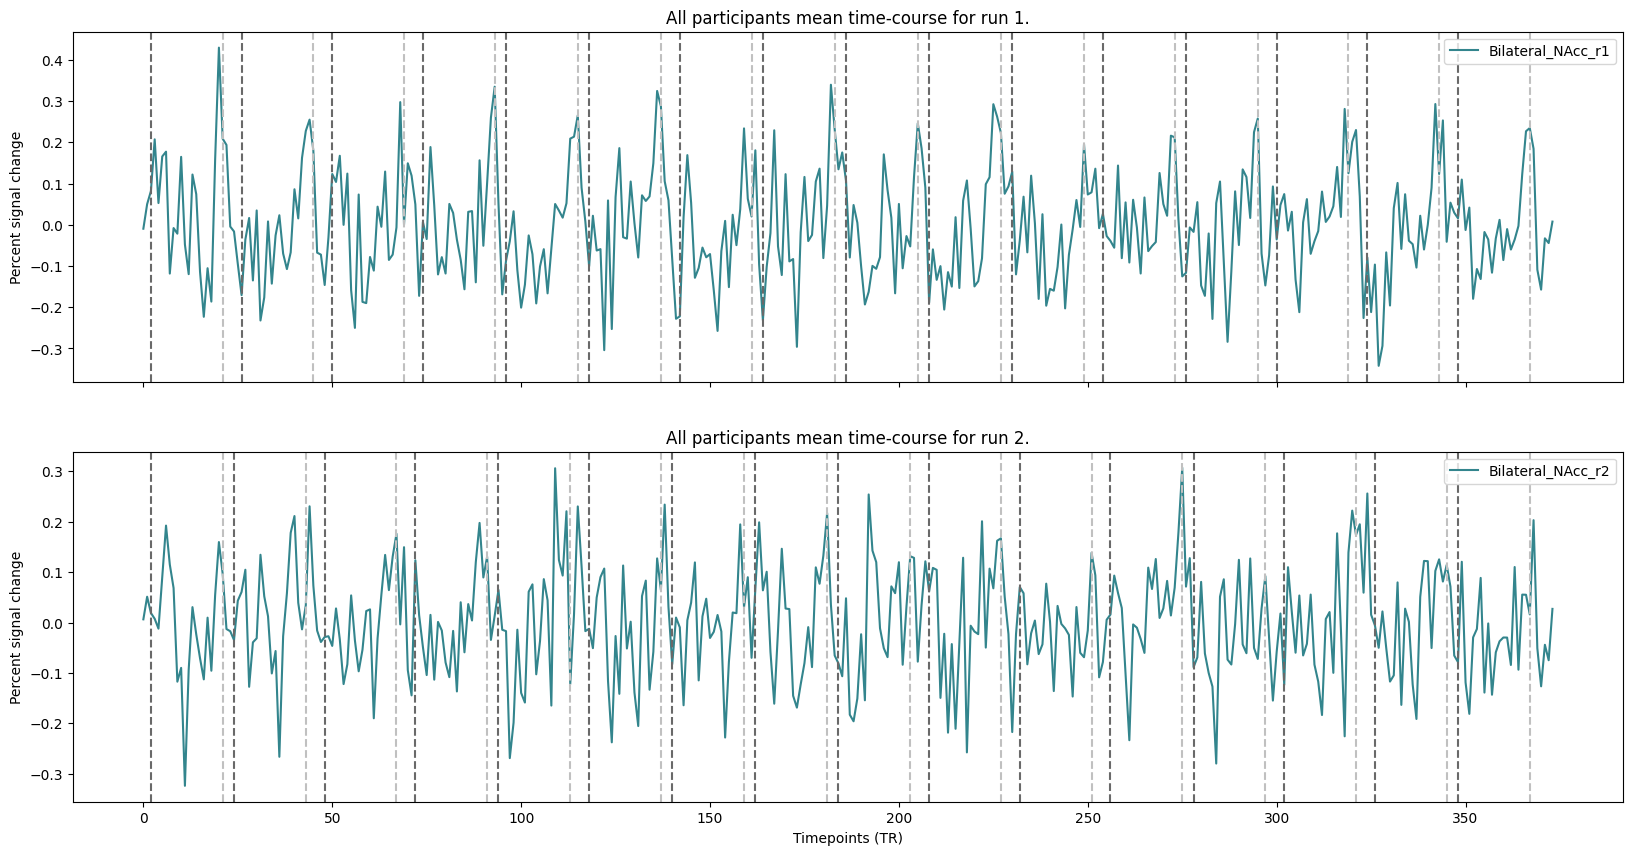

In [67]:
# Sanity check: Check whether V1 is coherently activated with AIM ROI. 

#r1_onsets = [12, 60.0, 108.0, 152.0, 196.0, 244.0, 288.0, 332.0, 376.0, 420.0, 468.0, 512.0, 560.0, 608.0, 656.0, 700.0]
#r1_offsets = [42, 90.0, 138.0, 182.0, 226.0, 274.0, 318.0, 362.0, 406.0, 450.0, 498.0, 542.0, 590.0, 638.0, 686.0, 730.0]

#r2_onsets = [12, 60.0, 108.0, 152.0, 196.0, 244.0, 288.0, 332.0, 376.0, 420.0, 468.0, 512.0, 560.0, 608.0, 656.0, 700.0]
#r2_offsets = [42, 90.0, 138.0, 182.0, 226.0, 274.0, 318.0, 362.0, 406.0, 450.0, 498.0, 542.0, 590.0, 638.0, 686.0, 730.0]

#r1_onsets = [12-8, 60.0-8, 108.0-8, 152.0-8, 196.0-8, 244.0-8, 288.0-8, 332.0-8, 376.0-8, 420.0-8, 468.0-8, 512.0-8, 560.0-8, 608.0-8, 656.0-8, 700.0-8]
#r1_offsets = [42-8, 90.0-8, 138.0-8, 182.0-8, 226.0-8, 274.0-8, 318.0-8, 362.0-8, 406.0-8, 450.0-8, 498.0-8, 542.0-8, 590.0-8, 638.0-8, 686.0-8, 730.0-8]

#r2_onsets = [12-8, 60.0-8, 108.0-8, 152.0-8, 196.0-8, 244.0-8, 288.0-8, 332.0-8, 376.0-8, 420.0-8, 468.0-8, 512.0-8, 560.0-8, 608.0-8, 656.0-8, 700.0-8]
#r2_offsets = [42-8, 90.0-8, 138.0-8, 182.0-8, 226.0-8, 274.0-8, 318.0-8, 362.0-8, 406.0-8, 450.0-8, 498.0-8, 542.0-8, 590.0-8, 638.0-8, 686.0-8, 730.0-8]

run1_onsets_array = np.array([12, 60, 108, 156, 200, 244, 292, 336, 380, 424, 468, 516, 560, 608, 656, 704])   
run2_onsets_array = np.array([12, 56, 104, 152, 196, 244, 288, 332, 376, 424, 472, 520, 564, 612, 660, 704])

r1_onsets = (run1_onsets_array - 8)/2
r1_offsets = (run1_onsets_array + 30)/2

r2_onsets = (run2_onsets_array - 8)/2
r2_offsets = (run2_onsets_array + 30)/2

# Concat all dataframes into one.
bNAcc_avg_raw_r1_df = all_subjects_NAcc_raw_df[(all_subjects_NAcc_raw_df["ROI"] == "Bilateral_NAcc_r1")]
bAIns_avg_raw_r1_df = all_subjects_AIns_raw_df[(all_subjects_AIns_raw_df["ROI"] == "Bilateral_AIns_r1")]
bMPFC_avg_raw_r1_df = all_subjects_MPFC_raw_df[(all_subjects_MPFC_raw_df["ROI"] == "Bilateral_MPFC_r1")]
#bV1_avg_raw_r1_df = all_subjects_V1_raw_df[(all_subjects_V1_raw_df["ROI"] == "Bilateral_V1_r1")]

bNAcc_avg_raw_r2_df = all_subjects_NAcc_raw_df[(all_subjects_NAcc_raw_df["ROI"] == "Bilateral_NAcc_r2")]
bAIns_avg_raw_r2_df = all_subjects_AIns_raw_df[(all_subjects_AIns_raw_df["ROI"] == "Bilateral_AIns_r2")]
bMPFC_avg_raw_r2_df = all_subjects_MPFC_raw_df[(all_subjects_MPFC_raw_df["ROI"] == "Bilateral_MPFC_r2")]
#bV1_avg_raw_r2_df = all_subjects_V1_raw_df[(all_subjects_V1_raw_df["ROI"] == "Bilateral_V1_r2")]

AIM_V1_ROIs_avg_r1_df = pd.concat([bNAcc_avg_raw_r1_df], axis=0, ignore_index=True) # bAIns_avg_raw_r1_df, bMPFC_avg_raw_r1_df, , bV1_avg_raw_r1_df
AIM_V1_ROIs_avg_r2_df = pd.concat([bNAcc_avg_raw_r2_df], axis=0, ignore_index=True) #bAIns_avg_raw_r2_df, bMPFC_avg_raw_r2_df, , bV1_avg_raw_r2_df
AIM_V1_ROIs_avg_r1_df = AIM_V1_ROIs_avg_r1_df.dropna()
AIM_V1_ROIs_avg_r2_df = AIM_V1_ROIs_avg_r2_df.dropna()

fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

sns.lineplot(data=AIM_V1_ROIs_avg_r1_df, x="TR", y="Signal", hue="ROI",
            legend="brief", ax=axs[0], errorbar="se", palette="crest")
#axs[0].set_ylim(-.7, .9)
#axs[0].set_xlim(-1, 250)
for i in range(len(r1_onsets)):
    axs[0].axvline(x = r1_onsets[i], color = 'dimgray', lw=1.5, linestyle='dashed')
    axs[0].axvline(x = r1_offsets[i], color = 'silver', lw=1.5, linestyle='dashed')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Percent signal change')
axs[0].set_xlabel('Timepoints (TR)')
axs[0].set_title("All participants mean time-course for run 1.")

sns.lineplot(data=AIM_V1_ROIs_avg_r2_df, x="TR", y="Signal", hue="ROI",
            legend="brief", ax=axs[1], errorbar="se", palette="crest")
#axs[1].set_ylim(-.7, .9)
#axs[1].set_xlim(-1, 250)
for i in range(len(r2_onsets)):
    axs[1].axvline(x = r2_onsets[i], color = 'dimgray', lw=1.5, linestyle='dashed')
    axs[1].axvline(x = r2_offsets[i], color = 'silver', lw=1.5, linestyle='dashed') 
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Percent signal change')
axs[1].set_xlabel('Timepoints (TR)')
axs[1].set_title("All participants mean time-course for run 2.")


In [68]:
# Okay, the above code will get the pearson code per TR per ROI per trailer.
trailer_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5',
                'rc3', 'rh12', 'rc1', 'rh7', 'rc8', 'rh10', 'uc3', 'rh4',
                'rc4', 'rh5', 'uc2', 'rh8', 'rc10', 'uh3', 'rc7', 'uh4']

# trailer -> Scores -> ROI -> Corrs per TR
NAcc_TR_correlations = {}
AIns_TR_correlations = {}
MPFC_TR_correlations = {}

# trailer -> Scores & ROI -> TRs (TR=1 for all participants)
Trailer_TR_Scores_dict = {}

for trailer_id in range(len(trailer_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if trailer_keys[trailer_id] in participant_dictionaries[d]]

    NAcc_current_corrs = {}
    AIns_current_corrs = {}
    MPFC_current_corrs = {}

    current_trailer_dict = {}

    NAcc_TR = {}
    AIns_TR = {}
    MPFC_TR = {}

    current_trailer_w_scores = np.zeros(len(participants_with_trailer))
    current_trailer_pa_scores = np.zeros(len(participants_with_trailer))
    current_trailer_na_scores = np.zeros(len(participants_with_trailer))

    current_trailer_TRs = np.zeros(len(participants_with_trailer))

    # Get the watch, arousal, and feel scores for each participant for the current trailer.
    for id in range(len(participants_with_trailer)):
        
        w_score = participants_events[participants_with_trailer[id]].loc[participants_events[participants_with_trailer[id]]["Trailer"] == trailer_keys[trailer_id]]["W_score_scaled"]
        pa_score = participants_events[participants_with_trailer[id]].loc[participants_events[participants_with_trailer[id]]["Trailer"] == trailer_keys[trailer_id]]["Pos_arousal_scaled"]
        na_score = participants_events[participants_with_trailer[id]].loc[participants_events[participants_with_trailer[id]]["Trailer"] == trailer_keys[trailer_id]]["Neg_arousal_scaled"]
    
        # Ensure only single value is assigned
        if not w_score.empty:
            current_trailer_w_scores[id] = w_score.iloc[0]
        if not pa_score.empty:
            current_trailer_pa_scores[id] = pa_score.iloc[0]
        if not na_score.empty:
            current_trailer_na_scores[id] = na_score.iloc[0]

    # Loop through each TR for the current trailer.
    for tr_id in range(15):

        NAcc_current_trailer_TRs_array = np.zeros(len(participants_with_trailer))
        AIns_current_trailer_TRs_array = np.zeros(len(participants_with_trailer))
        MPFC_current_trailer_TRs_array = np.zeros(len(participants_with_trailer))

        # Loop through each participant for each TR for the current trailer.
        for id2 in range(len(participants_with_trailer)):

            current_sub2 = str(participants_with_trailer[id2])

            NAcc_current_trailer_TRs_array[id2] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub2]["Bilateral_NAcc"][tr_id]
            AIns_current_trailer_TRs_array[id2] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub2]["Bilateral_AIns"][tr_id]
            MPFC_current_trailer_TRs_array[id2] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub2]["Bilateral_MPFC"][tr_id]

        # Replace NaN values with 0.
        current_trailer_pa_scores = np.nan_to_num(current_trailer_pa_scores)
        current_trailer_na_scores = np.nan_to_num(current_trailer_na_scores)
        current_trailer_w_scores = np.nan_to_num(current_trailer_w_scores)

        # Compute the correlation between the scores and the timecourse for the current TR.
        NAcc_current_corrs[str("TR_" + str(tr_id) + "_w")] = pearsonr(NAcc_current_trailer_TRs_array, current_trailer_w_scores)
        AIns_current_corrs[str("TR_" + str(tr_id) + "_w")] = pearsonr(AIns_current_trailer_TRs_array, current_trailer_w_scores)
        MPFC_current_corrs[str("TR_" + str(tr_id) + "_w")] = pearsonr(MPFC_current_trailer_TRs_array, current_trailer_w_scores) 


        NAcc_current_corrs[str("TR_" + str(tr_id) + "_pa")] = pearsonr(NAcc_current_trailer_TRs_array, current_trailer_pa_scores)
        AIns_current_corrs[str("TR_" + str(tr_id) + "_pa")] = pearsonr(AIns_current_trailer_TRs_array, current_trailer_pa_scores)
        MPFC_current_corrs[str("TR_" + str(tr_id) + "_pa")] = pearsonr(MPFC_current_trailer_TRs_array, current_trailer_pa_scores)

        NAcc_current_corrs[str("TR_" + str(tr_id) + "_na")] = pearsonr(NAcc_current_trailer_TRs_array, current_trailer_na_scores)
        AIns_current_corrs[str("TR_" + str(tr_id) + "_na")] = pearsonr(AIns_current_trailer_TRs_array, current_trailer_na_scores)
        MPFC_current_corrs[str("TR_" + str(tr_id) + "_na")] = pearsonr(MPFC_current_trailer_TRs_array, current_trailer_na_scores) 
                    
        NAcc_TR[str("TR_" + str(tr_id))] = NAcc_current_trailer_TRs_array
        AIns_TR[str("TR_" + str(tr_id))] = AIns_current_trailer_TRs_array
        MPFC_TR[str("TR_" + str(tr_id))] = MPFC_current_trailer_TRs_array

    # Add code to compute correlatation accross trailer segments(onset, middle, offset, and whole).
    NAcc_current_trailer_onset_array = np.zeros(len(participants_with_trailer))
    AIns_current_trailer_onset_array = np.zeros(len(participants_with_trailer))
    MPFC_current_trailer_onset_array = np.zeros(len(participants_with_trailer))

    NAcc_current_trailer_offset_array = np.zeros(len(participants_with_trailer))
    AIns_current_trailer_offset_array = np.zeros(len(participants_with_trailer))
    MPFC_current_trailer_offset_array = np.zeros(len(participants_with_trailer))

    NAcc_current_trailer_middle_array = np.zeros(len(participants_with_trailer))
    AIns_current_trailer_middle_array = np.zeros(len(participants_with_trailer))
    MPFC_current_trailer_middle_array = np.zeros(len(participants_with_trailer))

    NAcc_current_trailer_whole_array = np.zeros(len(participants_with_trailer))
    AIns_current_trailer_whole_array = np.zeros(len(participants_with_trailer))
    MPFC_current_trailer_whole_array = np.zeros(len(participants_with_trailer))
    
    # Loop through each participant the current trailer.
    for sub_id3 in range(len(participants_with_trailer)):

        current_sub3 = str(participants_with_trailer[sub_id3])

        # Compute the mean timecourse for the onset, middle, and offset of the current trailer.
        NAcc_current_trailer_onset_array[sub_id3] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_NAcc"][0:5].mean()
        AIns_current_trailer_onset_array[sub_id3] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_AIns"][0:5].mean()
        MPFC_current_trailer_onset_array[sub_id3] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_MPFC"][0:5].mean()

        NAcc_current_trailer_middle_array[sub_id3] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_NAcc"][5:10].mean()
        AIns_current_trailer_middle_array[sub_id3] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_AIns"][5:10].mean()
        MPFC_current_trailer_middle_array[sub_id3] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_MPFC"][5:10].mean()

        NAcc_current_trailer_offset_array[sub_id3] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_NAcc"][10:15].mean()
        AIns_current_trailer_offset_array[sub_id3] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_AIns"][10:15].mean()
        MPFC_current_trailer_offset_array[sub_id3] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_MPFC"][10:15].mean()

        NAcc_current_trailer_whole_array[sub_id3] = all_subjects_NAcc_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_NAcc"].mean()
        AIns_current_trailer_whole_array[sub_id3] = all_subjects_AIns_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_AIns"].mean()
        MPFC_current_trailer_whole_array[sub_id3] = all_subjects_MPFC_timecourse[trailer_keys[trailer_id]][current_sub3]["Bilateral_MPFC"].mean()

    # Compute the correlation between the scores and the timecourse for the current TR.
    NAcc_current_corrs[str("Onset_w")] = pearsonr(NAcc_current_trailer_onset_array, current_trailer_w_scores)
    AIns_current_corrs[str("Onset_w")] = pearsonr(AIns_current_trailer_onset_array, current_trailer_w_scores)
    MPFC_current_corrs[str("Onset_w")] = pearsonr(MPFC_current_trailer_onset_array, current_trailer_w_scores)
    NAcc_current_corrs[str("Middle_w")] = pearsonr(NAcc_current_trailer_middle_array, current_trailer_w_scores)
    AIns_current_corrs[str("Middle_w")] = pearsonr(AIns_current_trailer_middle_array, current_trailer_w_scores)
    MPFC_current_corrs[str("Middle_w")] = pearsonr(MPFC_current_trailer_middle_array, current_trailer_w_scores)
    NAcc_current_corrs[str("Offset_w")] = pearsonr(NAcc_current_trailer_offset_array, current_trailer_w_scores)
    AIns_current_corrs[str("Offset_w")] = pearsonr(AIns_current_trailer_offset_array, current_trailer_w_scores)
    MPFC_current_corrs[str("Offset_w")] = pearsonr(MPFC_current_trailer_offset_array, current_trailer_w_scores)
    NAcc_current_corrs[str("Whole_w")] = pearsonr(NAcc_current_trailer_whole_array, current_trailer_w_scores)
    AIns_current_corrs[str("Whole_w")] = pearsonr(AIns_current_trailer_whole_array, current_trailer_w_scores)
    MPFC_current_corrs[str("Whole_w")] = pearsonr(MPFC_current_trailer_whole_array, current_trailer_w_scores)

    NAcc_current_corrs[str("Onset_pa")] = pearsonr(NAcc_current_trailer_onset_array, current_trailer_pa_scores)
    AIns_current_corrs[str("Onset_pa")] = pearsonr(AIns_current_trailer_onset_array, current_trailer_pa_scores)
    MPFC_current_corrs[str("Onset_pa")] = pearsonr(MPFC_current_trailer_onset_array, current_trailer_pa_scores)
    NAcc_current_corrs[str("Middle_pa")] = pearsonr(NAcc_current_trailer_middle_array, current_trailer_pa_scores)
    AIns_current_corrs[str("Middle_pa")] = pearsonr(AIns_current_trailer_middle_array, current_trailer_pa_scores)
    MPFC_current_corrs[str("Middle_pa")] = pearsonr(MPFC_current_trailer_middle_array, current_trailer_pa_scores)
    NAcc_current_corrs[str("Offset_pa")] = pearsonr(NAcc_current_trailer_offset_array, current_trailer_pa_scores)
    AIns_current_corrs[str("Offset_pa")] = pearsonr(AIns_current_trailer_offset_array, current_trailer_pa_scores)
    MPFC_current_corrs[str("Offset_pa")] = pearsonr(MPFC_current_trailer_offset_array, current_trailer_pa_scores)
    NAcc_current_corrs[str("Whole_pa")] = pearsonr(NAcc_current_trailer_whole_array, current_trailer_pa_scores)
    AIns_current_corrs[str("Whole_pa")] = pearsonr(AIns_current_trailer_whole_array, current_trailer_pa_scores)
    MPFC_current_corrs[str("Whole_pa")] = pearsonr(MPFC_current_trailer_whole_array, current_trailer_pa_scores)

    NAcc_current_corrs[str("Onset_na")] = pearsonr(NAcc_current_trailer_onset_array, current_trailer_na_scores)
    AIns_current_corrs[str("Onset_na")] = pearsonr(AIns_current_trailer_onset_array, current_trailer_na_scores)
    MPFC_current_corrs[str("Onset_na")] = pearsonr(MPFC_current_trailer_onset_array, current_trailer_na_scores)
    NAcc_current_corrs[str("Middle_na")] = pearsonr(NAcc_current_trailer_middle_array, current_trailer_na_scores)
    AIns_current_corrs[str("Middle_na")] = pearsonr(AIns_current_trailer_middle_array, current_trailer_na_scores)
    MPFC_current_corrs[str("Middle_na")] = pearsonr(MPFC_current_trailer_middle_array, current_trailer_na_scores)
    NAcc_current_corrs[str("Offset_na")] = pearsonr(NAcc_current_trailer_offset_array, current_trailer_na_scores)
    AIns_current_corrs[str("Offset_na")] = pearsonr(AIns_current_trailer_offset_array, current_trailer_na_scores)
    MPFC_current_corrs[str("Offset_na")] = pearsonr(MPFC_current_trailer_offset_array, current_trailer_na_scores)
    NAcc_current_corrs[str("Whole_na")] = pearsonr(NAcc_current_trailer_whole_array, current_trailer_na_scores)
    AIns_current_corrs[str("Whole_na")] = pearsonr(AIns_current_trailer_whole_array, current_trailer_na_scores)
    MPFC_current_corrs[str("Whole_na")] = pearsonr(MPFC_current_trailer_whole_array, current_trailer_na_scores)

    current_trailer_dict["W_score_scaled"] = current_trailer_w_scores
    current_trailer_dict["Pos_arousal_scaled"] = current_trailer_pa_scores
    current_trailer_dict["Neg_arousal_scaled"] = current_trailer_na_scores
    current_trailer_dict["NAcc_TR"] = NAcc_TR
    current_trailer_dict["AIns_TR"] = AIns_TR
    current_trailer_dict["MPFC_TR"] = MPFC_TR

    Trailer_TR_Scores_dict[trailer_keys[trailer_id]] = current_trailer_dict

    # Store the trailer correlations in higher dict.  
    NAcc_TR_correlations[trailer_keys[trailer_id]] = NAcc_current_corrs
    AIns_TR_correlations[trailer_keys[trailer_id]] = AIns_current_corrs
    MPFC_TR_correlations[trailer_keys[trailer_id]] = MPFC_current_corrs

In [70]:
# Get correlation across all comedy trailers for each TR. 
# See which TR is most correlated with the scores.

comedy_keys = ['rc1', 'rc2', 'rc3', 'rc4', 'rc5', 'rc6', 'rc7', 'rc8', 'rc9', 'rc10', 'rc11', 'rc12',
               'uc1', 'uc2', 'uc3', 'uc4']

Comedy_NAccTRs_cors_dict = {}
Comedy_AInsTRs_cors_dict = {}
Comedy_MPFCTRs_cors_dict = {}

# Create list to store each trailer TR X values for each participant.
C_NAcc_TR1 = []
C_NAcc_TR2 = []
C_NAcc_TR3 = []
C_NAcc_TR4 = []
C_NAcc_TR5 = []
C_NAcc_TR6 = []
C_NAcc_TR7 = []
C_NAcc_TR8 = []
C_NAcc_TR9 = []
C_NAcc_TR10 = []
C_NAcc_TR11 = []
C_NAcc_TR12 = []
C_NAcc_TR13 = []
C_NAcc_TR14 = []
C_NAcc_TR15 = []
C_NAcc_onset = []
C_NAcc_middle = []
C_NAcc_offset = []
C_NAcc_whole = []

C_AIns_TR1 = []
C_AIns_TR2 = []
C_AIns_TR3 = []
C_AIns_TR4 = []
C_AIns_TR5 = []
C_AIns_TR6 = []
C_AIns_TR7 = []
C_AIns_TR8 = []
C_AIns_TR9 = []
C_AIns_TR10 = []
C_AIns_TR11 = []
C_AIns_TR12 = []
C_AIns_TR13 = []
C_AIns_TR14 = []
C_AIns_TR15 = []
C_AIns_onset = []
C_AIns_middle = []
C_AIns_offset = []
C_AIns_whole = []

C_MPFC_TR1 = []
C_MPFC_TR2 = []
C_MPFC_TR3 = []
C_MPFC_TR4 = []
C_MPFC_TR5 = []
C_MPFC_TR6 = []
C_MPFC_TR7 = []
C_MPFC_TR8 = []
C_MPFC_TR9 = []
C_MPFC_TR10 = []
C_MPFC_TR11 = []
C_MPFC_TR12 = []
C_MPFC_TR13 = []
C_MPFC_TR14 = []
C_MPFC_TR15 = []
C_MPFC_onset = []
C_MPFC_middle = []
C_MPFC_offset = []
C_MPFC_whole = []

# Create lists to store the scores for each participant for the current trailer.
C_W_scores = []
C_PA_scores = []
C_NA_scores = []

for trailer_id in range(len(comedy_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if comedy_keys[trailer_id] in participant_dictionaries[d]]

    # Loop through each participant for each TR for the current trailer.
    for sub_id2 in range(len(participants_with_trailer)):

        current_sub = str(participants_with_trailer[sub_id2])

        # Append the current TR value for the current participant to the list.
        C_NAcc_TR1.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][0])
        C_NAcc_TR2.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][1])
        C_NAcc_TR3.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][2])
        C_NAcc_TR4.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][3])
        C_NAcc_TR5.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][4])
        C_NAcc_TR6.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][5])
        C_NAcc_TR7.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][6])
        C_NAcc_TR8.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][7])
        C_NAcc_TR9.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][8])
        C_NAcc_TR10.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][9])
        C_NAcc_TR11.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][10])
        C_NAcc_TR12.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][11])
        C_NAcc_TR13.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][12])
        C_NAcc_TR14.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][13])
        C_NAcc_TR15.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][14])
        C_NAcc_onset.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][0:5].mean())
        C_NAcc_middle.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][5:10].mean())
        C_NAcc_offset.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"][10:15].mean())
        C_NAcc_whole.append(all_subjects_NAcc_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_NAcc"].mean())

        C_AIns_TR1.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][0])
        C_AIns_TR2.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][1])
        C_AIns_TR3.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][2])
        C_AIns_TR4.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][3])
        C_AIns_TR5.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][4])
        C_AIns_TR6.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][5])
        C_AIns_TR7.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][6])
        C_AIns_TR8.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][7])
        C_AIns_TR9.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][8])
        C_AIns_TR10.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][9])
        C_AIns_TR11.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][10])
        C_AIns_TR12.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][11])
        C_AIns_TR13.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][12])
        C_AIns_TR14.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][13])
        C_AIns_TR15.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][14])
        C_AIns_onset.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][0:5].mean())
        C_AIns_middle.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][5:10].mean())
        C_AIns_offset.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"][10:15].mean())
        C_AIns_whole.append(all_subjects_AIns_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_AIns"].mean())

        C_MPFC_TR1.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][0])
        C_MPFC_TR2.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][1])
        C_MPFC_TR3.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][2])
        C_MPFC_TR4.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][3])
        C_MPFC_TR5.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][4])
        C_MPFC_TR6.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][5])
        C_MPFC_TR7.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][6])
        C_MPFC_TR8.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][7])
        C_MPFC_TR9.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][8])
        C_MPFC_TR10.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][9])
        C_MPFC_TR11.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][10])
        C_MPFC_TR12.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][11])
        C_MPFC_TR13.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][12])
        C_MPFC_TR14.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][13])
        C_MPFC_TR15.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][14])
        C_MPFC_onset.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][0:5].mean())
        C_MPFC_middle.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][5:10].mean())
        C_MPFC_offset.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"][10:15].mean())
        C_MPFC_whole.append(all_subjects_MPFC_timecourse[comedy_keys[trailer_id]][current_sub]["Bilateral_MPFC"].mean())

# Store all list in bigger list for each ROI. 
C_NAcc_TRs = [C_NAcc_TR1, C_NAcc_TR2, C_NAcc_TR3, C_NAcc_TR4, C_NAcc_TR5, C_NAcc_TR6, C_NAcc_TR7, C_NAcc_TR8, C_NAcc_TR9, C_NAcc_TR10, C_NAcc_TR11, C_NAcc_TR12, C_NAcc_TR13, C_NAcc_TR14, C_NAcc_TR15]
C_AIns_TRs = [C_AIns_TR1, C_AIns_TR2, C_AIns_TR3, C_AIns_TR4, C_AIns_TR5, C_AIns_TR6, C_AIns_TR7, C_AIns_TR8, C_AIns_TR9, C_AIns_TR10, C_AIns_TR11, C_AIns_TR12, C_AIns_TR13, C_AIns_TR14, C_AIns_TR15]
C_MPFC_TRs = [C_MPFC_TR1, C_MPFC_TR2, C_MPFC_TR3, C_MPFC_TR4, C_MPFC_TR5, C_MPFC_TR6, C_MPFC_TR7, C_MPFC_TR8, C_MPFC_TR9, C_MPFC_TR10, C_MPFC_TR11, C_MPFC_TR12, C_MPFC_TR13, C_MPFC_TR14, C_MPFC_TR15]

# Get W, PA, and NA scores. 
C_W_scores = np.zeros(len(C_NAcc_TR1))
C_PA_scores = np.zeros(len(C_NAcc_TR1))
C_NA_scores = np.zeros(len(C_NAcc_TR1))

for trailer_id in range(len(comedy_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if comedy_keys[trailer_id] in participant_dictionaries[d]]

    # Get the watch, arousal, and feel scores for each participant for the current trailer.
    for sub_id in range(len(participants_with_trailer)):
        
        w_score = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == comedy_keys[trailer_id]]["W_score_scaled"]
        pa_score = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == comedy_keys[trailer_id]]["Pos_arousal_scaled"]
        na_score = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == comedy_keys[trailer_id]]["Neg_arousal_scaled"]
    
        # Ensure only single value is assigned
        if not w_score.empty:
            C_W_scores[sub_id] = w_score.iloc[0]
        if not pa_score.empty:
            C_PA_scores[sub_id] = pa_score.iloc[0]
        if not na_score.empty:
            C_NA_scores[sub_id] = na_score.iloc[0]

for tr_id in range(15):
    
    # Compute the correlation between the scores and the timecourse for the current TR.
    Comedy_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(C_NAcc_TRs[tr_id], C_W_scores)
    Comedy_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(C_AIns_TRs[tr_id], C_W_scores)
    Comedy_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(C_MPFC_TRs[tr_id], C_W_scores)

    Comedy_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(C_NAcc_TRs[tr_id], C_PA_scores)
    Comedy_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(C_AIns_TRs[tr_id], C_PA_scores)
    Comedy_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(C_MPFC_TRs[tr_id], C_PA_scores)

    Comedy_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(C_NAcc_TRs[tr_id], C_NA_scores)
    Comedy_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(C_AIns_TRs[tr_id], C_NA_scores)
    Comedy_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(C_MPFC_TRs[tr_id], C_NA_scores)

# Store time segments in lists.
C_NAcc_seg = [C_NAcc_onset, C_NAcc_middle, C_NAcc_offset, C_NAcc_whole]
C_AIns_seg = [C_AIns_onset, C_AIns_middle, C_AIns_offset, C_AIns_whole]
C_MPFC_seg = [C_MPFC_onset, C_MPFC_middle, C_MPFC_offset, C_MPFC_whole]
Seg_labels = ["Onset", "Middle", "Offset", "Whole"]

for seg_id in range(4):
        
    # Compute the correlation between the scores and the timecourse for the current TR.
    Comedy_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(C_NAcc_seg[seg_id], C_W_scores)
    Comedy_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(C_AIns_seg[seg_id], C_W_scores)
    Comedy_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(C_MPFC_seg[seg_id], C_W_scores)
    
    Comedy_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(C_NAcc_seg[seg_id], C_PA_scores)
    Comedy_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(C_AIns_seg[seg_id], C_PA_scores)
    Comedy_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(C_MPFC_seg[seg_id], C_PA_scores)
    
    Comedy_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(C_NAcc_seg[seg_id], C_NA_scores)
    Comedy_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(C_AIns_seg[seg_id], C_NA_scores)
    Comedy_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(C_MPFC_seg[seg_id], C_NA_scores)



In [71]:
# Get correlation across all horror trailers for each TR. 
# See which TR is most correlated with the scores.

horror_keys = ['rh1', 'rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8', 'rh9', 'rh10', 'rh11', 'rh12', 
               'uh1', 'uh2', 'uh3', 'uh4']

Horror_NAccTRs_cors_dict = {}
Horror_AInsTRs_cors_dict = {}
Horror_MPFCTRs_cors_dict = {}

# Create list to store each trailer TR X values for each participant.
H_NAcc_TR1 = []
H_NAcc_TR2 = []
H_NAcc_TR3 = []
H_NAcc_TR4 = []
H_NAcc_TR5 = []
H_NAcc_TR6 = []
H_NAcc_TR7 = []
H_NAcc_TR8 = []
H_NAcc_TR9 = []
H_NAcc_TR10 = []
H_NAcc_TR11 = []
H_NAcc_TR12 = []
H_NAcc_TR13 = []
H_NAcc_TR14 = []
H_NAcc_TR15 = []
H_NAcc_Onset = []
H_NAcc_Middle = []
H_NAcc_Offset = []
H_NAcc_Whole = []

H_AIns_TR1 = []
H_AIns_TR2 = []
H_AIns_TR3 = []
H_AIns_TR4 = []
H_AIns_TR5 = []
H_AIns_TR6 = []
H_AIns_TR7 = []
H_AIns_TR8 = []
H_AIns_TR9 = []
H_AIns_TR10 = []
H_AIns_TR11 = []
H_AIns_TR12 = []
H_AIns_TR13 = []
H_AIns_TR14 = []
H_AIns_TR15 = []
H_AIns_Onset = []
H_AIns_Middle = []
H_AIns_Offset = []
H_AIns_Whole = []

H_MPFC_TR1 = []
H_MPFC_TR2 = []
H_MPFC_TR3 = []
H_MPFC_TR4 = []
H_MPFC_TR5 = []
H_MPFC_TR6 = []
H_MPFC_TR7 = []
H_MPFC_TR8 = []
H_MPFC_TR9 = []
H_MPFC_TR10 = []
H_MPFC_TR11 = []
H_MPFC_TR12 = []
H_MPFC_TR13 = []
H_MPFC_TR14 = []
H_MPFC_TR15 = []
H_MPFC_Onset = []
H_MPFC_Middle = []
H_MPFC_Offset = []
H_MPFC_Whole = []

# Create lists to store the scores for each participant for the current trailer.
H_W_scores = []
H_PA_scores = []
H_NA_scores = []

for trailer_id in range(len(horror_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if horror_keys[trailer_id] in participant_dictionaries[d]]

    # Loop through each participant for each TR for the current trailer.
    for sub_id2 in range(len(participants_with_trailer)):

        current_sub = str(participants_with_trailer[sub_id2])

        # Append the current TR value for the current participant to the list.
        H_NAcc_TR1.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][0])
        H_NAcc_TR2.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][1])
        H_NAcc_TR3.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][2])
        H_NAcc_TR4.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][3])
        H_NAcc_TR5.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][4])
        H_NAcc_TR6.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][5])
        H_NAcc_TR7.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][6])
        H_NAcc_TR8.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][7])
        H_NAcc_TR9.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][8])
        H_NAcc_TR10.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][9])
        H_NAcc_TR11.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][10])
        H_NAcc_TR12.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][11])
        H_NAcc_TR13.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][12])
        H_NAcc_TR14.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][13])
        H_NAcc_TR15.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][14])
        H_NAcc_Onset.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][0:5].mean())
        H_NAcc_Middle.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][5:10].mean())
        H_NAcc_Offset.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"][10:15].mean())
        H_NAcc_Whole.append(all_subjects_NAcc_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_NAcc"].mean())

        H_AIns_TR1.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][0])
        H_AIns_TR2.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][1])
        H_AIns_TR3.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][2])
        H_AIns_TR4.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][3])
        H_AIns_TR5.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][4])
        H_AIns_TR6.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][5])
        H_AIns_TR7.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][6])
        H_AIns_TR8.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][7])
        H_AIns_TR9.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][8])
        H_AIns_TR10.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][9])
        H_AIns_TR11.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][10])
        H_AIns_TR12.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][11])
        H_AIns_TR13.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][12])
        H_AIns_TR14.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][13])
        H_AIns_TR15.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][14])
        H_AIns_Onset.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][0:5].mean())
        H_AIns_Middle.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][5:10].mean())
        H_AIns_Offset.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"][10:15].mean())
        H_AIns_Whole.append(all_subjects_AIns_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_AIns"].mean())

        H_MPFC_TR1.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][0])
        H_MPFC_TR2.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][1])
        H_MPFC_TR3.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][2])
        H_MPFC_TR4.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][3])
        H_MPFC_TR5.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][4])
        H_MPFC_TR6.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][5])
        H_MPFC_TR7.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][6])
        H_MPFC_TR8.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][7])
        H_MPFC_TR9.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][8])
        H_MPFC_TR10.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][9])
        H_MPFC_TR11.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][10])
        H_MPFC_TR12.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][11])
        H_MPFC_TR13.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][12])
        H_MPFC_TR14.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][13])
        H_MPFC_TR15.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][14])
        H_MPFC_Onset.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][0:5].mean())
        H_MPFC_Middle.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][5:10].mean())
        H_MPFC_Offset.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"][10:15].mean())
        H_MPFC_Whole.append(all_subjects_MPFC_timecourse[horror_keys[trailer_id]][current_sub]["Bilateral_MPFC"].mean())

# Store all list in bigger list for each ROI.
H_NAcc_TRs = [H_NAcc_TR1, H_NAcc_TR2, H_NAcc_TR3, H_NAcc_TR4, H_NAcc_TR5, H_NAcc_TR6, H_NAcc_TR7, H_NAcc_TR8, H_NAcc_TR9, H_NAcc_TR10, H_NAcc_TR11, H_NAcc_TR12, H_NAcc_TR13, H_NAcc_TR14, H_NAcc_TR15]
H_AIns_TRs = [H_AIns_TR1, H_AIns_TR2, H_AIns_TR3, H_AIns_TR4, H_AIns_TR5, H_AIns_TR6, H_AIns_TR7, H_AIns_TR8, H_AIns_TR9, H_AIns_TR10, H_AIns_TR11, H_AIns_TR12, H_AIns_TR13, H_AIns_TR14, H_AIns_TR15]
H_MPFC_TRs = [H_MPFC_TR1, H_MPFC_TR2, H_MPFC_TR3, H_MPFC_TR4, H_MPFC_TR5, H_MPFC_TR6, H_MPFC_TR7, H_MPFC_TR8, H_MPFC_TR9, H_MPFC_TR10, H_MPFC_TR11, H_MPFC_TR12, H_MPFC_TR13, H_MPFC_TR14, H_MPFC_TR15]

# Get W, PA, and NA scores.
H_W_scores = np.zeros(len(H_NAcc_TR1))
H_PA_scores = np.zeros(len(H_NAcc_TR1))
H_NA_scores = np.zeros(len(H_NAcc_TR1))

for trailer_id in range(len(horror_keys)):

    # Create new participant list with only the participants that have the current trailer.
    participants_with_trailer = [d for d in participant_dictionaries if horror_keys[trailer_id] in participant_dictionaries[d]]

    # Get the watch, arousal, and feel scores for each participant for the current trailer.
    for sub_id in range(len(participants_with_trailer)):
        
        w_score = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == horror_keys[trailer_id]]["W_score_scaled"]
        pa_score = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == horror_keys[trailer_id]]["Pos_arousal_scaled"]
        na_score = participants_events[participants_with_trailer[sub_id]].loc[participants_events[participants_with_trailer[sub_id]]["Trailer"] == horror_keys[trailer_id]]["Neg_arousal_scaled"]
    
        # Ensure only single value is assigned
        if not w_score.empty:
            H_W_scores[sub_id] = w_score.iloc[0]
        if not pa_score.empty:
            H_PA_scores[sub_id] = pa_score.iloc[0]
        if not na_score.empty:
            H_NA_scores[sub_id] = na_score.iloc[0]
            
for tr_id in range(15):

    # Compute the correlation between the scores and the timecourse for the current TR.
    Horror_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(H_NAcc_TRs[tr_id], H_W_scores)
    Horror_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(H_AIns_TRs[tr_id], H_W_scores)
    Horror_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_w")] = pearsonr(H_MPFC_TRs[tr_id], H_W_scores)

    Horror_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(H_NAcc_TRs[tr_id], H_PA_scores)
    Horror_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(H_AIns_TRs[tr_id], H_PA_scores)
    Horror_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_pa")] = pearsonr(H_MPFC_TRs[tr_id], H_PA_scores)

    Horror_NAccTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(H_NAcc_TRs[tr_id], H_NA_scores)
    Horror_AInsTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(H_AIns_TRs[tr_id], H_NA_scores)
    Horror_MPFCTRs_cors_dict[str("TR_" + str(tr_id) + "_na")] = pearsonr(H_MPFC_TRs[tr_id], H_NA_scores)

# Store time segments in lists.
H_NAcc_seg = [H_NAcc_Onset, H_NAcc_Middle, H_NAcc_Offset, H_NAcc_Whole]
H_AIns_seg = [H_AIns_Onset, H_AIns_Middle, H_AIns_Offset, H_AIns_Whole]
H_MPFC_seg = [H_MPFC_Onset, H_MPFC_Middle, H_MPFC_Offset, H_MPFC_Whole]

for seg_id in range(4):

    # Compute the correlation between the scores and the timecourse for the current TR.
    Horror_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(H_NAcc_seg[seg_id], H_W_scores)
    Horror_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(H_AIns_seg[seg_id], H_W_scores)
    Horror_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_w")] = pearsonr(H_MPFC_seg[seg_id], H_W_scores)

    Horror_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(H_NAcc_seg[seg_id], H_PA_scores)
    Horror_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(H_AIns_seg[seg_id], H_PA_scores)
    Horror_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_pa")] = pearsonr(H_MPFC_seg[seg_id], H_PA_scores)

    Horror_NAccTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(H_NAcc_seg[seg_id], H_NA_scores)
    Horror_AInsTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(H_AIns_seg[seg_id], H_NA_scores)
    Horror_MPFCTRs_cors_dict[str(Seg_labels[seg_id] + "_na")] = pearsonr(H_MPFC_seg[seg_id], H_NA_scores)


In [72]:
# Create dataframes, one with all time points from comedy trailers, 
# another with all time points from horror trailers.

all_subjects_NAcc_comedy_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])
all_subjects_AIns_comedy_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])
all_subjects_MPFC_comedy_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])

# Loop through each comedy trailer.
for trailer_id in range(len(comedy_keys)):

    # Obtain the current trailer dataframes.
    NAcc_current_trailer_df = all_subjects_NAcc_timecourse_df[comedy_keys[trailer_id]]
    AIns_current_trailer_df = all_subjects_AIns_timecourse_df[comedy_keys[trailer_id]]
    MPFC_current_trailer_df = all_subjects_MPFC_timecourse_df[comedy_keys[trailer_id]]

    # Concat the current trailer dataframes to the main dataframes.
    all_subjects_NAcc_comedy_df = pd.concat([all_subjects_NAcc_comedy_df, NAcc_current_trailer_df])
    all_subjects_AIns_comedy_df = pd.concat([all_subjects_AIns_comedy_df, AIns_current_trailer_df])
    all_subjects_MPFC_comedy_df = pd.concat([all_subjects_MPFC_comedy_df, MPFC_current_trailer_df])
    
# Create dataframes for horror trailers,
all_subjects_NAcc_horror_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])
all_subjects_AIns_horror_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])
all_subjects_MPFC_horror_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])

# Loop through each horror trailer.
for trailer_id in range(len(horror_keys)):

    # Obtain the current trailer dataframes.
    NAcc_current_trailer_df = all_subjects_NAcc_timecourse_df[horror_keys[trailer_id]]
    AIns_current_trailer_df = all_subjects_AIns_timecourse_df[horror_keys[trailer_id]]
    MPFC_current_trailer_df = all_subjects_MPFC_timecourse_df[horror_keys[trailer_id]]

    # Concat the current trailer dataframes to the main dataframes.
    all_subjects_NAcc_horror_df = pd.concat([all_subjects_NAcc_horror_df, NAcc_current_trailer_df])
    all_subjects_AIns_horror_df = pd.concat([all_subjects_AIns_horror_df, AIns_current_trailer_df])
    all_subjects_MPFC_horror_df = pd.concat([all_subjects_MPFC_horror_df, MPFC_current_trailer_df])


In [73]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

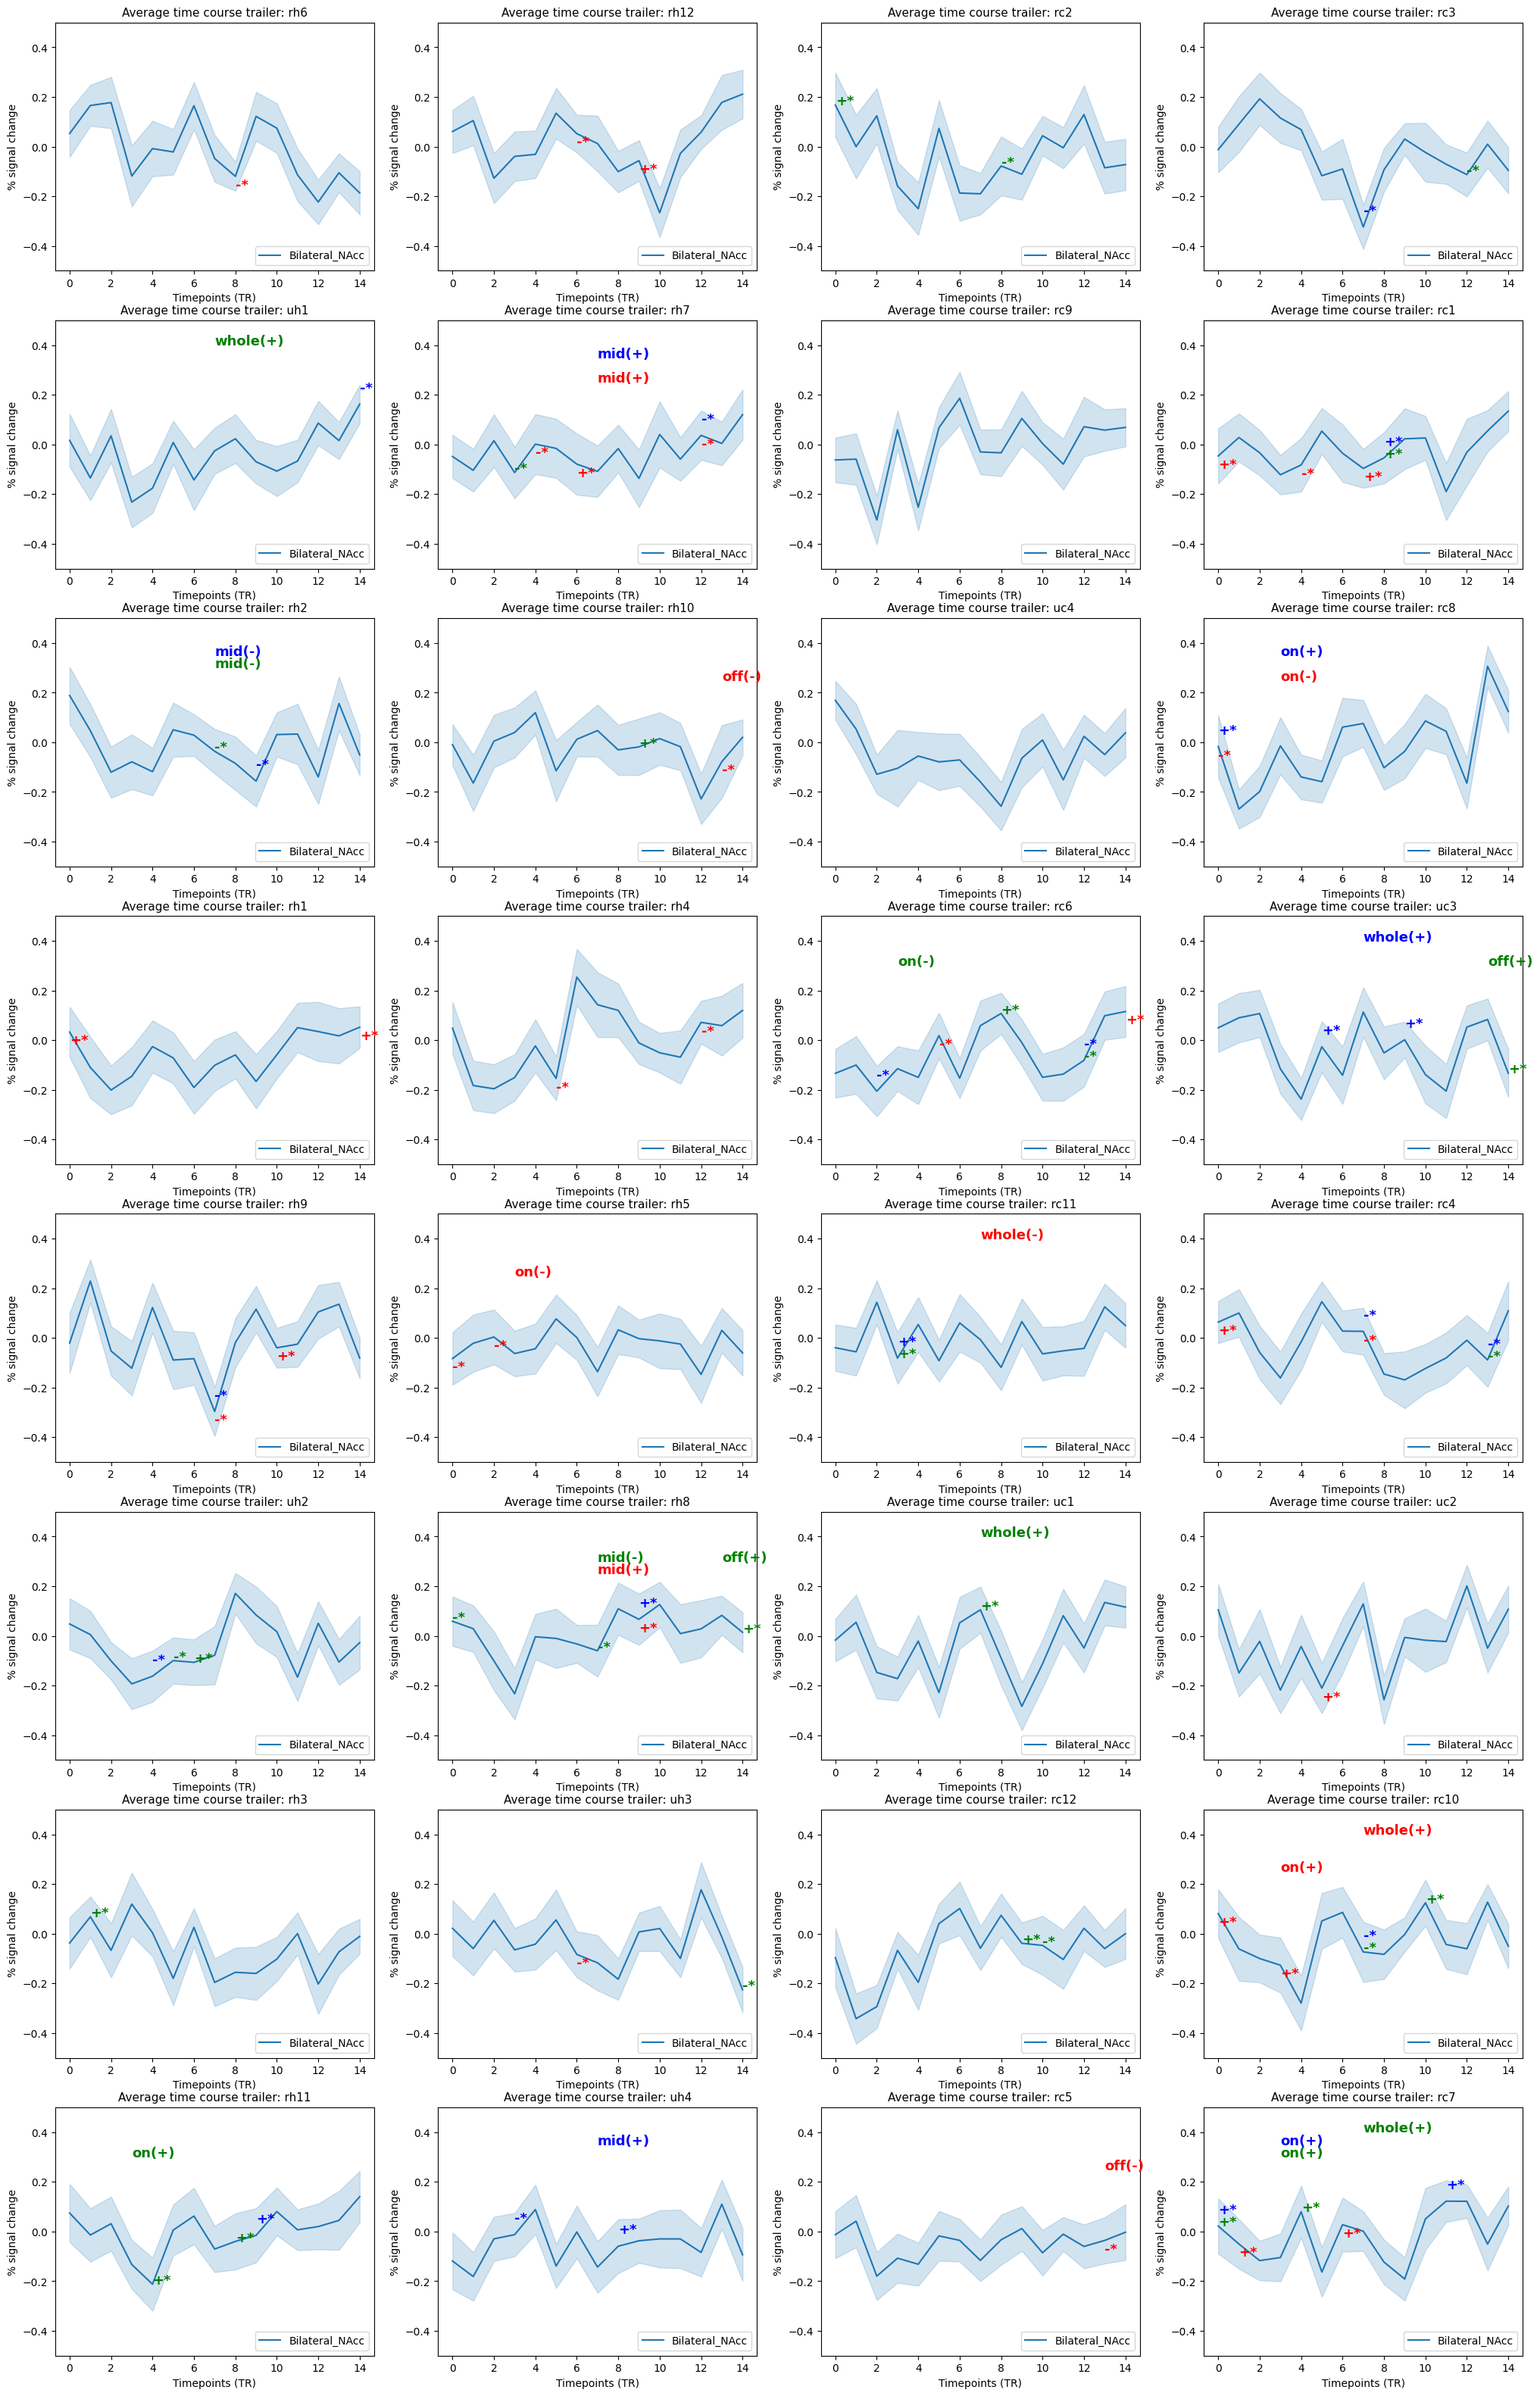

In [74]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.5, .5)
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 0])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 0])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 0])


    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.5, .5)
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 1])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 1])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 1])
    runner +=1

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.5, .5)
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 2])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 2])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r1_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 2])


    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 3], errorbar="se")
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.5, .5)
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "W_score", axs[id, 3])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Pos_arousal", axs[id, 3])
    plot_trailer_correlations(all_subjects_NAcc_timecourse_df, r2_keys_sorted[runner], "Bilateral_NAcc", NAcc_TR_correlations, "Neg_arousal", axs[id, 3])
    runner +=1

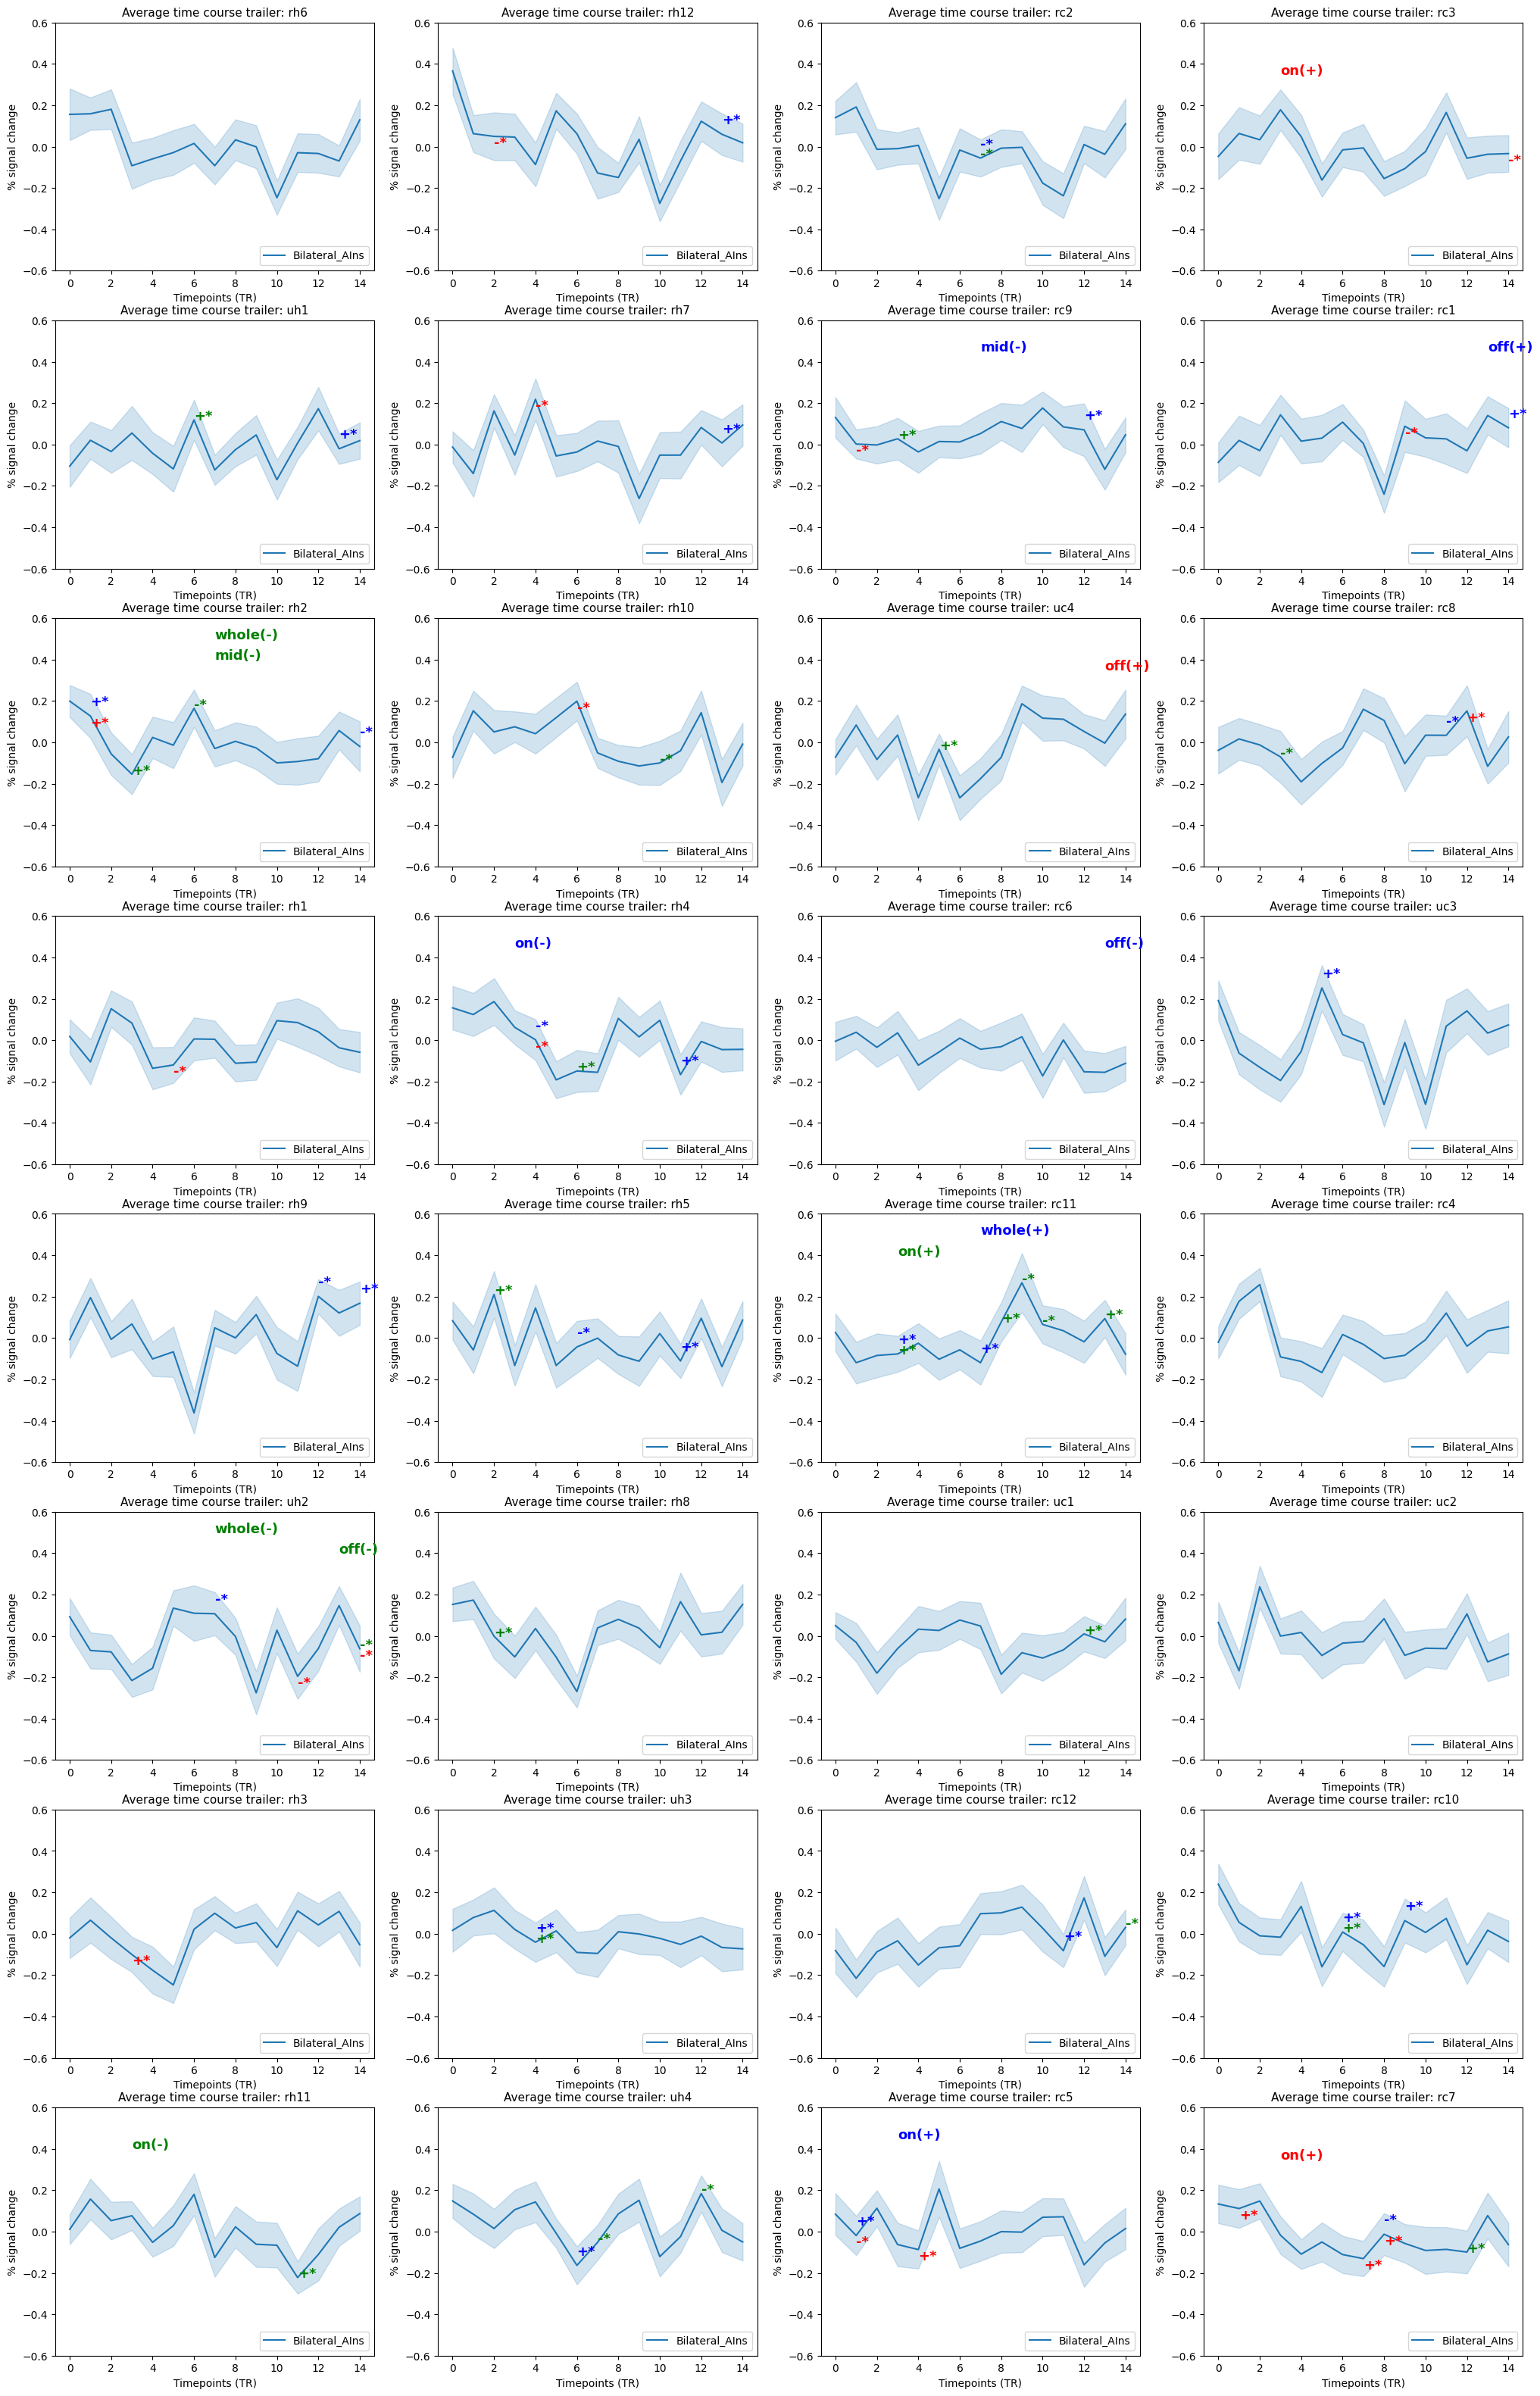

In [75]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "W_score", axs[id, 0])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Pos_arousal", axs[id, 0])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Neg_arousal", axs[id, 0])

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "W_score", axs[id, 1])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Pos_arousal", axs[id, 1])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Neg_arousal", axs[id, 1])
    runner +=1

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "W_score", axs[id, 2])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Pos_arousal", axs[id, 2])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r1_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Neg_arousal", axs[id, 2])

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 3], errorbar="se")
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "W_score", axs[id, 3])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Pos_arousal", axs[id, 3])
    plot_trailer_correlations(all_subjects_AIns_timecourse_df, r2_keys_sorted[runner], "Bilateral_AIns", AIns_TR_correlations, "Neg_arousal", axs[id, 3])
    runner +=1

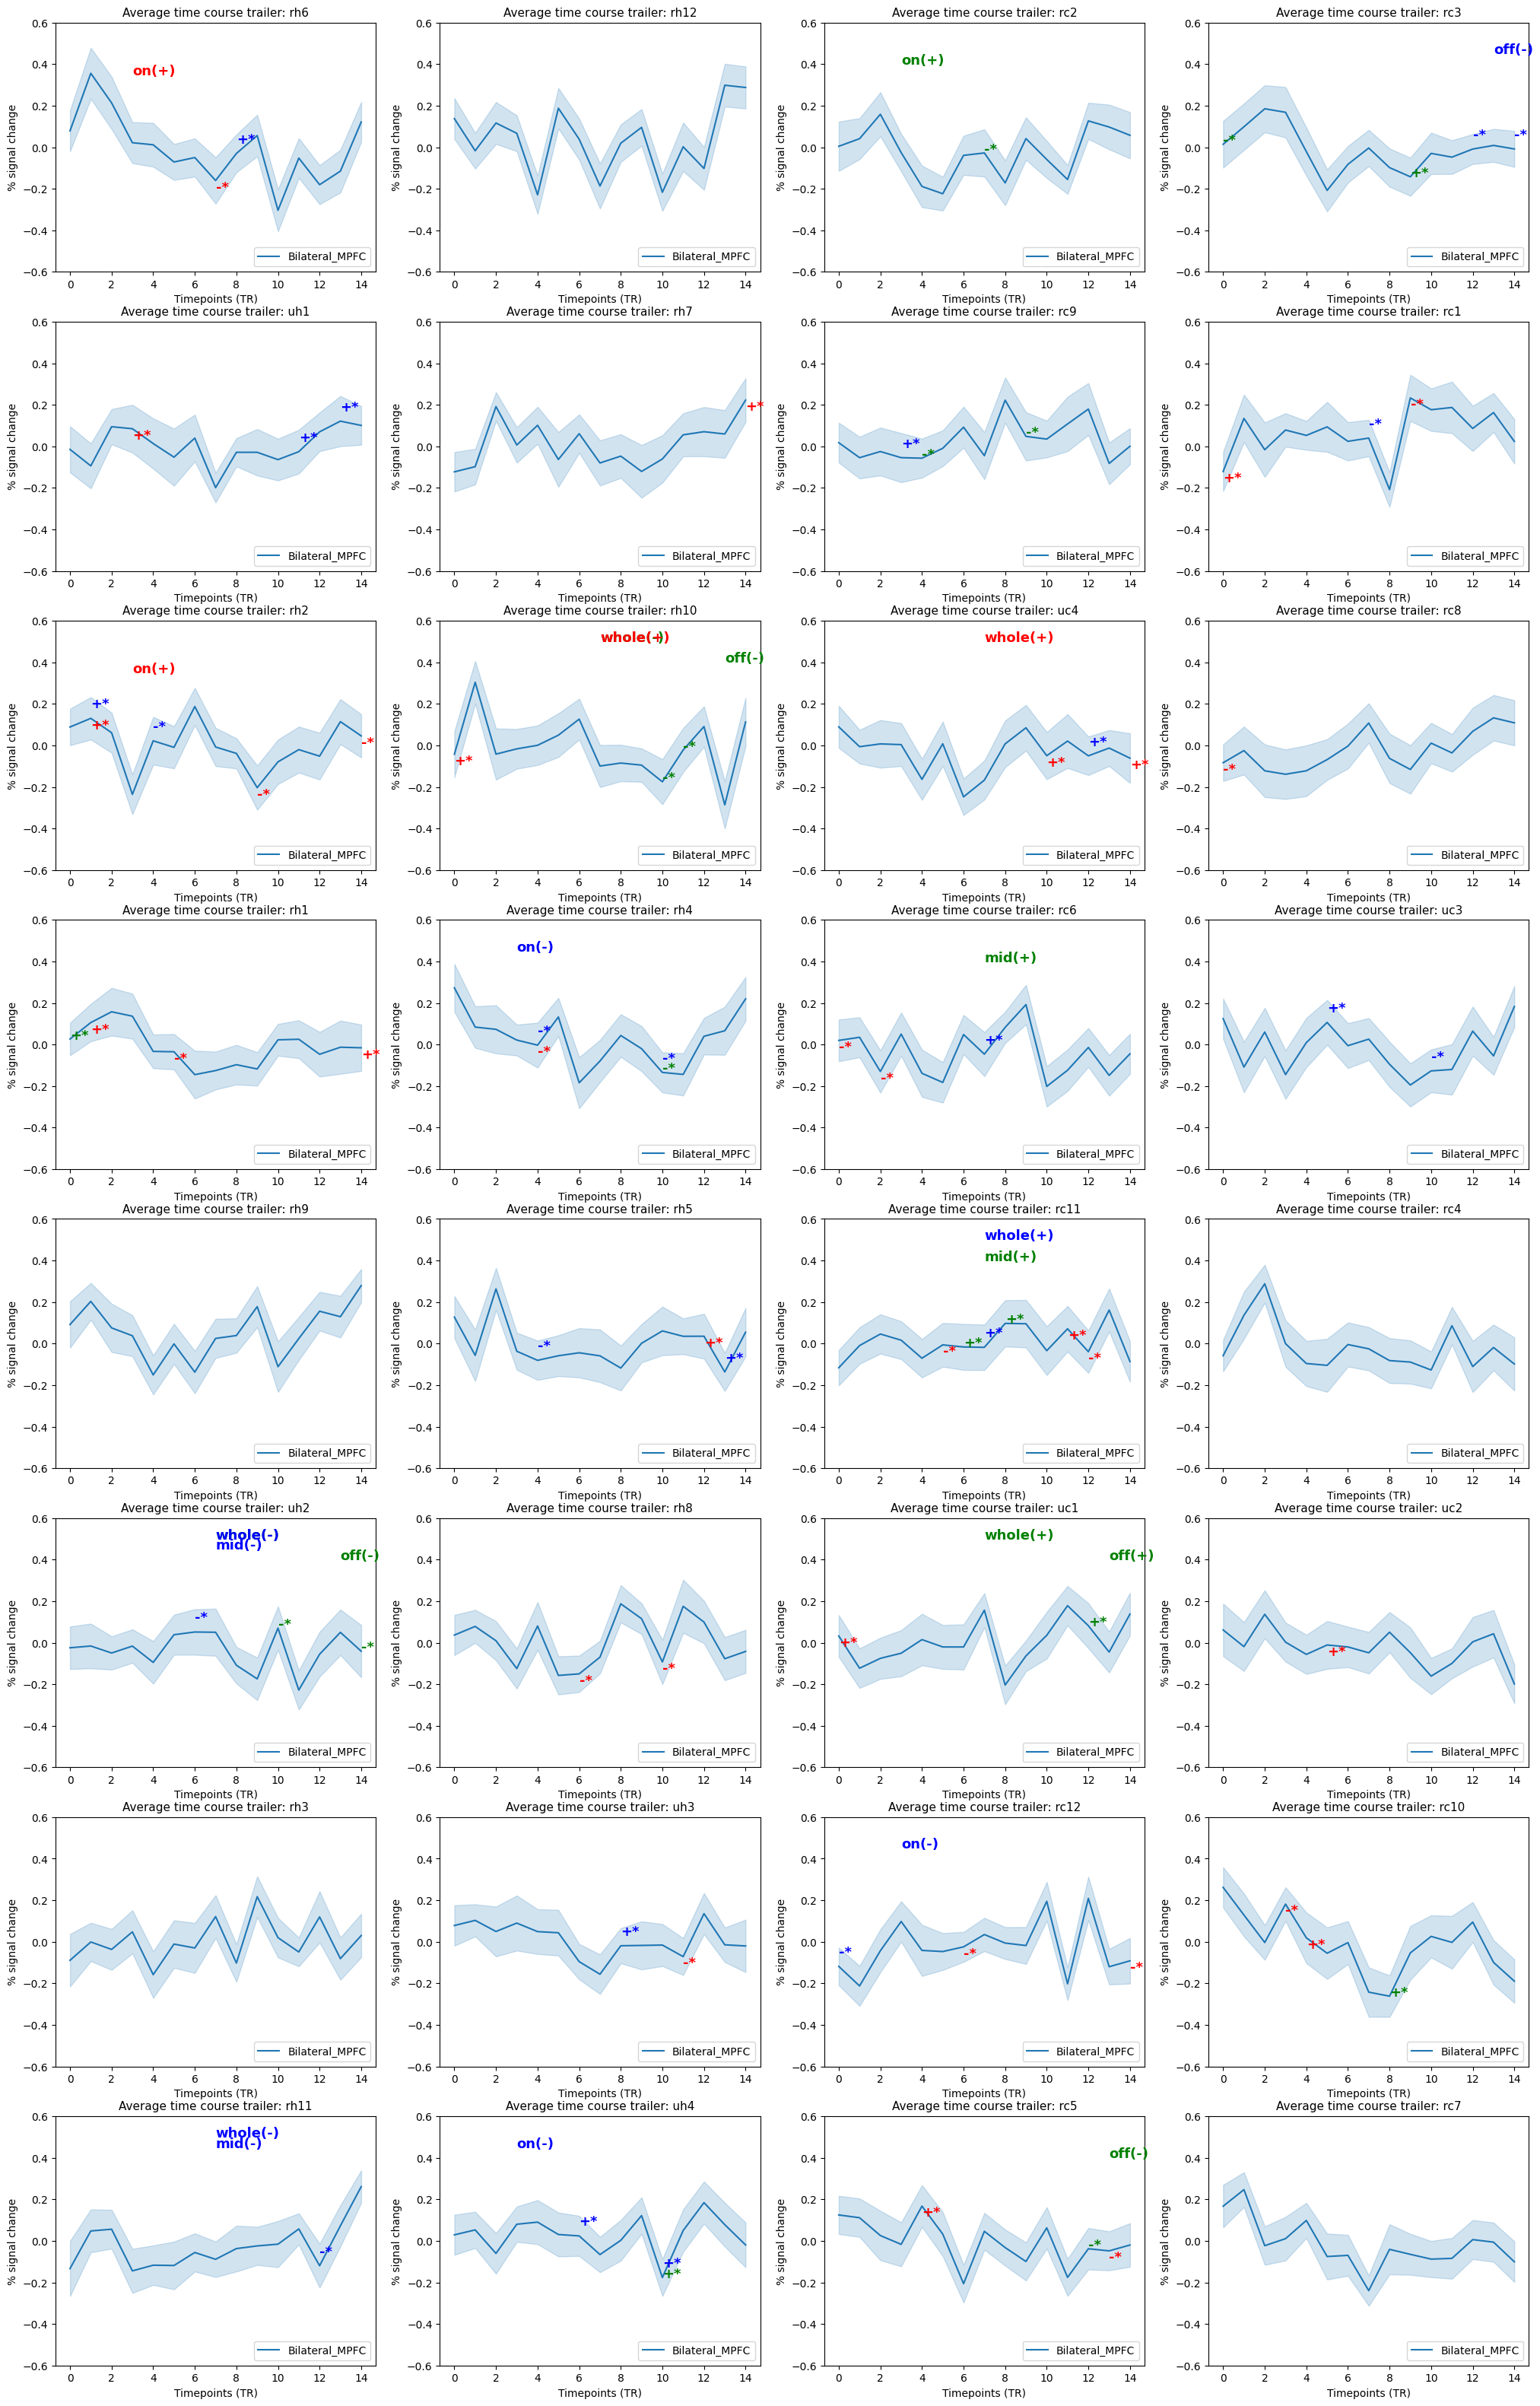

In [76]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "W_score", axs[id, 0])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Pos_arousal", axs[id, 0])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Neg_arousal", axs[id, 0])

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "W_score", axs[id, 1])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Pos_arousal", axs[id, 1])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Neg_arousal", axs[id, 1])
    runner +=1

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "W_score", axs[id, 2])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Pos_arousal", axs[id, 2])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r1_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Neg_arousal", axs[id, 2])

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 3], errorbar="se") 
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.6, .6)
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "W_score", axs[id, 3])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Pos_arousal", axs[id, 3])
    plot_trailer_correlations(all_subjects_MPFC_timecourse_df, r2_keys_sorted[runner], "Bilateral_MPFC", MPFC_TR_correlations, "Neg_arousal", axs[id, 3])
    runner +=1

In [77]:
# Save each participants timecourse data and processed events to a csv files.

save_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/"

for id_participant in range(len(particpants_list)):
    
    current_sub = "sub-" + particpants_list[id_participant]
    print("Processing and saving files for : "  + current_sub)

    participants_events[current_sub].to_csv(save_path + current_sub + "/" + current_sub + "_processed_events.csv", index=False)

    # Create empty dataframe for current participant.
    current_participant_df = pd.DataFrame(columns=["Participant"], data=np.repeat(current_sub, 15))

    # Current participant trailer keys.
    current_sub_trailer_keys = participants_events[current_sub]["Trailer"].unique()

    for id_trailer in current_sub_trailer_keys:

        col_label_NAcc = id_trailer + "_bNAcc"
        col_lable_AIns = id_trailer + "_bAIns"
        col_lable_MPFC = id_trailer + "_bMPFC"
            
        current_participant_df[col_label_NAcc] = participant_dictionaries[current_sub][id_trailer]["Bilateral_NAcc"]
        current_participant_df[col_lable_AIns] = participant_dictionaries[current_sub][id_trailer]["Bilateral_AIns"]
        current_participant_df[col_lable_MPFC] = participant_dictionaries[current_sub][id_trailer]["Bilateral_MPFC"]
    
    current_participant_df.to_csv(save_path + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv", index=False)


Processing and saving files for : sub-01
Processing and saving files for : sub-02
Processing and saving files for : sub-03
Processing and saving files for : sub-04
Processing and saving files for : sub-08
Processing and saving files for : sub-09
Processing and saving files for : sub-10


Processing and saving files for : sub-11
Processing and saving files for : sub-12
Processing and saving files for : sub-13
Processing and saving files for : sub-14
Processing and saving files for : sub-15
Processing and saving files for : sub-17
Processing and saving files for : sub-18
Processing and saving files for : sub-19
Processing and saving files for : sub-21
Processing and saving files for : sub-22
Processing and saving files for : sub-23
Processing and saving files for : sub-25
Processing and saving files for : sub-26
Processing and saving files for : sub-27
Processing and saving files for : sub-28
Processing and saving files for : sub-29
Processing and saving files for : sub-30
Processing and saving files for : sub-31
Processing and saving files for : sub-32
Processing and saving files for : sub-33
Processing and saving files for : sub-34
Processing and saving files for : sub-35
Processing and saving files for : sub-36
Processing and saving files for : sub-37


# Process all participants data

In [78]:
# Open a datasets directory. 
fd = os.open("/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

root_path = os.getcwd()

Current working dir : /Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData


In [79]:
all_cols = ['Participant', 'Trailer', 'Type', 'W_score', 'A_score',
       'F_score']

all_subs_events_df = pd.DataFrame(columns = all_cols)

#particpants_list = ["01", "02", "03", "04", "08", "09", "10", "11", "12", "13", "17", "18"]
# particpants_list = ["01", "02", "03", "04", "07", "08", "09", "10", "11", "12", "13", "15",
#                     "16", "17", "18", "19", "21", "22", "23", "25", "26", "27", "28", "29",
#                     "30", "31", "32", "33", "34", "35", "36", "37"]


# Loop through each participant's data.
for sub_num in particpants_list:

    current_sub = str("sub-" + sub_num)
    current_sub_events_path = root_path + "/" + current_sub + "/" + current_sub + "_processed_events.csv"
    current_sub_AIM_path = root_path + "/" + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv"

    current_sub_events_df = pd.read_csv(current_sub_events_path)
    current_sub_AIM_df = pd.read_csv(current_sub_AIM_path)
    current_sub_zscored_dict = participant_dictionaries_zscored[current_sub]
    current_sub_dic = participant_dictionaries[current_sub]

    current_sub_clean_df = pd.DataFrame() 

    trailer_keys = current_sub_events_df["Trailer"].unique().tolist()

    # Create empty lists to store the mean onset, middle, offset, and whole activation for each ROI.
    current_sub_clean_df["NAcc_onset"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_onset"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_onset"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_middle"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_middle"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_middle"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_offset"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_offset"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_offset"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_whole"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_whole"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_whole"] = np.zeros(len(trailer_keys))

    # Create empty lists to store the mean onset, middle, offset, and whole activation for each ROI.
    current_sub_clean_df["NAcc_onset_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_onset_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_onset_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_middle_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_middle_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_middle_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_offset_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_offset_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_offset_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_whole_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_whole_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_whole_z"] = np.zeros(len(trailer_keys))

    # Create empty list to store 5 segments of the timecourse for each ROI.
    current_sub_clean_df["NAcc_seg1"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg1"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg1"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg2"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg3"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg3"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg3"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg4"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg4"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg4"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg5"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg5"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg5"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg1_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg1_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg1_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg2_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg2_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg2_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg3_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg3_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg3_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg4_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg4_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg4_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_seg5_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_seg5_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_seg5_z"] = np.zeros(len(trailer_keys))

    # Create empty lists to store the ratings segments and whole activation for each ROI.
    current_sub_clean_df["NAcc_watch"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_watch"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_watch"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_feel"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_feel"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_feel"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_arousal"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_arousal"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_arousal"] = np.zeros(len(trailer_keys))

    # Create empty lists to store max signal for each ROI.

    current_sub_clean_df["NAcc_ind_peaks_pos"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_ind_peaks_pos_id"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_ind_peaks_pos_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_ind_peaks_pos2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_ind_peaks_pos_id2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_ind_peaks_pos_2z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["AIns_ind_peaks_pos"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_ind_peaks_pos_id"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_ind_peaks_pos_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["AIns_ind_peaks_pos2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_ind_peaks_pos_id2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_ind_peaks_pos_2z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["MPFC_ind_peaks_pos"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_ind_peaks_pos_id"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_ind_peaks_pos_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["MPFC_ind_peaks_pos2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_ind_peaks_pos_id2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_ind_peaks_pos_2z"] = np.zeros(len(trailer_keys))

    # Create empty lists to store individual TRs for each ROI.
    current_sub_clean_df["NAcc_TR1"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR3"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR4"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR5"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR6"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR7"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR8"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR9"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR10"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR11"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR12"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR13"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR14"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR15"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["NAcc_TR1_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR2_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR3_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR4_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR5_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR6_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR7_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR8_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR9_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR10_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR11_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR12_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR13_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR14_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["NAcc_TR15_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["AIns_TR1"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR3"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR4"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR5"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR6"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR7"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR8"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR9"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR10"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR11"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR12"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR13"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR14"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR15"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["AIns_TR1_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR2_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR3_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR4_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR5_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR6_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR7_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR8_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR9_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR10_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR11_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR12_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR13_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR14_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["AIns_TR15_z"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["MPFC_TR1"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR2"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR3"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR4"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR5"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR6"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR7"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR8"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR9"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR10"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR11"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR12"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR13"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR14"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR15"] = np.zeros(len(trailer_keys))

    current_sub_clean_df["MPFC_TR1_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR2_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR3_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR4_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR5_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR6_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR7_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR8_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR9_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR10_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR11_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR12_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR13_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR14_z"] = np.zeros(len(trailer_keys))
    current_sub_clean_df["MPFC_TR15_z"] = np.zeros(len(trailer_keys))

    # Loop through each trailer. 
    for id_trailer in range(len(trailer_keys)):

        trailer_key = trailer_keys[id_trailer]

        # Create keys to access AIM_df columns.
        NAcc_timeseries = participant_dictionaries[current_sub][trailer_key]["Bilateral_NAcc"]
        AIns_timeseries = participant_dictionaries[current_sub][trailer_key]["Bilateral_AIns"]
        MPFC_timeseries = participant_dictionaries[current_sub][trailer_key]["Bilateral_MPFC"]

        NAcc_timeseries_z = participant_dictionaries_zscored[current_sub][trailer_key]["Bilateral_NAcc_zscored"]
        AIns_timeseries_z = participant_dictionaries_zscored[current_sub][trailer_key]["Bilateral_AIns_zscored"]
        MPFC_timeseries_z = participant_dictionaries_zscored[current_sub][trailer_key]["Bilateral_MPFC_zscored"]

        # Calculate ROI mean onset (1-5 TRs) activation for each trailer. 
        # And append to the corresponding list.
        current_sub_clean_df["NAcc_onset"][id_trailer] = np.nanmean(NAcc_timeseries[0:5])
        current_sub_clean_df["AIns_onset"][id_trailer] = np.nanmean(AIns_timeseries[0:5])
        current_sub_clean_df["MPFC_onset"][id_trailer] = np.nanmean(MPFC_timeseries[0:5])

        current_sub_clean_df["NAcc_onset_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[0:5])
        current_sub_clean_df["AIns_onset_z"][id_trailer] = np.nanmean(AIns_timeseries_z[0:5])
        current_sub_clean_df["MPFC_onset_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[0:5])

        # Calculate ROI mean middle (6-10 TRs) activation for each trailer.
        current_sub_clean_df["NAcc_middle"][id_trailer] = np.nanmean(NAcc_timeseries[5:10])
        current_sub_clean_df["AIns_middle"][id_trailer] = np.nanmean(AIns_timeseries[5:10])
        current_sub_clean_df["MPFC_middle"][id_trailer] = np.nanmean(MPFC_timeseries[5:10])

        current_sub_clean_df["NAcc_middle_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[5:10])
        current_sub_clean_df["AIns_middle_z"][id_trailer] = np.nanmean(AIns_timeseries_z[5:10])
        current_sub_clean_df["MPFC_middle_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[5:10])

        # Calculate ROI mean offset (11-15 TRs) activation for each trailer.
        current_sub_clean_df["NAcc_offset"][id_trailer] = np.nanmean(NAcc_timeseries[10:])
        current_sub_clean_df["AIns_offset"][id_trailer] = np.nanmean(AIns_timeseries[10:])
        current_sub_clean_df["MPFC_offset"][id_trailer] = np.nanmean(MPFC_timeseries[10:])

        current_sub_clean_df["NAcc_offset_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[10:])
        current_sub_clean_df["AIns_offset_z"][id_trailer] = np.nanmean(AIns_timeseries_z[10:])
        current_sub_clean_df["MPFC_offset_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[10:])

        # Calculate ROI mean whole activation for each trailer.
        current_sub_clean_df["NAcc_whole"][id_trailer] = np.nanmean(NAcc_timeseries)
        current_sub_clean_df["AIns_whole"][id_trailer] = np.nanmean(AIns_timeseries)
        current_sub_clean_df["MPFC_whole"][id_trailer] = np.nanmean(MPFC_timeseries)

        current_sub_clean_df["NAcc_whole_z"][id_trailer] = np.nanmean(NAcc_timeseries_z)
        current_sub_clean_df["AIns_whole_z"][id_trailer] = np.nanmean(AIns_timeseries_z)
        current_sub_clean_df["MPFC_whole_z"][id_trailer] = np.nanmean(MPFC_timeseries_z)

        # Calculate segments for each ROI.

        current_sub_clean_df["NAcc_seg1"][id_trailer] = np.nanmean(NAcc_timeseries[0:3])
        current_sub_clean_df["AIns_seg1"][id_trailer] = np.nanmean(AIns_timeseries[0:3])
        current_sub_clean_df["MPFC_seg1"][id_trailer] = np.nanmean(MPFC_timeseries[0:3])

        current_sub_clean_df["NAcc_seg2"][id_trailer] = np.nanmean(NAcc_timeseries[3:6])
        current_sub_clean_df["AIns_seg2"][id_trailer] = np.nanmean(AIns_timeseries[3:6])
        current_sub_clean_df["MPFC_seg2"][id_trailer] = np.nanmean(MPFC_timeseries[3:6])

        current_sub_clean_df["NAcc_seg3"][id_trailer] = np.nanmean(NAcc_timeseries[6:9])
        current_sub_clean_df["AIns_seg3"][id_trailer] = np.nanmean(AIns_timeseries[6:9])
        current_sub_clean_df["MPFC_seg3"][id_trailer] = np.nanmean(MPFC_timeseries[6:9])

        current_sub_clean_df["NAcc_seg4"][id_trailer] = np.nanmean(NAcc_timeseries[9:12])
        current_sub_clean_df["AIns_seg4"][id_trailer] = np.nanmean(AIns_timeseries[9:12])
        current_sub_clean_df["MPFC_seg4"][id_trailer] = np.nanmean(MPFC_timeseries[9:12])

        current_sub_clean_df["NAcc_seg5"][id_trailer] = np.nanmean(NAcc_timeseries[12:15])
        current_sub_clean_df["AIns_seg5"][id_trailer] = np.nanmean(AIns_timeseries[12:15])
        current_sub_clean_df["MPFC_seg5"][id_trailer] = np.nanmean(MPFC_timeseries[12:15])

        current_sub_clean_df["NAcc_seg1_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[0:3])
        current_sub_clean_df["AIns_seg1_z"][id_trailer] = np.nanmean(AIns_timeseries_z[0:3])
        current_sub_clean_df["MPFC_seg1_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[0:3])

        current_sub_clean_df["NAcc_seg2_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[3:6])
        current_sub_clean_df["AIns_seg2_z"][id_trailer] = np.nanmean(AIns_timeseries_z[3:6])
        current_sub_clean_df["MPFC_seg2_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[3:6])

        current_sub_clean_df["NAcc_seg3_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[6:9])
        current_sub_clean_df["AIns_seg3_z"][id_trailer] = np.nanmean(AIns_timeseries_z[6:9])
        current_sub_clean_df["MPFC_seg3_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[6:9])

        current_sub_clean_df["NAcc_seg4_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[9:12])
        current_sub_clean_df["AIns_seg4_z"][id_trailer] = np.nanmean(AIns_timeseries_z[9:12])
        current_sub_clean_df["MPFC_seg4_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[9:12])

        current_sub_clean_df["NAcc_seg5_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[12:15])
        current_sub_clean_df["AIns_seg5_z"][id_trailer] = np.nanmean(AIns_timeseries_z[12:15])
        current_sub_clean_df["MPFC_seg5_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[12:15])

        # Calculate ratings segments and whole activation for each ROI.

        current_sub_clean_df["NAcc_watch"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_NAcc_watch'])
        current_sub_clean_df["AIns_watch"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_AIns_watch'])
        current_sub_clean_df["MPFC_watch"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_MPFC_watch'])

        current_sub_clean_df["NAcc_feel"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_NAcc_feel'])
        current_sub_clean_df["AIns_feel"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_AIns_feel'])
        current_sub_clean_df["MPFC_feel"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_MPFC_feel'])

        current_sub_clean_df["NAcc_arousal"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_NAcc_arousal'])
        current_sub_clean_df["AIns_arousal"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_AIns_arousal'])
        current_sub_clean_df["MPFC_arousal"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_MPFC_arousal'])

        # Calculate individual peaks for each ROI.
        current_sub_clean_df["NAcc_ind_peaks_pos"][id_trailer] = np.nanmax(NAcc_timeseries) 
        current_sub_clean_df["NAcc_ind_peaks_pos_id"][id_trailer] = np.argsort(NAcc_timeseries)[-1]
        current_sub_clean_df["NAcc_ind_peaks_pos_z"][id_trailer] = NAcc_timeseries_z[np.argsort(NAcc_timeseries)[-1]]

        current_sub_clean_df["NAcc_ind_peaks_pos2"][id_trailer] = np.sort(NAcc_timeseries)[-2]
        current_sub_clean_df["NAcc_ind_peaks_pos_id2"][id_trailer] = np.argsort(NAcc_timeseries)[-2]
        current_sub_clean_df["NAcc_ind_peaks_pos_2z"][id_trailer] = NAcc_timeseries_z[np.argsort(NAcc_timeseries)[-2]]

        current_sub_clean_df["AIns_ind_peaks_pos"][id_trailer] = np.nanmax(AIns_timeseries)
        current_sub_clean_df["AIns_ind_peaks_pos_id"][id_trailer] = np.argsort(AIns_timeseries)[-1]
        current_sub_clean_df["AIns_ind_peaks_pos_z"][id_trailer] = AIns_timeseries_z[np.argsort(AIns_timeseries)[-1]]

        current_sub_clean_df["AIns_ind_peaks_pos2"][id_trailer] = np.sort(AIns_timeseries)[-2]
        current_sub_clean_df["AIns_ind_peaks_pos_id2"][id_trailer] = np.argsort(AIns_timeseries)[-2]
        current_sub_clean_df["AIns_ind_peaks_pos_2z"][id_trailer] = AIns_timeseries_z[np.argsort(AIns_timeseries)[-2]]

        current_sub_clean_df["MPFC_ind_peaks_pos"][id_trailer] = np.nanmax(MPFC_timeseries)
        current_sub_clean_df["MPFC_ind_peaks_pos_id"][id_trailer] = np.argsort(MPFC_timeseries)[-1]
        current_sub_clean_df["MPFC_ind_peaks_pos_z"][id_trailer] = MPFC_timeseries_z[np.argsort(MPFC_timeseries)[-1]]

        current_sub_clean_df["MPFC_ind_peaks_pos2"][id_trailer] = np.sort(MPFC_timeseries)[-2]
        current_sub_clean_df["MPFC_ind_peaks_pos_id2"][id_trailer] = np.argsort(MPFC_timeseries)[-2]
        current_sub_clean_df["MPFC_ind_peaks_pos_2z"][id_trailer] = MPFC_timeseries_z[np.argsort(MPFC_timeseries)[-2]]

        # Calculate individual TRs for each ROI.
        current_sub_clean_df["NAcc_TR1"][id_trailer] = NAcc_timeseries[0]
        current_sub_clean_df["NAcc_TR2"][id_trailer] = NAcc_timeseries[1]
        current_sub_clean_df["NAcc_TR3"][id_trailer] = NAcc_timeseries[2]
        current_sub_clean_df["NAcc_TR4"][id_trailer] = NAcc_timeseries[3]
        current_sub_clean_df["NAcc_TR5"][id_trailer] = NAcc_timeseries[4]
        current_sub_clean_df["NAcc_TR6"][id_trailer] = NAcc_timeseries[5]
        current_sub_clean_df["NAcc_TR7"][id_trailer] = NAcc_timeseries[6]
        current_sub_clean_df["NAcc_TR8"][id_trailer] = NAcc_timeseries[7]
        current_sub_clean_df["NAcc_TR9"][id_trailer] = NAcc_timeseries[8]
        current_sub_clean_df["NAcc_TR10"][id_trailer] = NAcc_timeseries[9]
        current_sub_clean_df["NAcc_TR11"][id_trailer] = NAcc_timeseries[10]
        current_sub_clean_df["NAcc_TR12"][id_trailer] = NAcc_timeseries[11]
        current_sub_clean_df["NAcc_TR13"][id_trailer] = NAcc_timeseries[12]
        current_sub_clean_df["NAcc_TR14"][id_trailer] = NAcc_timeseries[13]
        current_sub_clean_df["NAcc_TR15"][id_trailer] = NAcc_timeseries[14]
        
        current_sub_clean_df["NAcc_TR1_z"][id_trailer] = NAcc_timeseries_z[0]
        current_sub_clean_df["NAcc_TR2_z"][id_trailer] = NAcc_timeseries_z[1]
        current_sub_clean_df["NAcc_TR3_z"][id_trailer] = NAcc_timeseries_z[2]
        current_sub_clean_df["NAcc_TR4_z"][id_trailer] = NAcc_timeseries_z[3]
        current_sub_clean_df["NAcc_TR5_z"][id_trailer] = NAcc_timeseries_z[4]
        current_sub_clean_df["NAcc_TR6_z"][id_trailer] = NAcc_timeseries_z[5]
        current_sub_clean_df["NAcc_TR7_z"][id_trailer] = NAcc_timeseries_z[6]
        current_sub_clean_df["NAcc_TR8_z"][id_trailer] = NAcc_timeseries_z[7]
        current_sub_clean_df["NAcc_TR9_z"][id_trailer] = NAcc_timeseries_z[8]
        current_sub_clean_df["NAcc_TR10_z"][id_trailer] = NAcc_timeseries_z[9]
        current_sub_clean_df["NAcc_TR11_z"][id_trailer] = NAcc_timeseries_z[10]
        current_sub_clean_df["NAcc_TR12_z"][id_trailer] = NAcc_timeseries_z[11]
        current_sub_clean_df["NAcc_TR13_z"][id_trailer] = NAcc_timeseries_z[12]
        current_sub_clean_df["NAcc_TR14_z"][id_trailer] = NAcc_timeseries_z[13]
        current_sub_clean_df["NAcc_TR15_z"][id_trailer] = NAcc_timeseries_z[14]

        current_sub_clean_df["AIns_TR1"][id_trailer] = AIns_timeseries[0]
        current_sub_clean_df["AIns_TR2"][id_trailer] = AIns_timeseries[1]
        current_sub_clean_df["AIns_TR3"][id_trailer] = AIns_timeseries[2]
        current_sub_clean_df["AIns_TR4"][id_trailer] = AIns_timeseries[3]
        current_sub_clean_df["AIns_TR5"][id_trailer] = AIns_timeseries[4]
        current_sub_clean_df["AIns_TR6"][id_trailer] = AIns_timeseries[5]
        current_sub_clean_df["AIns_TR7"][id_trailer] = AIns_timeseries[6]
        current_sub_clean_df["AIns_TR8"][id_trailer] = AIns_timeseries[7]
        current_sub_clean_df["AIns_TR9"][id_trailer] = AIns_timeseries[8]
        current_sub_clean_df["AIns_TR10"][id_trailer] = AIns_timeseries[9]
        current_sub_clean_df["AIns_TR11"][id_trailer] = AIns_timeseries[10]
        current_sub_clean_df["AIns_TR12"][id_trailer] = AIns_timeseries[11]
        current_sub_clean_df["AIns_TR13"][id_trailer] = AIns_timeseries[12]
        current_sub_clean_df["AIns_TR14"][id_trailer] = AIns_timeseries[13]
        current_sub_clean_df["AIns_TR15"][id_trailer] = AIns_timeseries[14]

        current_sub_clean_df["AIns_TR1_z"][id_trailer] = AIns_timeseries_z[0]
        current_sub_clean_df["AIns_TR2_z"][id_trailer] = AIns_timeseries_z[1]
        current_sub_clean_df["AIns_TR3_z"][id_trailer] = AIns_timeseries_z[2]
        current_sub_clean_df["AIns_TR4_z"][id_trailer] = AIns_timeseries_z[3]
        current_sub_clean_df["AIns_TR5_z"][id_trailer] = AIns_timeseries_z[4]
        current_sub_clean_df["AIns_TR6_z"][id_trailer] = AIns_timeseries_z[5]
        current_sub_clean_df["AIns_TR7_z"][id_trailer] = AIns_timeseries_z[6]
        current_sub_clean_df["AIns_TR8_z"][id_trailer] = AIns_timeseries_z[7]
        current_sub_clean_df["AIns_TR9_z"][id_trailer] = AIns_timeseries_z[8]
        current_sub_clean_df["AIns_TR10_z"][id_trailer] = AIns_timeseries_z[9]
        current_sub_clean_df["AIns_TR11_z"][id_trailer] = AIns_timeseries_z[10]
        current_sub_clean_df["AIns_TR12_z"][id_trailer] = AIns_timeseries_z[11]
        current_sub_clean_df["AIns_TR13_z"][id_trailer] = AIns_timeseries_z[12]
        current_sub_clean_df["AIns_TR14_z"][id_trailer] = AIns_timeseries_z[13]
        current_sub_clean_df["AIns_TR15_z"][id_trailer] = AIns_timeseries_z[14]

        current_sub_clean_df["MPFC_TR1"][id_trailer] = MPFC_timeseries[0]
        current_sub_clean_df["MPFC_TR2"][id_trailer] = MPFC_timeseries[1]
        current_sub_clean_df["MPFC_TR3"][id_trailer] = MPFC_timeseries[2]
        current_sub_clean_df["MPFC_TR4"][id_trailer] = MPFC_timeseries[3]
        current_sub_clean_df["MPFC_TR5"][id_trailer] = MPFC_timeseries[4]
        current_sub_clean_df["MPFC_TR6"][id_trailer] = MPFC_timeseries[5]
        current_sub_clean_df["MPFC_TR7"][id_trailer] = MPFC_timeseries[6]
        current_sub_clean_df["MPFC_TR8"][id_trailer] = MPFC_timeseries[7]
        current_sub_clean_df["MPFC_TR9"][id_trailer] = MPFC_timeseries[8]
        current_sub_clean_df["MPFC_TR10"][id_trailer] = MPFC_timeseries[9]
        current_sub_clean_df["MPFC_TR11"][id_trailer] = MPFC_timeseries[10]
        current_sub_clean_df["MPFC_TR12"][id_trailer] = MPFC_timeseries[11]
        current_sub_clean_df["MPFC_TR13"][id_trailer] = MPFC_timeseries[12]
        current_sub_clean_df["MPFC_TR14"][id_trailer] = MPFC_timeseries[13]
        current_sub_clean_df["MPFC_TR15"][id_trailer] = MPFC_timeseries[14]

        current_sub_clean_df["MPFC_TR1_z"][id_trailer] = MPFC_timeseries_z[0]
        current_sub_clean_df["MPFC_TR2_z"][id_trailer] = MPFC_timeseries_z[1]
        current_sub_clean_df["MPFC_TR3_z"][id_trailer] = MPFC_timeseries_z[2]
        current_sub_clean_df["MPFC_TR4_z"][id_trailer] = MPFC_timeseries_z[3]
        current_sub_clean_df["MPFC_TR5_z"][id_trailer] = MPFC_timeseries_z[4]
        current_sub_clean_df["MPFC_TR6_z"][id_trailer] = MPFC_timeseries_z[5]
        current_sub_clean_df["MPFC_TR7_z"][id_trailer] = MPFC_timeseries_z[6]
        current_sub_clean_df["MPFC_TR8_z"][id_trailer] = MPFC_timeseries_z[7]
        current_sub_clean_df["MPFC_TR9_z"][id_trailer] = MPFC_timeseries_z[8]
        current_sub_clean_df["MPFC_TR10_z"][id_trailer] = MPFC_timeseries_z[9]
        current_sub_clean_df["MPFC_TR11_z"][id_trailer] = MPFC_timeseries_z[10]
        current_sub_clean_df["MPFC_TR12_z"][id_trailer] = MPFC_timeseries_z[11]
        current_sub_clean_df["MPFC_TR13_z"][id_trailer] = MPFC_timeseries_z[12]
        current_sub_clean_df["MPFC_TR14_z"][id_trailer] = MPFC_timeseries_z[13]
        current_sub_clean_df["MPFC_TR15_z"][id_trailer] = MPFC_timeseries_z[14]

        # Calculate individual peaks for each ROI.

    # Add id and rating info.
    current_sub_clean_df["Participant"] = np.repeat(current_sub_AIM_df["Participant"][0], len(trailer_keys))
    current_sub_clean_df["Trailer"] = trailer_keys
    current_sub_clean_df["Type"] = "Horror" if 'h' in current_sub_events_df["Trailer"] else "Comedy"
    current_sub_clean_df["W_score"] = current_sub_events_df["W_score"]
    current_sub_clean_df["A_score"] = current_sub_events_df["A_score"]
    current_sub_clean_df["F_score"] = current_sub_events_df["F_score"]
    current_sub_clean_df["W_score_scaled"] = current_sub_events_df["W_score_scaled"]
    current_sub_clean_df["A_score_scaled"] = current_sub_events_df["A_score"] - current_sub_events_df["A_score"].mean()
    current_sub_clean_df["F_score_scaled"] = current_sub_events_df["F_score"] - current_sub_events_df["F_score"].mean()
    current_sub_clean_df["Pos_arousal"] = current_sub_events_df["Pos_arousal"]
    current_sub_clean_df["Neg_arousal"] = current_sub_events_df["Neg_arousal"]
    current_sub_clean_df["Pos_arousal_scaled"] = current_sub_events_df["Pos_arousal_scaled"]
    current_sub_clean_df["Neg_arousal_scaled"] = current_sub_events_df["Neg_arousal_scaled"]
    
    # Append the current_sub_events_df to the all_subs_events_df.
    all_subs_events_df = pd.concat([all_subs_events_df, current_sub_clean_df], ignore_index=True)

# Drop columns with scores missing. 
drop_id = all_subs_events_df[(all_subs_events_df["W_score"] == 0) | (all_subs_events_df["A_score"] == 0) | (all_subs_events_df["F_score"] == 0)]
print("Okay, we are dropping the following missed trials: ", drop_id.shape)
all_subs_events_df.drop(drop_id.index, inplace=True)
all_subs_events_df.reset_index(drop=True, inplace=True)
all_subs_events_df.to_csv(root_path + "/AllSubs_NeuralActivation.csv", index=False)
all_subs_events_df.head(40)



Okay, we are dropping the following missed trials:  (17, 184)


Participant Trailer    Type W_score A_score F_score  NAcc_onset  \
0       sub-01     rh6  Comedy       3       3       2   -0.227792   
1       sub-01     uh1  Comedy       1       3       3    0.117741   
2       sub-01     rc2  Comedy       1       1       3   -0.262913   
3       sub-01     rh2  Comedy       3       2       2   -0.263180   
4       sub-01     rh1  Comedy       4       3       2    0.041612   
5       sub-01     rc9  Comedy       4       4       4    0.451256   
6       sub-01     uc4  Comedy       3       2       4   -0.355534   
7       sub-01     rh9  Comedy       2       2       2   -0.074244   
8       sub-01     uh2  Comedy       4       3       1    0.519966   
9       sub-01     rc6  Comedy       1       1       3   -0.114466   
10      sub-01     rh3  Comedy       2       2       2    0.289991   
11      sub-01    rc11  Comedy       1       1       3    0.209283   
12      sub-01     uc1  Comedy       2       2       3   -0.155285   
13      sub-01    rh11  Comedy       1       3       1    0.249029   
14      sub-01    rc12  Comedy       3       2       4    0.080378   
15      sub-01     rc5  Comedy       2       3       4    0.155593   
16      sub-01     rc3  Comedy       3       2       4    0.318670   
17      sub-01    rh12  Comedy       3       4       1   -0.297928   
18      sub-01     rc1  Comedy       2       2       3   -0.029948   
19      sub-01     rh7  Comedy       1       2       1   -0.377440   
20      sub-01     rc8  Comedy       2       2       4    0.444932   
21      sub-01     uc3  Comedy       4       3       3   -0.007209   
22      sub-01    rh10  Comedy       1       4       1    0.041676   
23      sub-01     rc4  Comedy       4       3       4   -0.304636   
24      sub-01     rh4  Comedy       3       3       1    0.538393   
25      sub-01     uc2  Comedy       2       2       3    0.315587   
26      sub-01     rh5  Comedy       2       4       1   -0.783115   
27      sub-01     rh8  Comedy       1       4       1   -0.066814   
28      sub-01    rc10  Comedy       4       4       4    0.394679   
29      sub-01     uh3  Comedy       4       4       1    0.057120   
30      sub-01     rc7  Comedy       2       1       4   -0.326125   
31      sub-01     uh4  Comedy       3       3       1    0.427720   
32      sub-02     rh6  Comedy       1       2       1    0.188788   
33      sub-02     uh1  Comedy       2       3       2   -0.164129   
34      sub-02     rc2  Comedy       2       2       4   -0.429755   
35      sub-02     rh2  Comedy       2       3       2    0.173360   
36      sub-02     rh1  Comedy       1       1       2    0.125019   
37      sub-02     rc9  Comedy       3       2       3   -0.141002   
38      sub-02     uc4  Comedy       2       2       4    0.106168   
39      sub-02     rh9  Comedy       2       1       3   -0.173272   

    AIns_onset  MPFC_onset  NAcc_middle  ...  MPFC_TR13_z  MPFC_TR14_z  \
0     0.383683    0.315547    -0.091079  ...     0.521805     0.228071   
1     0.144808   -0.049198    -0.267910  ...    -0.030167     0.657656   
2    -0.183234   -0.329774     0.483554  ...     0.314743    -0.083219   
3     0.255011    0.086995    -0.268453  ...    -0.386787    -0.047646   
4     0.197039    0.295143    -0.448427  ...    -0.087958     0.163077   
5     0.350207    0.464554     0.262969  ...     0.054316    -0.118504   
6    -0.647864   -0.377862    -0.287651  ...     0.470963     0.216058   
7     0.050524    0.307135     0.174860  ...    -0.287398    -0.163464   
8     0.088073    0.438241    -0.213730  ...    -0.258082    -0.266166   
9     0.093372   -0.274174     0.061732  ...    -0.028721    -1.681806   
10    0.344380    0.525572    -0.220069  ...    -0.051330     0.055223   
11   -0.648546   -0.071205    -0.132014  ...     0.626426     0.734662   
12    0.395021    0.176763     0.415091  ...    -0.341975     0.122042   
13   -0.003430   -0.089994     0.002445  ...     0.266883    -0.312237   
14    0.019554   -0.11

In [80]:
# Create column for binary choice to watch the trailer.
all_subs_events_df["Watch_choice"] = "No"
all_subs_events_df.loc[all_subs_events_df["W_score"] > 2, "Watch_choice"] = "Yes"

all_subs_events_watch_yes_df = all_subs_events_df[all_subs_events_df["Watch_choice"] == "Yes"]
all_subs_events_watch_no_df = all_subs_events_df[all_subs_events_df["Watch_choice"] == "No"]

# Calculate collective peaks. 
# Create empty dictionaries to store the peak location for each trailer.
r1_peaks_id = {}
r2_peaks_id = {}

# Loop through each trailer and get the location for where (for most participants) the peak occurs.
for trailer_id in range(len(r1_keys_sorted)):

    NAcc_peak_pos_label_r1 = r1_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc"    
    AIns_peak_pos_label_r1 = r1_keys_sorted[trailer_id] + "_AIns_dem_pos_loc"
    MPFC_peak_pos_label_r1 = r1_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc"

     # Using both peak id1 and id2. 
    NAcc_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id2"].to_numpy()]).flatten()
    AIns_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id2"].to_numpy()]).flatten()
    MPFC_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id2"].to_numpy()]).flatten()

    # Using only peak id1.
    #NAcc_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy()]).flatten()
    #AIns_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy()]).flatten()
    #MPFC_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy()]).flatten()

    r1_peaks_id[NAcc_peak_pos_label_r1] = st.mode(NAcc_array_ids_r1)[0]
    r1_peaks_id[AIns_peak_pos_label_r1] = st.mode(AIns_array_ids_r1)[0]
    r1_peaks_id[MPFC_peak_pos_label_r1] = st.mode(MPFC_array_ids_r1)[0]

    #r1_peaks_id[NAcc_peak_pos_label_r1] = all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    #r1_peaks_id[AIns_peak_pos_label_r1] = all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    #r1_peaks_id[MPFC_peak_pos_label_r1] = all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].value_counts(ascending=False).index[0]

    NAcc_peak_pos_label_r2 = r2_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc"
    AIns_peak_pos_label_r2 = r2_keys_sorted[trailer_id] + "_AIns_dem_pos_loc"
    MPFC_peak_pos_label_r2 = r2_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc"

    NAcc_array_ids_r2 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id2"].to_numpy()]).flatten()
    AIns_array_ids_r2 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id2"].to_numpy()]).flatten()
    MPFC_array_ids_r2 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id2"].to_numpy()]).flatten()

    r2_peaks_id[NAcc_peak_pos_label_r2] = st.mode(NAcc_array_ids_r2)[0]
    r2_peaks_id[AIns_peak_pos_label_r2] = st.mode(AIns_array_ids_r2)[0]
    r2_peaks_id[MPFC_peak_pos_label_r2] = st.mode(MPFC_array_ids_r2)[0]

    #r2_peaks_id[NAcc_peak_pos_label_r2] = all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    #r2_peaks_id[AIns_peak_pos_label_r2] = all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    #r2_peaks_id[MPFC_peak_pos_label_r2] = all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].value_counts(ascending=False).index[0]

    # Now, lets get the positive peaks from people that said watch yes.
    NAcc_peak_pos_label_r1_yes = r1_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc_yes"
    AIns_peak_pos_label_r1_yes = r1_keys_sorted[trailer_id] + "_AIns_dem_pos_loc_yes"
    MPFC_peak_pos_label_r1_yes = r1_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc_yes"

    NAcc_YES_array_ids_r1 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id2"].to_numpy()]).flatten()
    AIns_YES_array_ids_r1 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id2"].to_numpy()]).flatten()
    MPFC_YES_array_ids_r1 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id2"].to_numpy()]).flatten()

    r1_peaks_id[NAcc_peak_pos_label_r1_yes] = st.mode(NAcc_YES_array_ids_r1)[0]
    r1_peaks_id[AIns_peak_pos_label_r1_yes] = st.mode(AIns_YES_array_ids_r1)[0]
    r1_peaks_id[MPFC_peak_pos_label_r1_yes] = st.mode(MPFC_YES_array_ids_r1)[0]

    #r1_peaks_id[NAcc_peak_pos_label_r1_yes] = all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    #r1_peaks_id[AIns_peak_pos_label_r1_yes] = all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    #r1_peaks_id[MPFC_peak_pos_label_r1_yes] = all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].value_counts(ascending=False).index[0]

    NAcc_peak_pos_label_r2_yes = r2_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc_yes"
    AIns_peak_pos_label_r2_yes = r2_keys_sorted[trailer_id] + "_AIns_dem_pos_loc_yes"
    MPFC_peak_pos_label_r2_yes = r2_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc_yes"

    NAcc_YES_array_ids_r2 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id2"].to_numpy()]).flatten()
    AIns_YES_array_ids_r2 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id2"].to_numpy()]).flatten()
    MPFC_YES_array_ids_r2 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id2"].to_numpy()]).flatten()

    r2_peaks_id[NAcc_peak_pos_label_r2_yes] = st.mode(NAcc_YES_array_ids_r2)[0]
    r2_peaks_id[AIns_peak_pos_label_r2_yes] = st.mode(AIns_YES_array_ids_r2)[0]
    r2_peaks_id[MPFC_peak_pos_label_r2_yes] = st.mode(MPFC_YES_array_ids_r2)[0]

    #r2_peaks_id[NAcc_peak_pos_label_r2_yes] = all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    #r2_peaks_id[AIns_peak_pos_label_r2_yes] = all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    #r2_peaks_id[MPFC_peak_pos_label_r2_yes] = all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].value_counts(ascending=False).index[0]

    # Now, lets get the positive peaks from people that said watch no.
    NAcc_peak_pos_label_r1_no = r1_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc_no"
    AIns_peak_pos_label_r1_no = r1_keys_sorted[trailer_id] + "_AIns_dem_pos_loc_no"
    MPFC_peak_pos_label_r1_no = r1_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc_no"

    r1_peaks_id[NAcc_peak_pos_label_r1_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    r1_peaks_id[AIns_peak_pos_label_r1_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    r1_peaks_id[MPFC_peak_pos_label_r1_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].value_counts(ascending=False).index[0]

    NAcc_peak_pos_label_r2_no = r2_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc_no"
    AIns_peak_pos_label_r2_no = r2_keys_sorted[trailer_id] + "_AIns_dem_pos_loc_no"
    MPFC_peak_pos_label_r2_no = r2_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc_no"

    r2_peaks_id[NAcc_peak_pos_label_r2_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    r2_peaks_id[AIns_peak_pos_label_r2_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
    r2_peaks_id[MPFC_peak_pos_label_r2_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].value_counts(ascending=False).index[0]

    print("For trailer " + r1_keys_sorted[trailer_id] + " NAccDP: " + str(r1_peaks_id[NAcc_peak_pos_label_r1]) + 
         " NAccDPy: " + str(r1_peaks_id[NAcc_peak_pos_label_r1_yes]))
    
    print("For trailer " + r2_keys_sorted[trailer_id] + " NAccDP: " + str(r2_peaks_id[NAcc_peak_pos_label_r2]) + 
         " NAccDPy: " + str(r2_peaks_id[NAcc_peak_pos_label_r2_yes]))
    


# Merge the dictionaries.
all_peaks_id = {**r1_peaks_id, **r2_peaks_id}

For trailer rh6 NAccDP: 3.0 NAccDPy: 2.0
For trailer rh12 NAccDP: 1.0 NAccDPy: 7.0
For trailer rc2 NAccDP: 0.0 NAccDPy: 0.0
For trailer rc3 NAccDP: 1.0 NAccDPy: 3.0
For trailer uh1 NAccDP: 0.0 NAccDPy: 8.0
For trailer rh7 NAccDP: 8.0 NAccDPy: 6.0
For trailer rc9 NAccDP: 6.0 NAccDPy: 6.0
For trailer rc1 NAccDP: 9.0 NAccDPy: 0.0
For trailer rh2 NAccDP: 13.0 NAccDPy: 13.0
For trailer rh10 NAccDP: 7.0 NAccDPy: 4.0
For trailer uc4 NAccDP: 3.0 NAccDPy: 10.0
For trailer rc8 NAccDP: 3.0 NAccDPy: 9.0
For trailer rh1 NAccDP: 0.0 NAccDPy: 0.0
For trailer rh4 NAccDP: 6.0 NAccDPy: 0.0
For trailer rc6 NAccDP: 1.0 NAccDPy: 13.0
For trailer uc3 NAccDP: 7.0 NAccDPy: 13.0
For trailer rh9 NAccDP: 13.0 NAccDPy: 9.0
For trailer rh5 NAccDP: 5.0 NAccDPy: 1.0
For trailer rc11 NAccDP: 4.0 NAccDPy: 6.0
For trailer rc4 NAccDP: 1.0 NAccDPy: 1.0
For trailer uh2 NAccDP: 14.0 NAccDPy: 10.0
For trailer rh8 NAccDP: 9.0 NAccDPy: 14.0
For trailer uc1 NAccDP: 13.0 NAccDPy: 1.0
For trailer uc2 NAccDP: 0.0 NAccDPy: 0.0
For

In [81]:
numeric_cols = all_subs_events_watch_yes_df.select_dtypes(include=['number']).columns

all_subs_events_watch_yes_df.groupby("Trailer")[numeric_cols].mean()



NAcc_onset  AIns_onset  MPFC_onset  NAcc_middle  AIns_middle  \
Trailer                                                                 
rc1       -0.032831   -0.011640    0.036524    -0.017073    -0.007712   
rc10      -0.139321   -0.027622   -0.001421    -0.075373     0.065180   
rc11       0.053298    0.047130   -0.031119     0.095830    -0.004455   
rc12      -0.146933   -0.119602   -0.108745     0.103678     0.065258   
rc2        0.081532    0.101116    0.065712    -0.074551    -0.030080   
rc3        0.059227    0.114229    0.027150    -0.149781    -0.091273   
rc4        0.004835    0.019463    0.071143    -0.040254    -0.068161   
rc5       -0.082807    0.028946    0.094300    -0.076125     0.075572   
rc6       -0.304752   -0.010169   -0.096158     0.089300     0.045385   
rc7        0.246209    0.087995    0.044075    -0.144428    -0.110858   
rc8       -0.050998   -0.048213   -0.020300    -0.030823     0.003019   
rc9       -0.100541    0.118909    0.000377     0.045535     0.033477   
rh1       -0.083069    0.068092    0.111403    -0.109354    -0.090948   
rh10       0.058406    0.060875    0.057251     0.077676    -0.003266   
rh11      -0.001916   -0.036200   -0.096826     0.054682     0.090934   
rh12      -0.115053    0.028538    0.016577     0.036884    -0.049646   
rh2        0.030317    0.014893    0.029127    -0.163467    -0.109286   
rh3        0.105261   -0.013587   -0.001942    -0.188825    -0.014454   
rh4       -0.102908    0.100988    0.089342     0.080513     0.022286   
rh5       -0.053693    0.220453    0.260319     0.101057    -0.108687   
rh6       -0.042344    0.007921    0.191773     0.055946    -0.077805   
rh7       -0.184184    0.098002    0.010813    -0.063185    -0.171346   
rh8       -0.048940    0.066032   -0.025323    -0.172114    -0.179146   
rh9        0.104466    0.081772    0.111042    -0.098173    -0.037465   
uc1       -0.018340   -0.090833   -0.091611    -0.076748     0.026195   
uc2       -0.031592    0.019354    0.026754    -0.083722    -0.099897   
uc3       -0.019198   -0.046850    0.005933    -0.021397     0.034672   
uc4       -0.000203   -0.110910   -0.037282    -0.120600     0.002828   
uh1       -0.014077   -0.099895   -0.044317    -0.018437     0.027916   
uh2       -0.098517   -0.079345   -0.062016    -0.103737    -0.002493   
uh3       -0.012962    0.092097    0.194921    -0.024051    -0.099067   
uh4       -0.021143    0.073616   -0.028483    -0.097949     0.047040   

         MPFC_middle  NAcc_offset  AIns_offset  MPFC_offset  NAcc_whole  ...  \
Trailer                                                                  ...   
rc1         0.031341     0.050787     0.091446     0.156972    0.000295  ...   
rc10       -0.075869     0.095271     0.026548     0.096324   -0.039808  ...   
rc11        0.179799    -0.048123     0.025816    -0.027986    0.033668  ...   
rc12       -0.004581    -0.136706    -0.062252     0.063818   -0.059987  ...   
rc2        -0.129013     0.106027    -0.022169     0.077753    0.037670  ...   
rc3        -0.134335    -0.109550    -0.032283    -0.047984   -0.066701  ...   
rc4        -0.072471    -0.078792     0.033103    -0.049115   -0.038070  ...   
rc5        -0.029984    -0.019050     0.026300    -0.105546   -0.059328  ...   
rc6         0.126424    -0.049839    -0.237340    -0.130762   -0.088430  ...   
rc7        -0.029078     0.063868     0.029029    -0.000986    0.055216  ...   
rc8        -0.048667     0.117868    -0.005334     0.078756    0.012016  ...   
rc9         0.048866     0.017526     0.088351     0.002962   -0.012494  ...   
rh1        -0.169332    -0.027339     0.043777     0.033398   -0.073254  ...   
rh10       -0.065337     0.036629    -0.150714    -0.223652    0.057571  ...   
rh11       -0.012097     0.070844     0.047606     0.091542    0.041203  ...   
rh12       -0.002897    -0.044522    -0.069419    -0.004446   -0.040897  ...   
rh2        -0.077894     0.065699    -0.056237     0.020113   -0.022484  ...   
rh3   

In [82]:

trailer_avg_peaks_dic = {}

for trailer_id in all_subjects_avg_NAcc_timecourse.keys(): 
    
        NAcc_avg_peak_pos = np.argmax(all_subjects_avg_NAcc_timecourse[trailer_id]["Bilateral_NAcc"])
        AIns_avg_peak_pos = np.argmax(all_subjects_avg_AIns_timecourse[trailer_id]["Bilateral_AIns"])
        MPFC_avg_peak_pos = np.argmax(all_subjects_avg_MPFC_timecourse[trailer_id]["Bilateral_MPFC"])
    
        NAcc_avg_peak_neg = np.argmin(all_subjects_avg_NAcc_timecourse[trailer_id])
        AIns_avg_peak_neg = np.argmin(all_subjects_avg_AIns_timecourse[trailer_id])
        MPFC_avg_peak_neg = np.argmin(all_subjects_avg_MPFC_timecourse[trailer_id])
    
        trailer_avg_peaks_dic[trailer_id + "_NAcc_avg_peak_pos"] = NAcc_avg_peak_pos
        trailer_avg_peaks_dic[trailer_id + "_AIns_avg_peak_pos"] = AIns_avg_peak_pos
        trailer_avg_peaks_dic[trailer_id + "_MPFC_avg_peak_pos"] = MPFC_avg_peak_pos
    
        trailer_avg_peaks_dic[trailer_id + "_NAcc_avg_peak_neg"] = NAcc_avg_peak_neg
        trailer_avg_peaks_dic[trailer_id + "_AIns_avg_peak_neg"] = AIns_avg_peak_neg
        trailer_avg_peaks_dic[trailer_id + "_MPFC_avg_peak_neg"] = MPFC_avg_peak_neg

# Get avg across trailers. 
numeric_cols = all_subs_events_watch_yes_df.select_dtypes(include=['number']).columns
all_subs_events_watch_yes_avg_df = all_subs_events_watch_yes_df.groupby("Trailer")[numeric_cols].mean()
all_subs_events_watch_yes_avg_df.reset_index(inplace=True)

# Loop through each trailer and get the location for where (for most participants) the peak occurs.
for trailer_id in all_subjects_avg_NAcc_timecourse.keys(): 

        NAcc_TR1 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR1"]
        NAcc_TR2 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR2"]
        NAcc_TR3 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR3"]
        NAcc_TR4 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR4"]
        NAcc_TR5 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR5"]
        NAcc_TR6 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR6"]
        NAcc_TR7 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR7"]
        NAcc_TR8 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR8"]
        NAcc_TR9 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR9"]
        NAcc_TR10 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR10"]
        NAcc_TR11 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR11"]
        NAcc_TR12 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR12"]
        NAcc_TR13 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR13"]
        NAcc_TR14 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR14"]
        NAcc_TR15 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR15"]

        AIns_TR1 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR1"]
        AIns_TR2 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR2"]
        AIns_TR3 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR3"]
        AIns_TR4 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR4"]
        AIns_TR5 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR5"]
        AIns_TR6 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR6"]
        AIns_TR7 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR7"]
        AIns_TR8 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR8"]
        AIns_TR9 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR9"]
        AIns_TR10 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR10"]
        AIns_TR11 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR11"]
        AIns_TR12 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR12"]
        AIns_TR13 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR13"]
        AIns_TR14 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR14"]
        AIns_TR15 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR15"]

        MPFC_TR1 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR1"]
        MPFC_TR2 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR2"]
        MPFC_TR3 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR3"]
        MPFC_TR4 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR4"]
        MPFC_TR5 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR5"]
        MPFC_TR6 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR6"]
        MPFC_TR7 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR7"]
        MPFC_TR8 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR8"]
        MPFC_TR9 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR9"]
        MPFC_TR10 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR10"]
        MPFC_TR11 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR11"]
        MPFC_TR12 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR12"]
        MPFC_TR13 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR13"]
        MPFC_TR14 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR14"]
        MPFC_TR15 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR15"]

        # Create timecourse array. 
        NAcc_current_trailer_timecourse = np.array([NAcc_TR1, NAcc_TR2, NAcc_TR3, NAcc_TR4, NAcc_TR5, NAcc_TR6, NAcc_TR7, NAcc_TR8, NAcc_TR9, NAcc_TR10, NAcc_TR11, NAcc_TR12, NAcc_TR13, NAcc_TR14, NAcc_TR15])
        AIns_current_trailer_timecourse = np.array([AIns_TR1, AIns_TR2, AIns_TR3, AIns_TR4, AIns_TR5, AIns_TR6, AIns_TR7, AIns_TR8, AIns_TR9, AIns_TR10, AIns_TR11, AIns_TR12, AIns_TR13, AIns_TR14, AIns_TR15])
        MPFC_current_trailer_timecourse = np.array([MPFC_TR1, MPFC_TR2, MPFC_TR3, MPFC_TR4, MPFC_TR5, MPFC_TR6, MPFC_TR7, MPFC_TR8, MPFC_TR9, MPFC_TR10, MPFC_TR11, MPFC_TR12, MPFC_TR13, MPFC_TR14, MPFC_TR15])

        # Get the peak location for each ROI.
        NAcc_avg_peak_pos = np.argmax(NAcc_current_trailer_timecourse, axis=0)
        AIns_avg_peak_pos = np.argmax(AIns_current_trailer_timecourse, axis=0)
        MPFC_avg_peak_pos = np.argmax(MPFC_current_trailer_timecourse, axis=0)

        # Store the peaks location in dictionary. 
        trailer_avg_peaks_dic[trailer_id + "_NAcc_avg_peak_yes_pos"] = NAcc_avg_peak_pos
        trailer_avg_peaks_dic[trailer_id + "_AIns_avg_peak_yes_pos"] = AIns_avg_peak_pos
        trailer_avg_peaks_dic[trailer_id + "_MPFC_avg_peak_yes_pos"] = MPFC_avg_peak_pos
    
# Merge the dictionaries.
all_peaks_id = {**all_peaks_id, **trailer_avg_peaks_dic}


In [83]:

for trial_id in range(all_subs_events_df.shape[0]):

    # Add Type information to each trial. 
    if 'h' in all_subs_events_df.loc[trial_id, "Trailer"]:

        all_subs_events_df.loc[trial_id, "Type"] = "Horror"
    
    elif 'c' in all_subs_events_df.loc[trial_id, "Trailer"]:
            
            all_subs_events_df.loc[trial_id, "Type"] = "Comedy"

 

In [ ]:
#all_subs_events_df[(all_subs_events_df["Type"] != "Comedy") & (all_subs_events_df["Type"] != "Horror")].head(40)


In [84]:
# Get sub-groups based on Comedy and Horror preferences.  

# Get list of processed participants.
participants_list = all_subs_events_df['Participant'].unique()

# Separate dataframes by Genre
neural_activation_horror_df = all_subs_events_df[all_subs_events_df["Type"] == "Horror"]
neural_activation_horror_df.reset_index(drop=True, inplace=True)

neural_activation_comedy_df = all_subs_events_df[all_subs_events_df["Type"] == "Comedy"]
neural_activation_comedy_df.reset_index(drop=True, inplace=True)

# Get individuals mean preference for a genre. 
numeric_cols = neural_activation_comedy_df.select_dtypes(include=['number']).columns
Individuals_mean_comedy_df = neural_activation_comedy_df.groupby("Participant", as_index=False, dropna=False)[numeric_cols].mean()
Individuals_mean_horror_df = neural_activation_horror_df.groupby("Participant", as_index=False, dropna=False)[numeric_cols].mean()
Individuals_mean_comedy_df["Type"] = "Comedy"
Individuals_mean_horror_df["Type"] = "Horror"

# set threshold to categorize participants as preferring a genre.
Horror_w_threshold = Individuals_mean_horror_df["W_score_scaled"].describe()["50%"]
Comedy_w_threshold = Individuals_mean_comedy_df["W_score_scaled"].describe()["50%"]

Dislike_horror_list = []
Like_horror_list = []

Dislike_comedy_list = []
Like_comedy_list = []

# Loop through participants and categorize them based on their preference for a genre.
for participant_id in range(len(participants_list)):

    if Individuals_mean_horror_df.loc[participant_id, "W_score_scaled"] < Horror_w_threshold:
        Dislike_horror_list.append(participants_list[participant_id])
    else: 
        Like_horror_list.append(participants_list[participant_id])

    if Individuals_mean_comedy_df.loc[participant_id, "W_score_scaled"] < Comedy_w_threshold: #0
        Dislike_comedy_list.append(participants_list[participant_id])
    else:
        Like_comedy_list.append(participants_list[participant_id])

print("Participants who dislike horror movies: ", Dislike_horror_list)
print("Participants who like horror movies: ", Like_horror_list)
print("A total of ", len(Dislike_horror_list), " dislike horror movies and ", len(Like_horror_list), " like horror movies.")
print("Participants who dislike comedy movies: ", Dislike_comedy_list)
print("Participants who like comedy movies: ", Like_comedy_list)
print("A total of ", len(Dislike_comedy_list), " dislike comedy movies and ", len(Like_comedy_list), " like comedy movies.")

Participants who dislike horror movies:  ['sub-02', 'sub-03', 'sub-04', 'sub-09', 'sub-18', 'sub-21', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-30', 'sub-33', 'sub-35', 'sub-36', 'sub-37']
Participants who like horror movies:  ['sub-01', 'sub-08', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-17', 'sub-19', 'sub-22', 'sub-23', 'sub-29', 'sub-31', 'sub-32', 'sub-34']
A total of  15  dislike horror movies and  16  like horror movies.
Participants who dislike comedy movies:  ['sub-01', 'sub-08', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-17', 'sub-19', 'sub-22', 'sub-23', 'sub-29', 'sub-31', 'sub-32', 'sub-34']
Participants who like comedy movies:  ['sub-02', 'sub-03', 'sub-04', 'sub-09', 'sub-10', 'sub-18', 'sub-21', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-30', 'sub-33', 'sub-35', 'sub-36', 'sub-37']
A total of  15  dislike comedy movies and  16  like comedy movies.


In [85]:
# Get the location of the peaks based on sub-groups average. 

trailer_peaks_subgroup = {}

# Separate dataframes by sub-group preferences. 
all_subs_events_LH_df = all_subs_events_df[all_subs_events_df["Participant"].isin(Like_horror_list)]
all_subs_events_LH_df.reset_index(drop=True, inplace=True)

all_subs_events_LC_df = all_subs_events_df[all_subs_events_df["Participant"].isin(Like_comedy_list)]
all_subs_events_LC_df.reset_index(drop=True, inplace=True)


trailer_list = [x for x in all_subjects_avg_NAcc_timecourse.keys()]
comedy_trailers = all_subs_events_df[all_subs_events_df["Type"] == "Comedy"]["Trailer"].unique()
horror_trailers = all_subs_events_df[all_subs_events_df["Type"] == "Horror"]["Trailer"].unique()

# Get democratic peaks. 
for trailer_id in trailer_list:
    
    # Get df for current trailer. 
    # Here, depending on the type of trailer I am selecting the correct dataframe.
    # So, if it's a comedy, I am getting the dataframe for people that like comedy.
    if trailer_id in comedy_trailers:
        current_sub_events_df = all_subs_events_LC_df[all_subs_events_LC_df["Trailer"] == trailer_id]
        
    elif trailer_id in horror_trailers:
        current_sub_events_df = all_subs_events_LH_df[all_subs_events_LH_df["Trailer"] == trailer_id]
    else:
        print("Error: Trailer type not recognized.")

    # Get the locationg of individual peaks for current trailer.
    NAcc_ind_peaks_ids = np.array(current_sub_events_df["NAcc_ind_peaks_pos_id"]).astype(int)
    AIns_ind_peaks_ids = np.array(current_sub_events_df["AIns_ind_peaks_pos_id"]).astype(int)
    MPFC_ind_peaks_ids = np.array(current_sub_events_df["MPFC_ind_peaks_pos_id"]).astype(int)


    # Get the location of the peak based on the most common location.
    NAcc_peak_pos = np.bincount(NAcc_ind_peaks_ids).argmax(axis=0)
    AIns_peak_pos = np.bincount(AIns_ind_peaks_ids).argmax(axis=0)
    MPFC_peak_pos = np.bincount(MPFC_ind_peaks_ids).argmax(axis=0)

    #print(NAcc_ind_peaks_ids, NAcc_peak_pos)

    # # If location is '0' then get the second most common location.
    # if NAcc_peak_pos == 0:
    #     NAcc_peak_pos = np.argsort(NAcc_ind_peaks_ids)[-2]
    # if AIns_peak_pos == 0:
    #     AIns_peak_pos = np.argsort(AIns_ind_peaks_ids)[-2]
    # if MPFC_peak_pos == 0:
    #     MPFC_peak_pos = np.argsort(MPFC_ind_peaks_ids)[-2]

    #print(NAcc_peak_pos)

    # Store the peak location in dictionary.
    trailer_peaks_subgroup[trailer_id + "_NAcc_dem_peak_subgroup"] = NAcc_peak_pos
    trailer_peaks_subgroup[trailer_id + "_AIns_dem_peak_subgroup"] = AIns_peak_pos
    trailer_peaks_subgroup[trailer_id + "_MPFC_dem_peak_subgroup"] = MPFC_peak_pos

# Now get avg peaks. 
for trailer_id in trailer_list:

    if trailer_id in comedy_trailers:
        #current_sub_events_df = all_subs_events_LC_df[all_subs_events_LC_df["Trailer"] == trailer_id]
        current_sub_events_df = all_subs_events_df[(all_subs_events_df["Trailer"] == trailer_id) & (all_subs_events_df["Participant"].isin(Like_comedy_list))]
        #print(trailer_id + " Comedy")
    elif trailer_id in horror_trailers:
        #current_sub_events_df = all_subs_events_LH_df[all_subs_events_LH_df["Trailer"] == trailer_id]
        current_sub_events_df = all_subs_events_df[(all_subs_events_df["Trailer"] == trailer_id) & (all_subs_events_df["Participant"].isin(Like_horror_list))]
        #print(trailer_id + " Horror")
    else:
        print("Error: Trailer type not recognized.")

    NAcc_current_timecourse = current_sub_events_df[["NAcc_TR1", "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8", "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15"]].to_numpy()
    AIns_current_timecourse = current_sub_events_df[["AIns_TR1", "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8", "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15"]].to_numpy()
    MPFC_current_timecourse = current_sub_events_df[["MPFC_TR1", "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8", "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15"]].to_numpy()

    # Get the average timecourse for the current trailer.
    NAcc_current_trailer_timecourse = np.mean(NAcc_current_timecourse, axis=0)
    AIns_current_trailer_timecourse = np.mean(AIns_current_timecourse, axis=0)
    MPFC_current_trailer_timecourse = np.mean(MPFC_current_timecourse, axis=0)

    # Get the peak location for each ROI.
    NAcc_avg_peak_pos = np.argmax(NAcc_current_trailer_timecourse, axis=0)
    AIns_avg_peak_pos = np.argmax(AIns_current_trailer_timecourse, axis=0)
    MPFC_avg_peak_pos = np.argmax(MPFC_current_trailer_timecourse, axis=0)

    # # Maybe if maximum value is '0' then we should get the second maximum value.
    # if NAcc_avg_peak_pos == 0:
    #     NAcc_avg_peak_pos = np.argsort(NAcc_current_trailer_timecourse)[-2]
    # if AIns_avg_peak_pos == 0:
    #     AIns_avg_peak_pos = np.argsort(AIns_current_trailer_timecourse)[-2]
    # if MPFC_avg_peak_pos == 0:
    #     MPFC_avg_peak_pos = np.argsort(MPFC_current_trailer_timecourse)[-2]

    # Store the peaks location in dictionary.
    trailer_peaks_subgroup[trailer_id + "_NAcc_avg_peak_subgroup"] = NAcc_avg_peak_pos
    trailer_peaks_subgroup[trailer_id + "_AIns_avg_peak_subgroup"] = AIns_avg_peak_pos
    trailer_peaks_subgroup[trailer_id + "_MPFC_avg_peak_subgroup"] = MPFC_avg_peak_pos

# Merge the dictionaries.
all_peaks_id = {**all_peaks_id, **trailer_peaks_subgroup}

In [86]:

# Add columns with zeros for each collective peak. 
all_subs_events_df["NAcc_DP"] = 0
all_subs_events_df["AIns_DP"] = 0
all_subs_events_df["MPFC_DP"] = 0

all_subs_events_df["NAcc_DP1"] = 0
all_subs_events_df["NAcc_DP2"] = 0
all_subs_events_df["NAcc_DP3"] = 0

# Declare extended peaks.
all_subs_events_df["AIns_DP4"] = 0
all_subs_events_df["AIns_DP5"] = 0
all_subs_events_df["AIns_DP6"] = 0
all_subs_events_df["AIns_DP7"] = 0
all_subs_events_df["AIns_DP8"] = 0

all_subs_events_df["MPFC_DP2"] = 0
all_subs_events_df["MPFC_DP3"] = 0
all_subs_events_df["MPFC_DP4"] = 0

# Declare DPy peaks.
all_subs_events_df["NAcc_DPy"] = 0
all_subs_events_df["AIns_DPy"] = 0
all_subs_events_df["MPFC_DPy"] = 0

# Declare AVG peaks.
all_subs_events_df["NAcc_AP"] = 0
all_subs_events_df["AIns_AP"] = 0
all_subs_events_df["MPFC_AP"] = 0

all_subs_events_df["NAcc_AP1"] = 0
all_subs_events_df["NAcc_AP2"] = 0
all_subs_events_df["NAcc_AP3"] = 0

all_subs_events_df["AIns_AP4"] = 0
all_subs_events_df["AIns_AP5"] = 0
all_subs_events_df["AIns_AP6"] = 0
all_subs_events_df["AIns_AP7"] = 0
all_subs_events_df["AIns_AP8"] = 0

all_subs_events_df["NAcc_APy"] = 0
all_subs_events_df["AIns_APy"] = 0
all_subs_events_df["MPFC_APys"] = 0

all_subs_events_df["NAcc_AP2"] = 0
all_subs_events_df["AIns_AP2"] = 0
all_subs_events_df["MPFC_AP2"] = 0

all_subs_events_df["NAcc_APy2"] = 0
all_subs_events_df["AIns_APy2"] = 0
all_subs_events_df["MPFC_APy2"] = 0

all_subs_events_df["NAcc_seg1"] = 0
all_subs_events_df["AIns_seg1"] = 0
all_subs_events_df["MPFC_seg1"] = 0

all_subs_events_df["NAcc_seg2"] = 0
all_subs_events_df["AIns_seg2"] = 0
all_subs_events_df["MPFC_seg2"] = 0

all_subs_events_df["NAcc_seg3"] = 0
all_subs_events_df["AIns_seg3"] = 0
all_subs_events_df["MPFC_seg3"] = 0

all_subs_events_df["NAcc_seg4"] = 0
all_subs_events_df["AIns_seg4"] = 0
all_subs_events_df["MPFC_seg4"] = 0

all_subs_events_df["NAcc_seg5"] = 0
all_subs_events_df["AIns_seg5"] = 0
all_subs_events_df["MPFC_seg5"] = 0

all_subs_events_df["NAcc_long_avg"] = 0
all_subs_events_df["AIns_long_avg"] = 0
all_subs_events_df["MPFC_long_avg"] = 0

all_subs_events_df["NAcc_DP_subgroup"] = 0
all_subs_events_df["AIns_DP_subgroup"] = 0
all_subs_events_df["MPFC_DP_subgroup"] = 0

all_subs_events_df["NAcc_AP_subgroup"] = 0
all_subs_events_df["AIns_AP_subgroup"] = 0
all_subs_events_df["MPFC_AP_subgroup"] = 0

# Calculate the average peak location (for collective peak) for each trailer.

# Loop through each participant. 
for sub_num in particpants_list:

    current_sub = str("sub-" + sub_num)

    current_sub_dic = participant_dictionaries[current_sub]
    current_sub_zscored_dict = participant_dictionaries_zscored[current_sub]

    current_sub_AIM_path = root_path + "/" + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv"

    current_sub_AIM_df = pd.read_csv(current_sub_AIM_path)

    trailer_keys = list(current_sub_dic.keys())

    # Loop through each trailer.
    for trailer_id in range(len(trailer_keys)):

        # Create keys to access AIM_df columns.
        NAcc_key = trailer_keys[id_trailer] + "_bNAcc" 
        AIns_key = trailer_keys[id_trailer] + "_bAIns"
        MPFC_key = trailer_keys[id_trailer] + "_bMPFC"

        # Get the timecourse for each ROI.
        NAcc_timeseries = participant_dictionaries[current_sub][trailer_keys[trailer_id]]["Bilateral_NAcc"]
        AIns_timeseries = participant_dictionaries[current_sub][trailer_keys[trailer_id]]["Bilateral_AIns"]
        MPFC_timeseries = participant_dictionaries[current_sub][trailer_keys[trailer_id]]["Bilateral_MPFC"]

        #print(current_sub_AIM_df[NAcc_key][0:15])

        #NAcc_timeseries = np.array(current_sub_AIM_df[NAcc_key][0:15])
        #AIns_timeseries = np.array(current_sub_AIM_df[AIns_key][0:15])
        #MPFC_timeseries = np.array(current_sub_AIM_df[MPFC_key][0:15])

        # Get location of peak for current trailer.
        NAcc_pos_peak_label = trailer_keys[trailer_id] + "_NAcc_dem_pos_loc"   
        AIns_pos_peak_label = trailer_keys[trailer_id] + "_AIns_dem_pos_loc"  
        MPFC_pos_peak_label = trailer_keys[trailer_id] + "_MPFC_dem_pos_loc"  

        # Get democratic peak for the given location for each ROI (for watch yes).
        NAcc_pos_peak_label_yes = trailer_keys[trailer_id] + "_NAcc_dem_pos_loc_yes"
        AIns_pos_peak_label_yes = trailer_keys[trailer_id] + "_AIns_dem_pos_loc_yes"
        MPFC_pos_peak_label_yes = trailer_keys[trailer_id] + "_MPFC_dem_pos_loc_yes"

        # Get democratic peak for the given location for each ROI.
        #NAcc_dem_peak_pos = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][int(all_peaks_id[NAcc_pos_peak_label]):int(all_peaks_id[NAcc_pos_peak_label]) + 1]
        #AIns_dem_peak_pos = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][int(all_peaks_id[AIns_pos_peak_label]):int(all_peaks_id[AIns_pos_peak_label]) + 1]
        #MPFC_dem_peak_pos = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][int(all_peaks_id[MPFC_pos_peak_label]):int(all_peaks_id[MPFC_pos_peak_label]) + 1]

        #NAcc_dem_peak_pos = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][int(all_peaks_id[NAcc_pos_peak_label])]
        #AIns_dem_peak_pos = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][int(all_peaks_id[AIns_pos_peak_label])]
        #MPFC_dem_peak_pos = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][int(all_peaks_id[MPFC_pos_peak_label])]

        NAcc_dem_peak_pos = NAcc_timeseries[int(all_peaks_id[NAcc_pos_peak_label]) ]
        AIns_dem_peak_pos = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label]) ]
        MPFC_dem_peak_pos = MPFC_timeseries[int(all_peaks_id[MPFC_pos_peak_label]) ]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP"] = NAcc_dem_peak_pos
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP"] = AIns_dem_peak_pos
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP"] = MPFC_dem_peak_pos

        # getPeak(timecourse, peak_id, tail)
        NAcc_dem_peak_pos1 = NAcc_timeseries[int(all_peaks_id[NAcc_pos_peak_label])-1 :int(all_peaks_id[NAcc_pos_peak_label]) + 1]
        NAcc_dem_peak_pos2 = NAcc_timeseries[int(all_peaks_id[NAcc_pos_peak_label])-1 :int(all_peaks_id[NAcc_pos_peak_label]) + 2]
        NAcc_dem_peak_pos3 = NAcc_timeseries[int(all_peaks_id[NAcc_pos_peak_label])-1 :int(all_peaks_id[NAcc_pos_peak_label]) + 3]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP1"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label], 1)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP2"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label], 2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP3"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label], 3)

        # Get extended DP for AIns.
        #AIns_dem_peak_pos4 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[AIns_pos_peak_label_yes], 4) 
        #AIns_dem_peak_pos5 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[AIns_pos_peak_label_yes], 5)
        #AIns_dem_peak_pos6 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[AIns_pos_peak_label_yes], 6)
        #AIns_dem_peak_pos7 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[AIns_pos_peak_label_yes], 7)
        #AIns_dem_peak_pos8 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[AIns_pos_peak_label_yes], 8)

        AIns_dem_peak_pos4 = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label_yes]):int(all_peaks_id[AIns_pos_peak_label_yes]) + 4] 
        AIns_dem_peak_pos5 = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label_yes]):int(all_peaks_id[AIns_pos_peak_label_yes]) + 5]
        AIns_dem_peak_pos6 = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label_yes]):int(all_peaks_id[AIns_pos_peak_label_yes]) + 6]
        AIns_dem_peak_pos7 = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label_yes]):int(all_peaks_id[AIns_pos_peak_label_yes]) + 7] 
        AIns_dem_peak_pos8 = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label_yes]):int(all_peaks_id[AIns_pos_peak_label_yes]) + 8]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP4"] = np.nanmean(AIns_dem_peak_pos4)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP5"] = np.nanmean(AIns_dem_peak_pos5)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP6"] = np.nanmean(AIns_dem_peak_pos6)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP7"] = np.nanmean(AIns_dem_peak_pos7)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP8"] = np.nanmean(AIns_dem_peak_pos8)

        # Get extended DP for MPFC.
        #MPFC_dem_peak_pos2 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "MPFC", trailer_keys[trailer_id], all_peaks_id[MPFC_pos_peak_label], 2)
        #MPFC_dem_peak_pos3 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "MPFC", trailer_keys[trailer_id], all_peaks_id[MPFC_pos_peak_label], 3)
        #MPFC_dem_peak_pos4 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "MPFC", trailer_keys[trailer_id], all_peaks_id[MPFC_pos_peak_label], 4)

        MPFC_dem_peak_pos2 = MPFC_timeseries[int(all_peaks_id[MPFC_pos_peak_label]):int(all_peaks_id[MPFC_pos_peak_label]) + 2]
        MPFC_dem_peak_pos3 = MPFC_timeseries[int(all_peaks_id[MPFC_pos_peak_label]):int(all_peaks_id[MPFC_pos_peak_label]) + 3]
        MPFC_dem_peak_pos4 = MPFC_timeseries[int(all_peaks_id[MPFC_pos_peak_label]):int(all_peaks_id[MPFC_pos_peak_label]) + 4]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP2"] = np.nanmean(MPFC_dem_peak_pos2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP3"] = np.nanmean(MPFC_dem_peak_pos3)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP4"] = np.nanmean(MPFC_dem_peak_pos4)

        # Get DPy.
        #NAcc_dem_peak_pos_yes = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][int(all_peaks_id[NAcc_pos_peak_label_yes]):int(all_peaks_id[NAcc_pos_peak_label_yes]) + 1]
        #AIns_dem_peak_pos_yes = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][int(all_peaks_id[AIns_pos_peak_label_yes]):int(all_peaks_id[AIns_pos_peak_label_yes]) + 1]
        #MPFC_dem_peak_pos_yes = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][int(all_peaks_id[MPFC_pos_peak_label_yes]):int(all_peaks_id[MPFC_pos_peak_label_yes]) + 1]

        NAcc_dem_peak_pos_yes = NAcc_timeseries[int(all_peaks_id[NAcc_pos_peak_label_yes])]
        AIns_dem_peak_pos_yes = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label_yes])]
        MPFC_dem_peak_pos_yes = MPFC_timeseries[int(all_peaks_id[MPFC_pos_peak_label_yes])]

        NAcc_avg_peak_pos_key = int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"])
        AIns_avg_peak_pos_key = int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"])
        MPFC_avg_peak_pos_key = int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"])

        NAcc_avg_peak_pos_yes_key = int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"])
        AIns_avg_peak_pos_yes_key = int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"])
        MPFC_avg_peak_pos_yes_key = int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"])

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DPy"] = np.nanmean(NAcc_dem_peak_pos_yes)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DPy"] = np.nanmean(AIns_dem_peak_pos_yes)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DPy"] = np.nanmean(MPFC_dem_peak_pos_yes)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DPy1"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label_yes], 1)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DPy2"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label_yes], 2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DPy3"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label_yes], 3)

        # Get DPy (Z-scored).
        NAcc_dem_peak_pos_yes_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][int(all_peaks_id[NAcc_pos_peak_label_yes]):int(all_peaks_id[NAcc_pos_peak_label_yes]) + 1]
        AIns_dem_peak_pos_yes_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][int(all_peaks_id[AIns_pos_peak_label_yes]):int(all_peaks_id[AIns_pos_peak_label_yes]) + 1]
        MPFC_dem_peak_pos_yes_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][int(all_peaks_id[MPFC_pos_peak_label_yes]):int(all_peaks_id[MPFC_pos_peak_label_yes]) + 1]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_dem_peak_pos_yes_z"] = np.nanmean(NAcc_dem_peak_pos_yes_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_dem_peak_pos_yes_z"] = np.nanmean(AIns_dem_peak_pos_yes_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_dem_peak_pos_yes_z"] = np.nanmean(MPFC_dem_peak_pos_yes_z)

        NAcc_avg_peak_pos = NAcc_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"]) + 1]
        AIns_avg_peak_pos = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 1]
        MPFC_avg_peak_pos = MPFC_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"]) + 1]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP"] = np.nanmean(NAcc_avg_peak_pos)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP"] = np.nanmean(AIns_avg_peak_pos)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_AP"] = np.nanmean(MPFC_avg_peak_pos)

        NAcc_avg_peak_pos_z = get_avg_dem_peak(current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"], all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"])
        AIns_avg_peak_pos_z = get_avg_dem_peak(current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"])
        MPFC_avg_peak_pos_z = get_avg_dem_peak(current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"], all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"])

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_avg_peak_pos_z"] = NAcc_avg_peak_pos_z
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_avg_peak_pos_z"] = AIns_avg_peak_pos_z
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_avg_peak_pos_z"] = MPFC_avg_peak_pos_z

        # Get NA_AP peaks. 
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP1"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_key, 1)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP2"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_key, 2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP3"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_key, 3)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy1"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_yes_key, 1)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy2"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_yes_key, 2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy3"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_yes_key, 3)

        # Get the avg peak for the given location for each ROI (for watch yes).
        #NAcc_avg_peak_pos_yes = get_avg_dem_peak(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"], all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"])
        #AIns_avg_peak_pos_yes = get_avg_dem_peak(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"])
        #MPFC_avg_peak_pos_yes = get_avg_dem_peak(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"], all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"])

        NAcc_avg_peak_pos_yes = NAcc_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"]) : int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"]) + 2]
        AIns_avg_peak_pos_yes = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"]) : int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"]) + 2]
        MPFC_avg_peak_pos_yes = MPFC_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"]) : int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"]) + 2]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy"] = getPeak(NAcc_timeseries, all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"], 2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_APy"] = getPeak(AIns_timeseries, all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"], 2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_APy"] = getPeak(MPFC_timeseries, all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"], 2)

        NAcc_avg_peak_pos_yes_z = get_avg_dem_peak(current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"], all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"])
        AIns_avg_peak_pos_yes_z = get_avg_dem_peak(current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"])
        MPFC_avg_peak_pos_yes_z = get_avg_dem_peak(current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"], all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"])

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_avg_peak_yes_pos_z"] = NAcc_avg_peak_pos_yes_z
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_avg_peak_yes_pos_z"] = AIns_avg_peak_pos_yes_z
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_avg_peak_yes_pos_z"] = MPFC_avg_peak_pos_yes_z

        # Get the extended peaks for AIns.
        #AIns_avg_peak_pos4 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"], 4) 
        #AIns_avg_peak_pos5 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"], 5)
        #AIns_avg_peak_pos6 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"], 6)
        #AIns_avg_peak_pos7 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"], 7)
        #AIns_avg_peak_pos8 = get_dem_peak_ROI(participant_dictionaries_raw, participants_events, current_sub, "AIns", trailer_keys[trailer_id], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"], 8)

        AIns_avg_peak_pos4 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 4]
        AIns_avg_peak_pos5 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 5]
        AIns_avg_peak_pos6 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 6]
        AIns_avg_peak_pos7 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 7]
        AIns_avg_peak_pos8 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 8]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP4"] = np.nanmean(AIns_avg_peak_pos4)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP5"] = np.nanmean(AIns_avg_peak_pos5)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP6"] = np.nanmean(AIns_avg_peak_pos6)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP7"] = np.nanmean(AIns_avg_peak_pos7)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP8"] = np.nanmean(AIns_avg_peak_pos8)

        # Calculate the avg peak pos for each ROI.
        #NAcc_avg_peak_pos2 = get_avg_dem_peak2(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"], all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"])
        #AIns_avg_peak_pos2 = get_avg_dem_peak2(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"])
        #MPFC_avg_peak_pos2 = get_avg_dem_peak2(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"], all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"])

        NAcc_avg_peak_pos2 = NAcc_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"]) + 2]
        AIns_avg_peak_pos2 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 2]
        MPFC_avg_peak_pos2 = MPFC_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"]) + 2]

        # Append the collective peak to the all_subs_events_df.
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP2"] = np.nanmean(NAcc_avg_peak_pos2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP2"] = np.nanmean(AIns_avg_peak_pos2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_AP2"] = np.nanmean(MPFC_avg_peak_pos2)

        # Get the avg peak for the given location for each ROI (for watch yes).
        #NAcc_avg_peak_pos_yes2 = get_avg_dem_peak2(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"], all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"])
        #AIns_avg_peak_pos_yes2 = get_avg_dem_peak2(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"], all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"])
        #MPFC_avg_peak_pos_yes2 = get_avg_dem_peak2(current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"], all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"])

        NAcc_avg_peak_pos_yes2 = NAcc_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"]) + 2]
        AIns_avg_peak_pos_yes2 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"]) + 2]
        MPFC_avg_peak_pos_yes2 = MPFC_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"]) + 2]

        # Append the collective peak to the all_subs_events_df.
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy2"] = np.nanmean(NAcc_avg_peak_pos_yes2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_APy2"] = np.nanmean(AIns_avg_peak_pos_yes2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_APy2"] = np.nanmean(MPFC_avg_peak_pos_yes2)

        # Get segment activity for each roi.
        NAcc_seg1 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][0:3]
        AIns_seg1 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][0:3]
        MPFC_seg1 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][0:3]

        NAcc_seg2 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][3:6]
        AIns_seg2 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][3:6]
        MPFC_seg2 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][3:6]

        NAcc_seg3 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][6:9]
        AIns_seg3 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][6:9]
        MPFC_seg3 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][6:9]

        NAcc_seg4 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][9:12]
        AIns_seg4 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][9:12]
        MPFC_seg4 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][9:12]

        NAcc_seg5 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][12:15]
        AIns_seg5 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][12:15]
        MPFC_seg5 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][12:15]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg1"] = np.mean(NAcc_seg1)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg1"] = np.mean(AIns_seg1)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg1"] = np.mean(MPFC_seg1)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg2"] = np.mean(NAcc_seg2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg2"] = np.mean(AIns_seg2)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg2"] = np.mean(MPFC_seg2)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg3"] = np.mean(NAcc_seg3)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg3"] = np.mean(AIns_seg3)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg3"] = np.mean(MPFC_seg3)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg4"] = np.mean(NAcc_seg4)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg4"] = np.mean(AIns_seg4)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg4"] = np.mean(MPFC_seg4)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg5"] = np.mean(NAcc_seg5)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg5"] = np.mean(AIns_seg5)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg5"] = np.mean(MPFC_seg5)

        NAcc_seg1_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][0:3]
        AIns_seg1_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][0:3]
        MPFC_seg1_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][0:3]

        NAcc_seg2_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][3:6]
        AIns_seg2_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][3:6]
        MPFC_seg2_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][3:6]

        NAcc_seg3_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][6:9]
        AIns_seg3_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][6:9]
        MPFC_seg3_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][6:9]

        NAcc_seg4_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][9:12]
        AIns_seg4_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][9:12]
        MPFC_seg4_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][9:12]

        NAcc_seg5_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][12:15]
        AIns_seg5_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][12:15]
        MPFC_seg5_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][12:15]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg1_z"] = np.mean(NAcc_seg1_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg1_z"] = np.mean(AIns_seg1_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg1_z"] = np.mean(MPFC_seg1_z)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg2_z"] = np.mean(NAcc_seg2_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg2_z"] = np.mean(AIns_seg2_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg2_z"] = np.mean(MPFC_seg2_z)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg3_z"] = np.mean(NAcc_seg3_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg3_z"] = np.mean(AIns_seg3_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg3_z"] = np.mean(MPFC_seg3_z)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg4_z"] = np.mean(NAcc_seg4_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg4_z"] = np.mean(AIns_seg4_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg4_z"] = np.mean(MPFC_seg4_z)

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg5_z"] = np.mean(NAcc_seg5_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg5_z"] = np.mean(AIns_seg5_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg5_z"] = np.mean(MPFC_seg5_z)

        # Get the long avg segments. 
        NAcc_long_avg = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][3:12]
        AIns_long_avg = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][3:12]
        MPFC_long_avg = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][3:12]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_long_avg"] = np.mean(NAcc_long_avg)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_long_avg"] = np.mean(AIns_long_avg)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_long_avg"] = np.mean(MPFC_long_avg)

        NAcc_long_avg_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][3:12]
        AIns_long_avg_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][3:12]
        MPFC_long_avg_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][3:12]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_long_avg_z"] = np.mean(NAcc_long_avg_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_long_avg_z"] = np.mean(AIns_long_avg_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_long_avg_z"] = np.mean(MPFC_long_avg_z)

        # Get subgroup peaks (dem peak). 
        NAcc_dem_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_dem_peak_subgroup"]) + 1]
        AIns_dem_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_dem_peak_subgroup"]) + 1]
        MPFC_dem_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_dem_peak_subgroup"]) + 1]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP_subgroup"] = np.mean(NAcc_dem_peak_subgroup)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP_subgroup"] = np.mean(AIns_dem_peak_subgroup)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP_subgroup"] = np.mean(MPFC_dem_peak_subgroup)

        NAcc_dem_peak_subgroup_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_dem_peak_subgroup"]) + 1]
        AIns_dem_peak_subgroup_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_dem_peak_subgroup"]) + 1]
        MPFC_dem_peak_subgroup_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_dem_peak_subgroup"]) + 1]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_dem_peak_subgroup_z"] = np.mean(NAcc_dem_peak_subgroup_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_dem_peak_subgroup_z"] = np.mean(AIns_dem_peak_subgroup_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_dem_peak_subgroup_z"] = np.mean(MPFC_dem_peak_subgroup_z)

        NAcc_avg_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_subgroup"]): int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_subgroup"]) + 1]
        AIns_avg_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_subgroup"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_subgroup"]) + 1]
        MPFC_avg_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_subgroup"]): int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_subgroup"]) + 1]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP_subgroup"] = np.mean(NAcc_avg_peak_subgroup)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP_subgroup"] = np.mean(AIns_avg_peak_subgroup)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_AP_subgroup"] = np.mean(MPFC_avg_peak_subgroup)

        NAcc_avg_peak_subgroup_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_NAcc_zscored"][int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_subgroup"]) + 1]
        AIns_avg_peak_subgroup_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_AIns_zscored"][int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_subgroup"]) + 1]
        MPFC_avg_peak_subgroup_z = current_sub_zscored_dict[trailer_keys[trailer_id]]["Bilateral_MPFC_zscored"][int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_subgroup"]) + 1]

        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_avg_peak_subgroup_z"] = np.mean(NAcc_avg_peak_subgroup_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_avg_peak_subgroup_z"] = np.mean(AIns_avg_peak_subgroup_z)
        all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_avg_peak_subgroup_z"] = np.mean(MPFC_avg_peak_subgroup_z)
        
all_subs_events_df.to_csv(root_path + "/AllSubs_NeuralActivation.csv", index=False)


In [ ]:
all_subs_events_df.shape

print( "The un-cleaned shape of the dataframe is: ", all_subs_events_df.shape)

# all_subs_events_df = all_subs_events_df[relevant_cols2]


# # Drop rows with missing values.
#all_subs_events_df = all_subs_events_df.dropna()

print("The shape of the dataframe after dropping missing values is: ", all_subs_events_df.shape)

The un-cleaned shape of the dataframe is:  (975, 254)
The shape of the dataframe after dropping missing values is:  (975, 254)


In [ ]:
print(all_peaks_id["uh1_NAcc_dem_pos_loc"])
all_subs_events_df[["Participant", "Trailer", "NAcc_TR3", "NAcc_AP", "NAcc_DP", "NAcc_DP1", "NAcc_DP2", "NAcc_DP3", "NAcc_DPy",]].head(40)

2.0


Participant Trailer  NAcc_TR3   NAcc_AP   NAcc_DP  NAcc_DP1  NAcc_DP2  \
0       sub-01     rh6  0.282386  0.380603  0.115420  0.115420  0.248011   
1       sub-01     uh1  0.418923  0.418923  0.418923  0.286109  0.168352   
2       sub-01     rc2 -0.026285 -0.239664 -0.239664 -0.041456 -0.036399   
3       sub-01     rh2  0.070487 -0.038400 -0.038400  0.042671  0.051943   
4       sub-01     rh1  0.356026  0.113852  0.466239  0.411132  0.237401   
5       sub-01     rc9  0.125765 -0.097093  0.041412  0.041412  0.181742   
6       sub-01     uc4  0.184084  0.015337  0.184084  0.099710  0.046017   
7       sub-01     rh9 -0.197742 -0.099202  0.287091  0.186090  0.058146   
8       sub-01     uh2  0.197626  0.156979  0.069993  0.069993 -0.032197   
9       sub-01     rc6 -0.027403 -0.089839  0.010005 -0.055170 -0.145543   
10      sub-01     rh3  0.239533  0.239533  0.270462  0.254998  0.125179   
11      sub-01    rc11  0.388951  0.219113  0.388951  0.271702  0.255688   
12      sub-01     uc1 -0.489328  0.235735 -0.101908 -0.060703  0.005887   
13      sub-01    rh11 -0.113668  0.391669  0.391669  0.391669  0.144996   
14      sub-01    rc12 -0.070889  0.498085  0.125554  0.077242  0.217523   
15      sub-01     rc5  0.031725  0.111538  0.111538  0.111538  0.113511   
16      sub-01     rc3  0.274625  0.396578  0.396578  0.468568  0.403920   
17      sub-01    rh12 -0.479311 -0.159340 -0.159340 -0.159340 -0.085568   
18      sub-01     rc1  0.076649  0.132236  0.094100  0.094100  0.039823   
19      sub-01     rh7  0.085552 -0.159030  0.115642  0.014790  0.038377   
20      sub-01     rc8  0.410462  0.209316  0.138604 -0.014377 -0.073914   
21      sub-01     uc3 -0.052009  0.258885  0.258885  0.277108  0.167402   
22      sub-01    rh10  0.044573 -0.150701  0.030570  0.030570  0.029110   
23      sub-01     rc4 -0.096198 -0.183169 -0.004012 -0.099489 -0.018059   
24      sub-01     rh4 -0.171839  0.408627  0.408627  0.408627  0.267513   
25      sub-01     uc2  0.348184 -0.003790 -0.003790 -0.003790  0.127967   
26      sub-01     rh5 -0.069340 -0.069340 -0.200421 -0.282783 -0.279713   
27      sub-01     rh8 -0.157656  0.237799  0.319288  0.188784  0.212756   
28      sub-01    rc10  0.241884 -0.125277 -0.125277 -0.125277 -0.053107   
29      sub-01     uh3  0.347475  0.347475 -0.184538 -0.145670 -0.151962   
30      sub-01     rc7  0.249250  0.288499  0.288499  0.329509  0.329509   
31      sub-01     uh4 -0.160673  0.007141  0.007141  0.007141 -0.096086   
32      sub-02     rh6  0.129489 -0.078790  0.143124  0.143124  0.032167   
33      sub-02     uh1 -0.067849 -0.067849 -0.067849 -0.055523  0.136169   
34      sub-02     rc2 -0.049342 -0.437765 -0.437765 -0.300669 -0.216893   
35      sub-02     rh2  0.232281  0.258139  0.258139  0.295344  0.274323   
36      sub-02     rh1  0.224557 -0.069446 -0.015354  0.104602  0.116298   
37      sub-02     rc9  0.031954  0.074237 -0.129885 -0.129885 -0.060753   
38      sub-02     uc4 -0.373128  0.123300 -0.373128 -0.124914 -0.023457   
39      sub-02     rh9  0.094727  0.102786  0.159048  0.253607  0.200647   

    NAcc_DP3  NAcc_DPy  
0   0.259470  0.282386  
1   0.146570 -0.038819  
2  -0.096378 -0.026285  
3  -0.001335 -0.038400  
4   0.175547 -0.110061  
5   0.163083  0.125765  
6   0.022281  0.184084  
7   0.044066  0.287091  
8   0.044411 -0.134387  
9  -0.106734  0.010005  
10  0.084622  0.270462  
11  0.174224 -0.070169  
12 -0.000199  0.235735  
13  0.058775  0.391669  
14  0.160809  0.028930  
15  0.086249  0.111538  
16  0.334500  0.396578  
17 -0.216816 -0.159340  
18  0.052098 -0.012004  
19  0.025538 -0.086062  
20 -0.073914  0.138604  
21  0.046598  0.258885  
22  0.034265  0.030570  
23 -0.005073  0.244042  
24  0.121062  0.408627  
25  0.201373 -0.003790  
26 -0.225993 -0.300904  
27  0.231281  0.433920  
28  0.045224 -0.125277  
29 -0.166751 -0.184538  
30  0.329509  0.166182  
31 -0.117615  0.112585  
32  0.064608  0.129489  
33  0.059627 -0.134531  
34 -0.21481

# Check correlation with AFNI data. 

In [ ]:
#### Cannot compare the the time series, for whatever reason, afni is shorter.

# afni_data_path = "/Users/la/Documents/SpanLab/AllSubs_Neuro_AFNI_Long.csv"

# afni_data = pd.read_csv(afni_data_path)

# participants_dic = {"sub-01": 'ab231203', "sub-02": 'ag231213', "sub-03": 'ah231215', 
#     "sub-04": 'av231211', "sub-05": 'aw231111', "sub-06": 'by231212', 
#     "sub-07": 'cg231116', "sub-08": 'cw231123', "sub-09": 'dd231121', 
#     "sub-10": 'dk231217', "sub-11": 'dl231123', "sub-12": 'dm231210', 
#     "sub-13": 'gc231130', "sub-14": 'hb231201', "sub-15": 'hh231120', 
#     "sub-16": 'hh231209', "sub-17": 'jd231209', "sub-18": 'jf231206', 
#     "sub-19": 'jw231213', "sub-20": 'jz231215', "sub-21": 'km231214', 
#     "sub-22": 'kn231108', "sub-23": 'ko231209', "sub-24": 'kp231213', 
#     "sub-26": 'mm231117', "sub-27": 'mw231208', "sub-28": 'rm231215', 
#     "sub-29": 'ry231123', "sub-30": 'sb231203', "sub-31": 'sl231122', 
#     "sub-32": 'vl231116', "sub-33": 'yc231203', "sub-34": 'yl231114', 
#     "sub-35": 'yl231210', "sub-36": 'yz231206', "sub-37": 'zz231130'}

# afni_dic ={}

# for sub_num in range(len(particpants_list)):

#     current_sub =  str("sub-" + participants_list[sub_num])

    


# afni_data.head()

In [ ]:
# afni_data["roi"].unique()

# 374 + 374

#participant_dictionaries_raw["sub-01"]["Bilateral_NAcc_r2"].shape



In [ ]:
#afni_data.loc[(afni_data["subject"] =="ab231203") & (afni_data["roi"]=="nacc8mm"), "BOLD"]  



In [ ]:
## Transform all_subs_events_df from long to wide format. 
# Define the columns for each ROI.
NAcc_TRs_cols = ["NAcc_TR1", "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8", "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15"]
AIns_TRs_cols = ["AIns_TR1", "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8", "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15"]
MPFC_TRs_cols = ["MPFC_TR1", "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8", "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15"]

# Transform the NAcc activation from long to wide format.
NAcc_long_df = pd.melt(all_subs_events_df, id_vars=['Participant', 'Trailer', 'Watch_choice'], value_vars=NAcc_TRs_cols,
                       var_name='TR', value_name='Signal')

# Rename the TR column to match the TR number.
NAcc_long_df["TR"] = NAcc_long_df["TR"].str.replace("NAcc_TR", "")
NAcc_long_df["TR"] = NAcc_long_df["TR"].astype(int)

# Transform the AIns activation from long to wide format.
AIns_long_df = pd.melt(all_subs_events_df, id_vars=['Participant', 'Trailer', 'Watch_choice'], value_vars=AIns_TRs_cols,
                       var_name='TR', value_name='Signal')

# Rename the TR column to match the TR number.
AIns_long_df["TR"] = AIns_long_df["TR"].str.replace("AIns_TR", "")
AIns_long_df["TR"] = AIns_long_df["TR"].astype(int)

# Transform the MPFC activation from long to wide format.
MPFC_long_df = pd.melt(all_subs_events_df, id_vars=['Participant', 'Trailer', 'Watch_choice'], value_vars=MPFC_TRs_cols,
                       var_name='TR', value_name='Signal')

# Rename the TR column to match the TR number.
MPFC_long_df["TR"] = MPFC_long_df["TR"].str.replace("MPFC_TR", "")
MPFC_long_df["TR"] = MPFC_long_df["TR"].astype(int)

NAcc_long_df


Participant Trailer Watch_choice  TR    Signal
0          sub-01     rh6          Yes   1  0.115420
1          sub-01     uh1           No   1  0.141931
2          sub-01     rc2           No   1  0.156753
3          sub-01     rh2          Yes   1  0.123742
4          sub-01     rh1          Yes   1  0.207267
...           ...     ...          ...  ..       ...
14620      sub-37     rh8           No  15  0.162614
14621      sub-37    rc10          Yes  15  0.101194
14622      sub-37     uh3           No  15 -0.040475
14623      sub-37     rc7           No  15  0.053298
14624      sub-37     uh4           No  15  0.318468

[14625 rows x 5 columns]

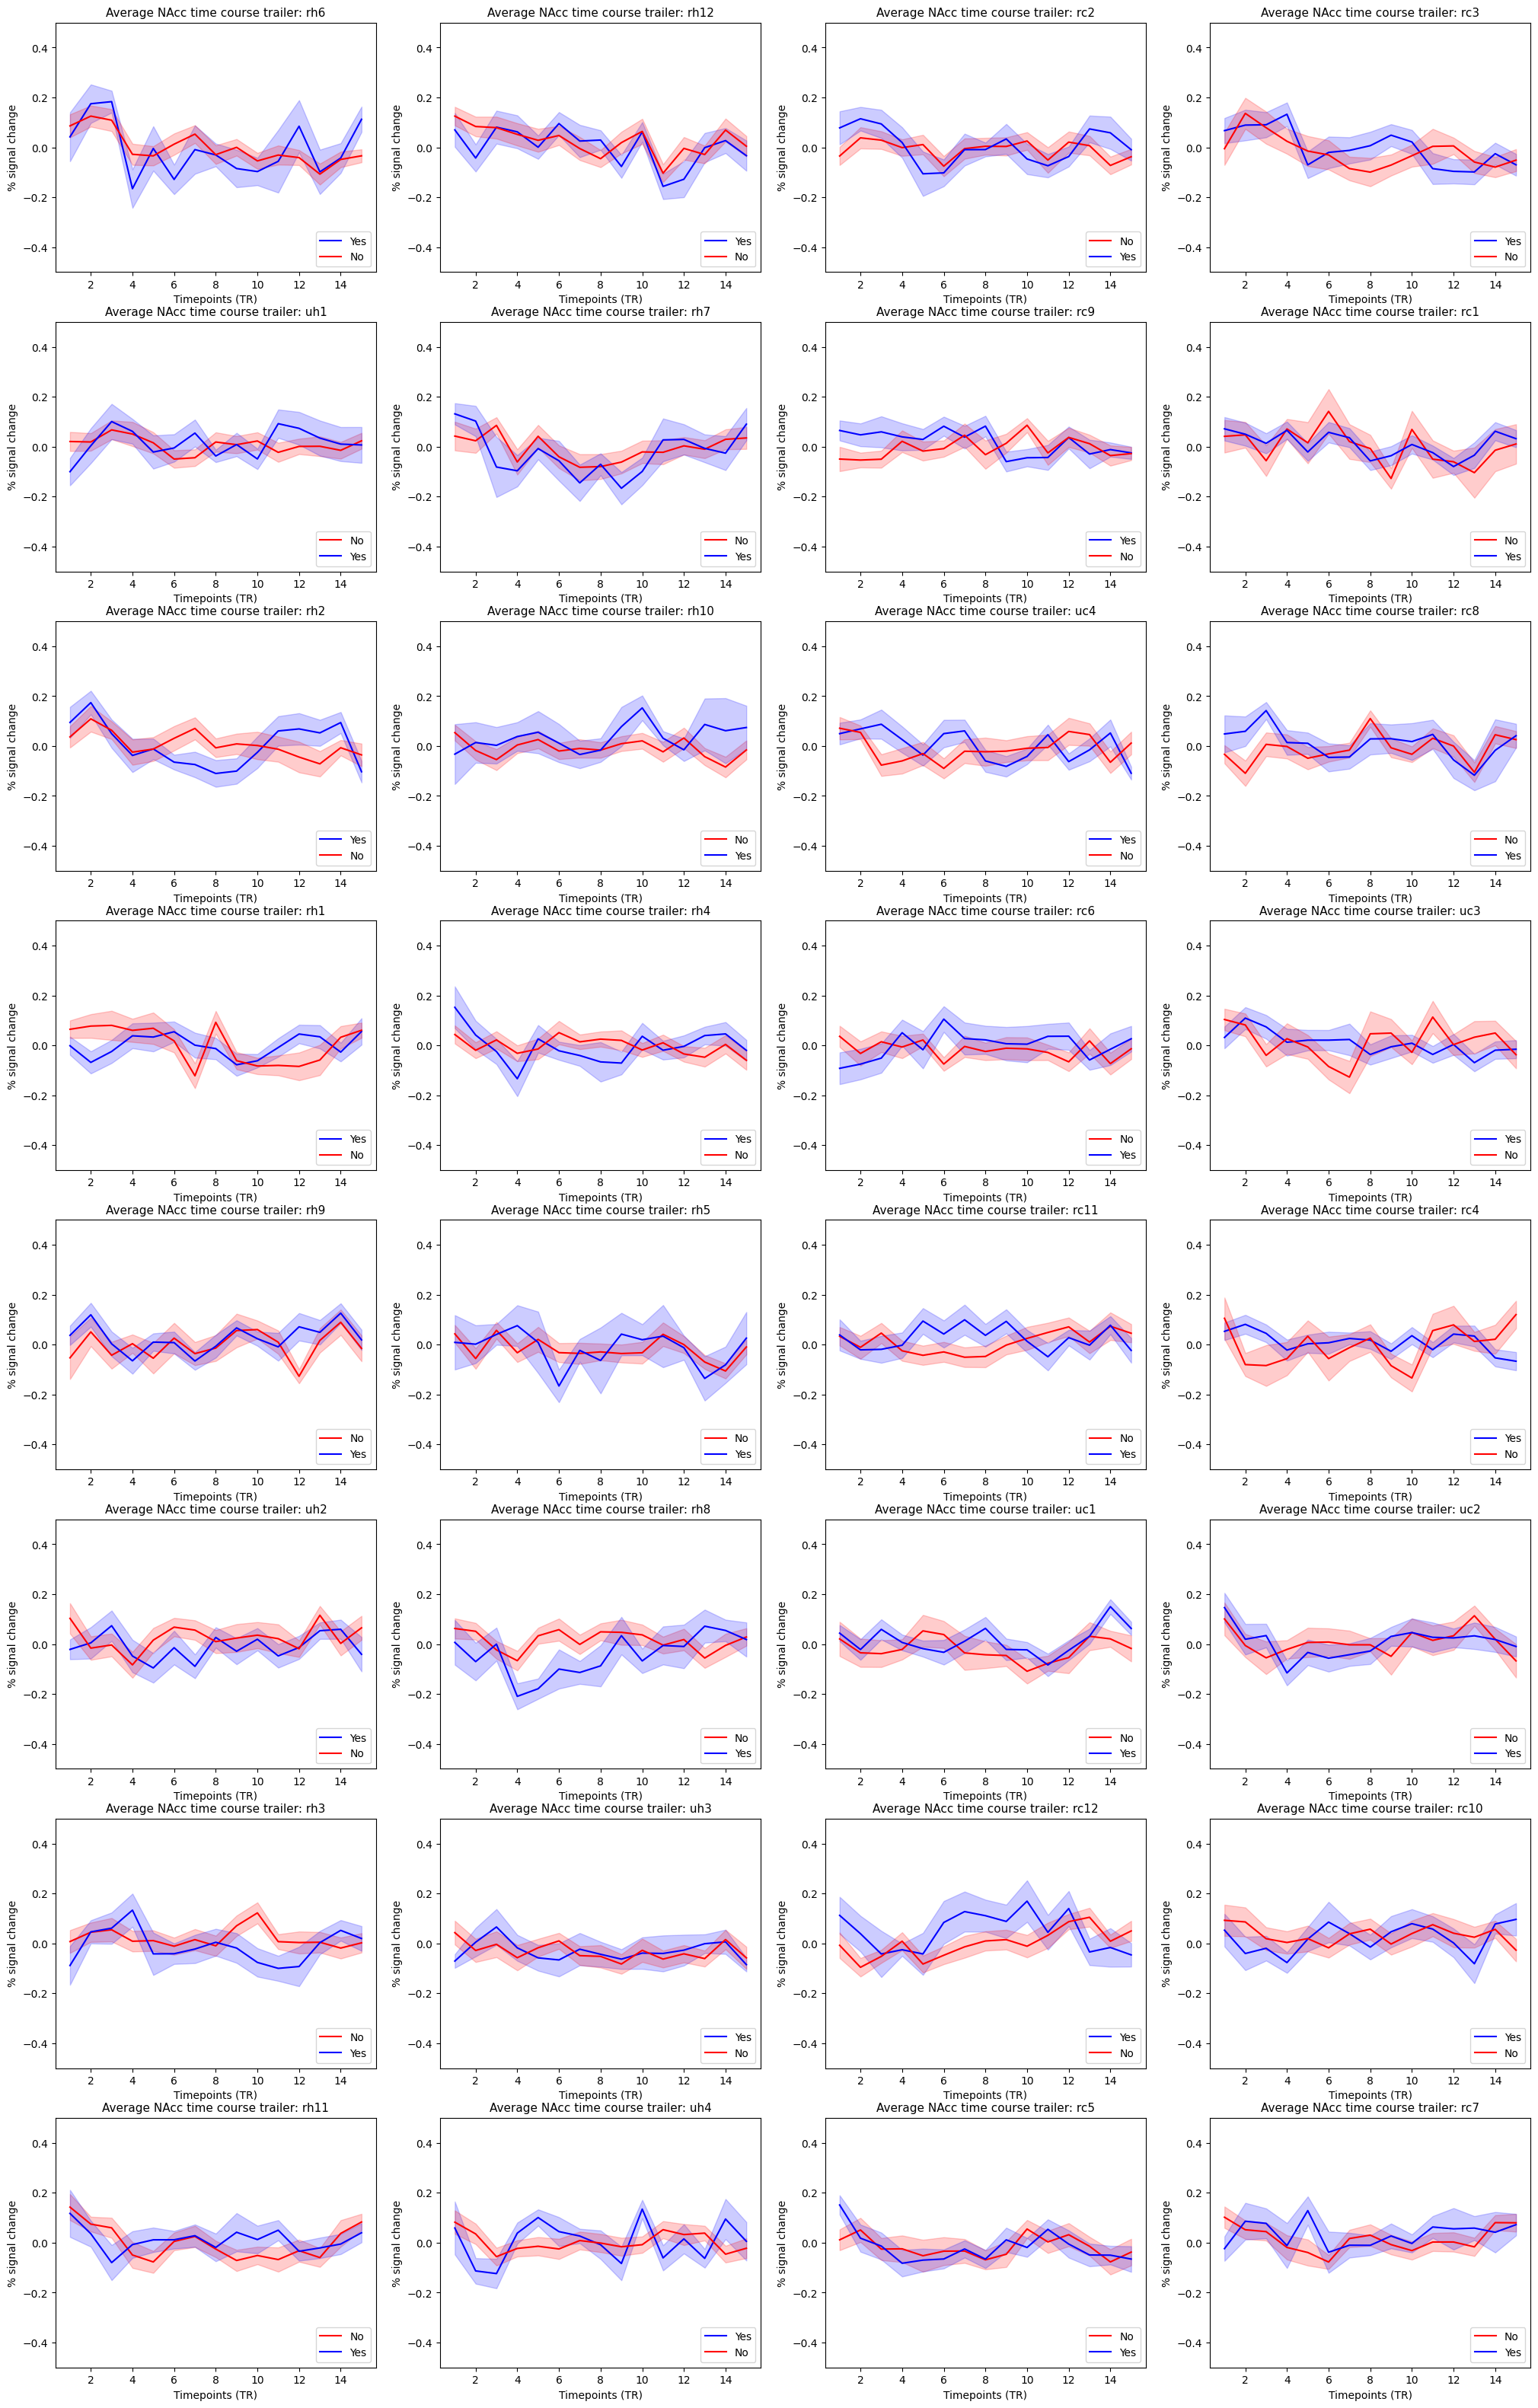

In [ ]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=NAcc_long_df.loc[NAcc_long_df["Trailer"] == r1_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average NAcc time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.5, .5)

    sns.lineplot(data=NAcc_long_df.loc[NAcc_long_df["Trailer"] == r2_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average NAcc time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.5, .5)
    runner +=1

    sns.lineplot(data=NAcc_long_df.loc[NAcc_long_df["Trailer"] == r1_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average NAcc time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.5, .5)

    sns.lineplot(data=NAcc_long_df.loc[NAcc_long_df["Trailer"] == r2_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 3], errorbar="se")
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average NAcc time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.5, .5)
    runner +=1

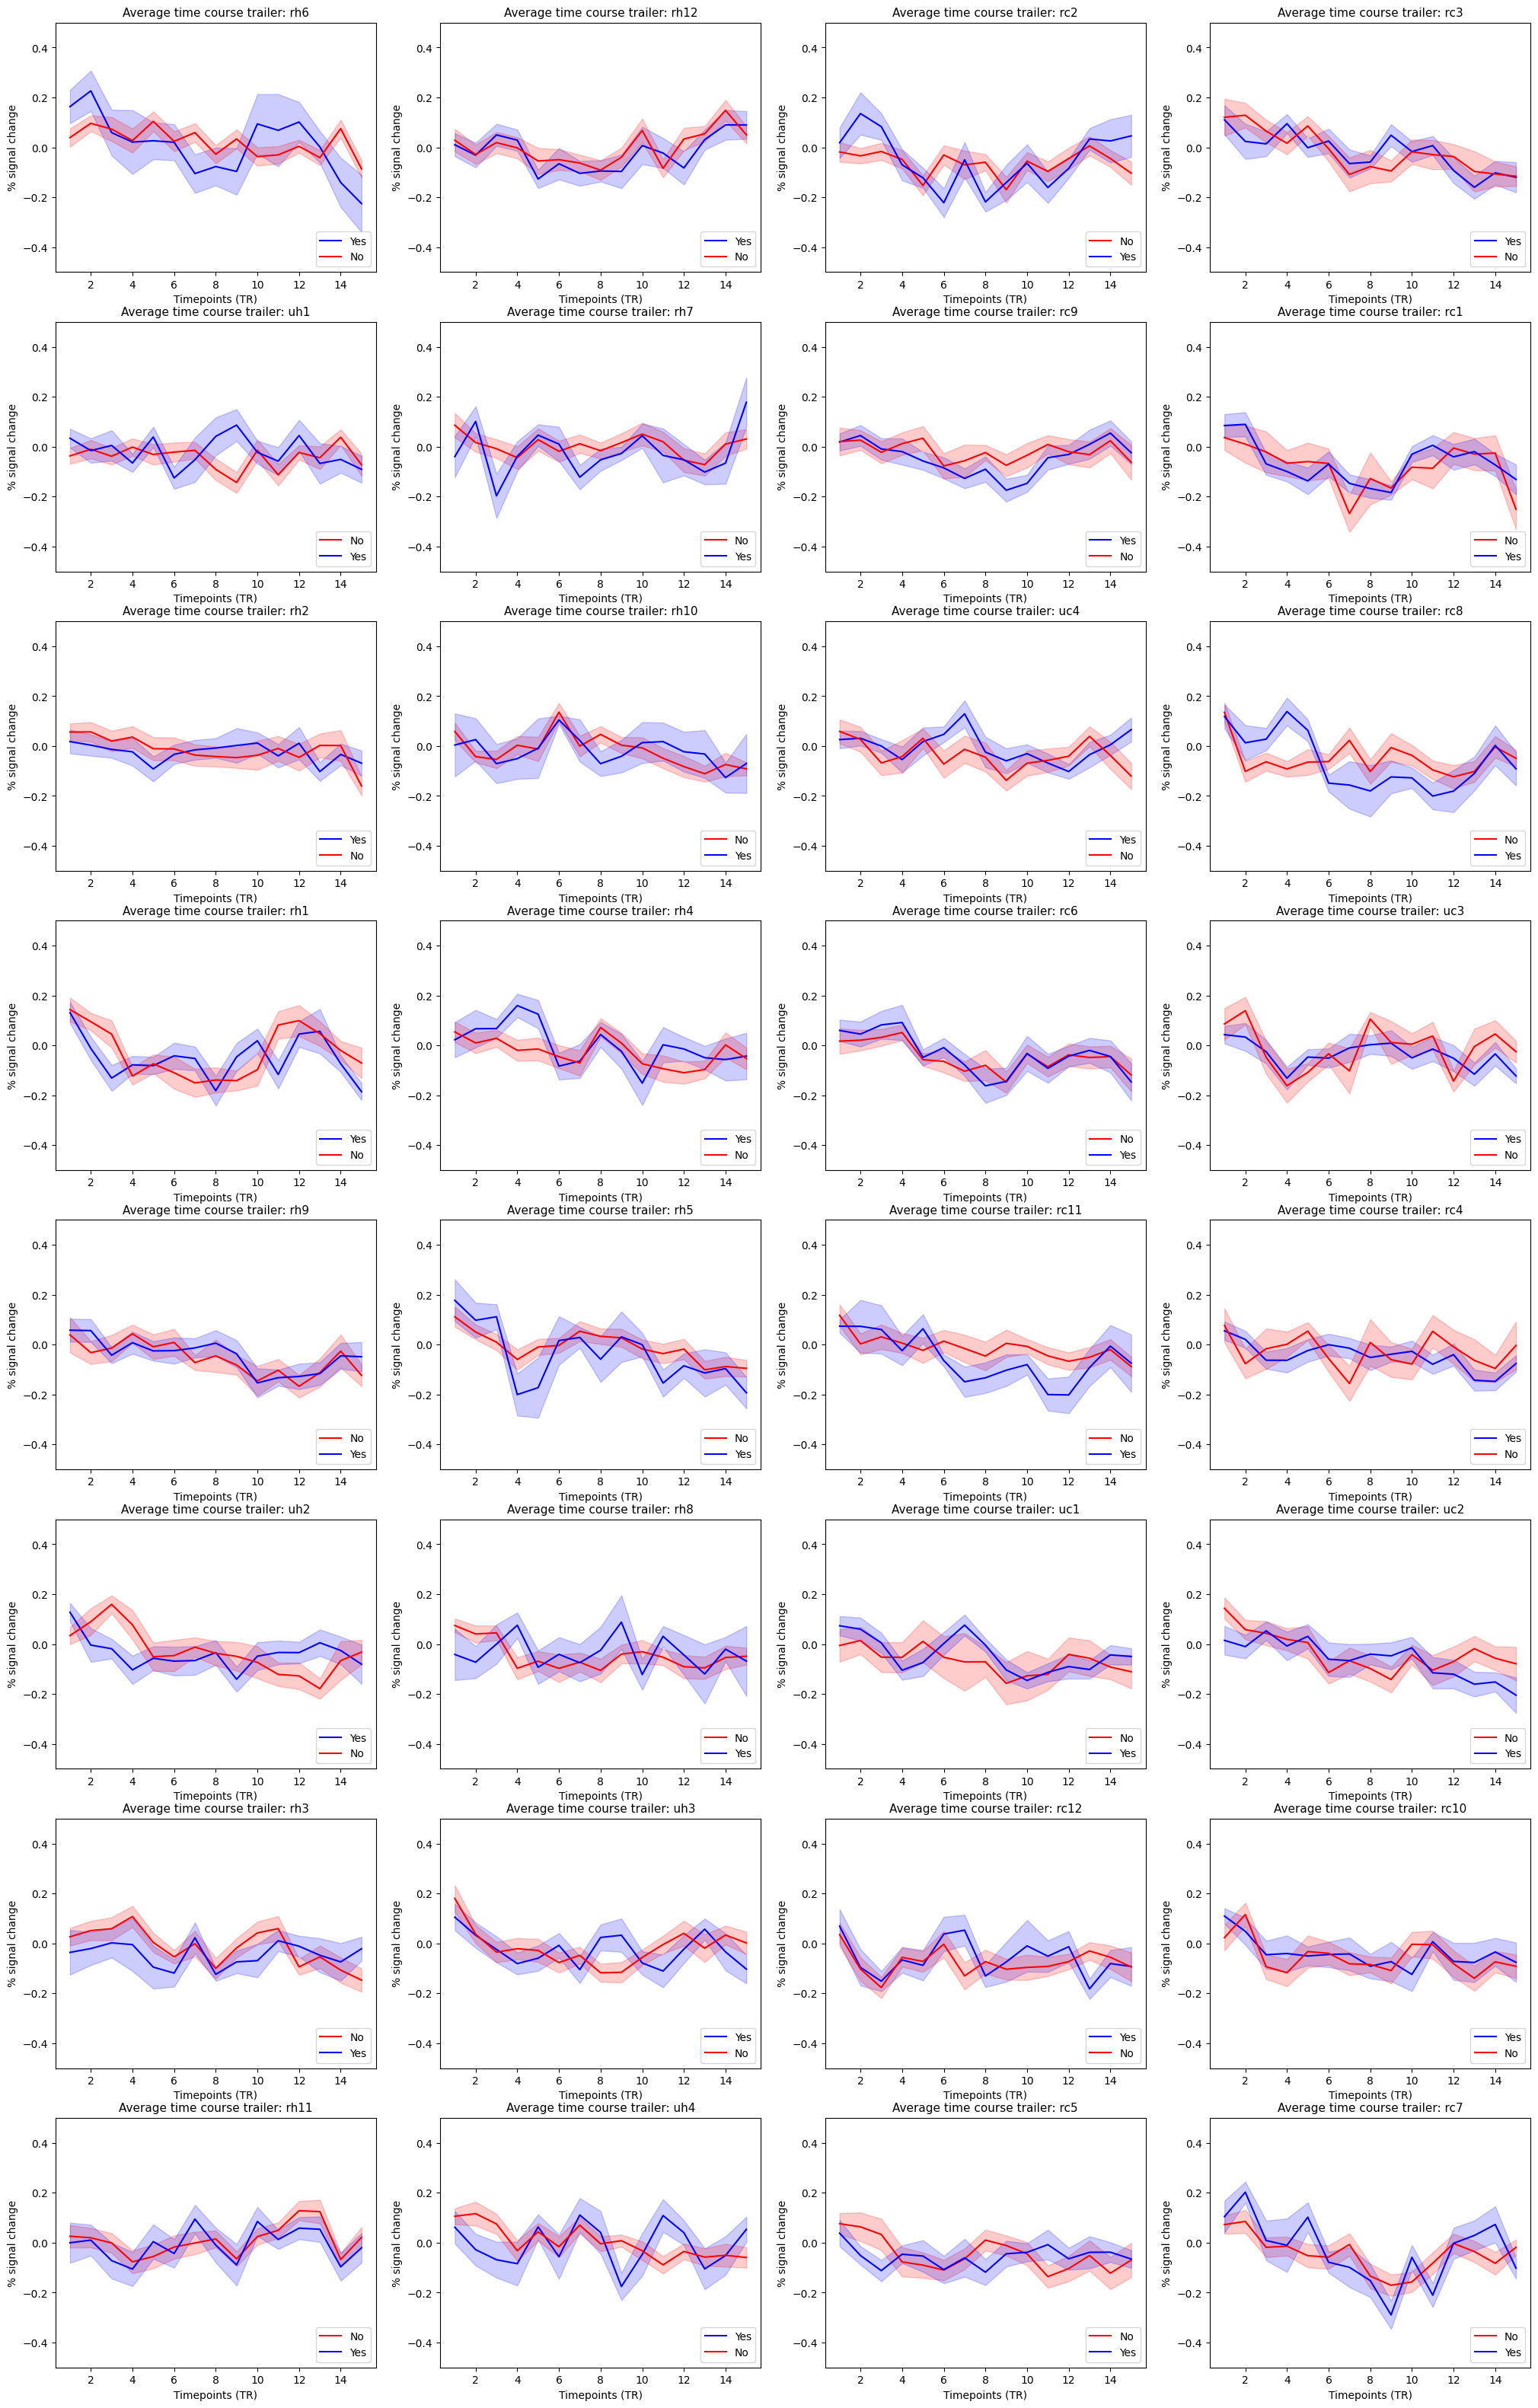

In [ ]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=AIns_long_df.loc[AIns_long_df["Trailer"] == r1_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.5, .5)

    sns.lineplot(data=AIns_long_df.loc[AIns_long_df["Trailer"] == r2_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.5, .5)
    runner +=1

    sns.lineplot(data=AIns_long_df.loc[AIns_long_df["Trailer"] == r1_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.5, .5)

    sns.lineplot(data=AIns_long_df.loc[AIns_long_df["Trailer"] == r2_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 3], errorbar="se")
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.5, .5)
    runner +=1

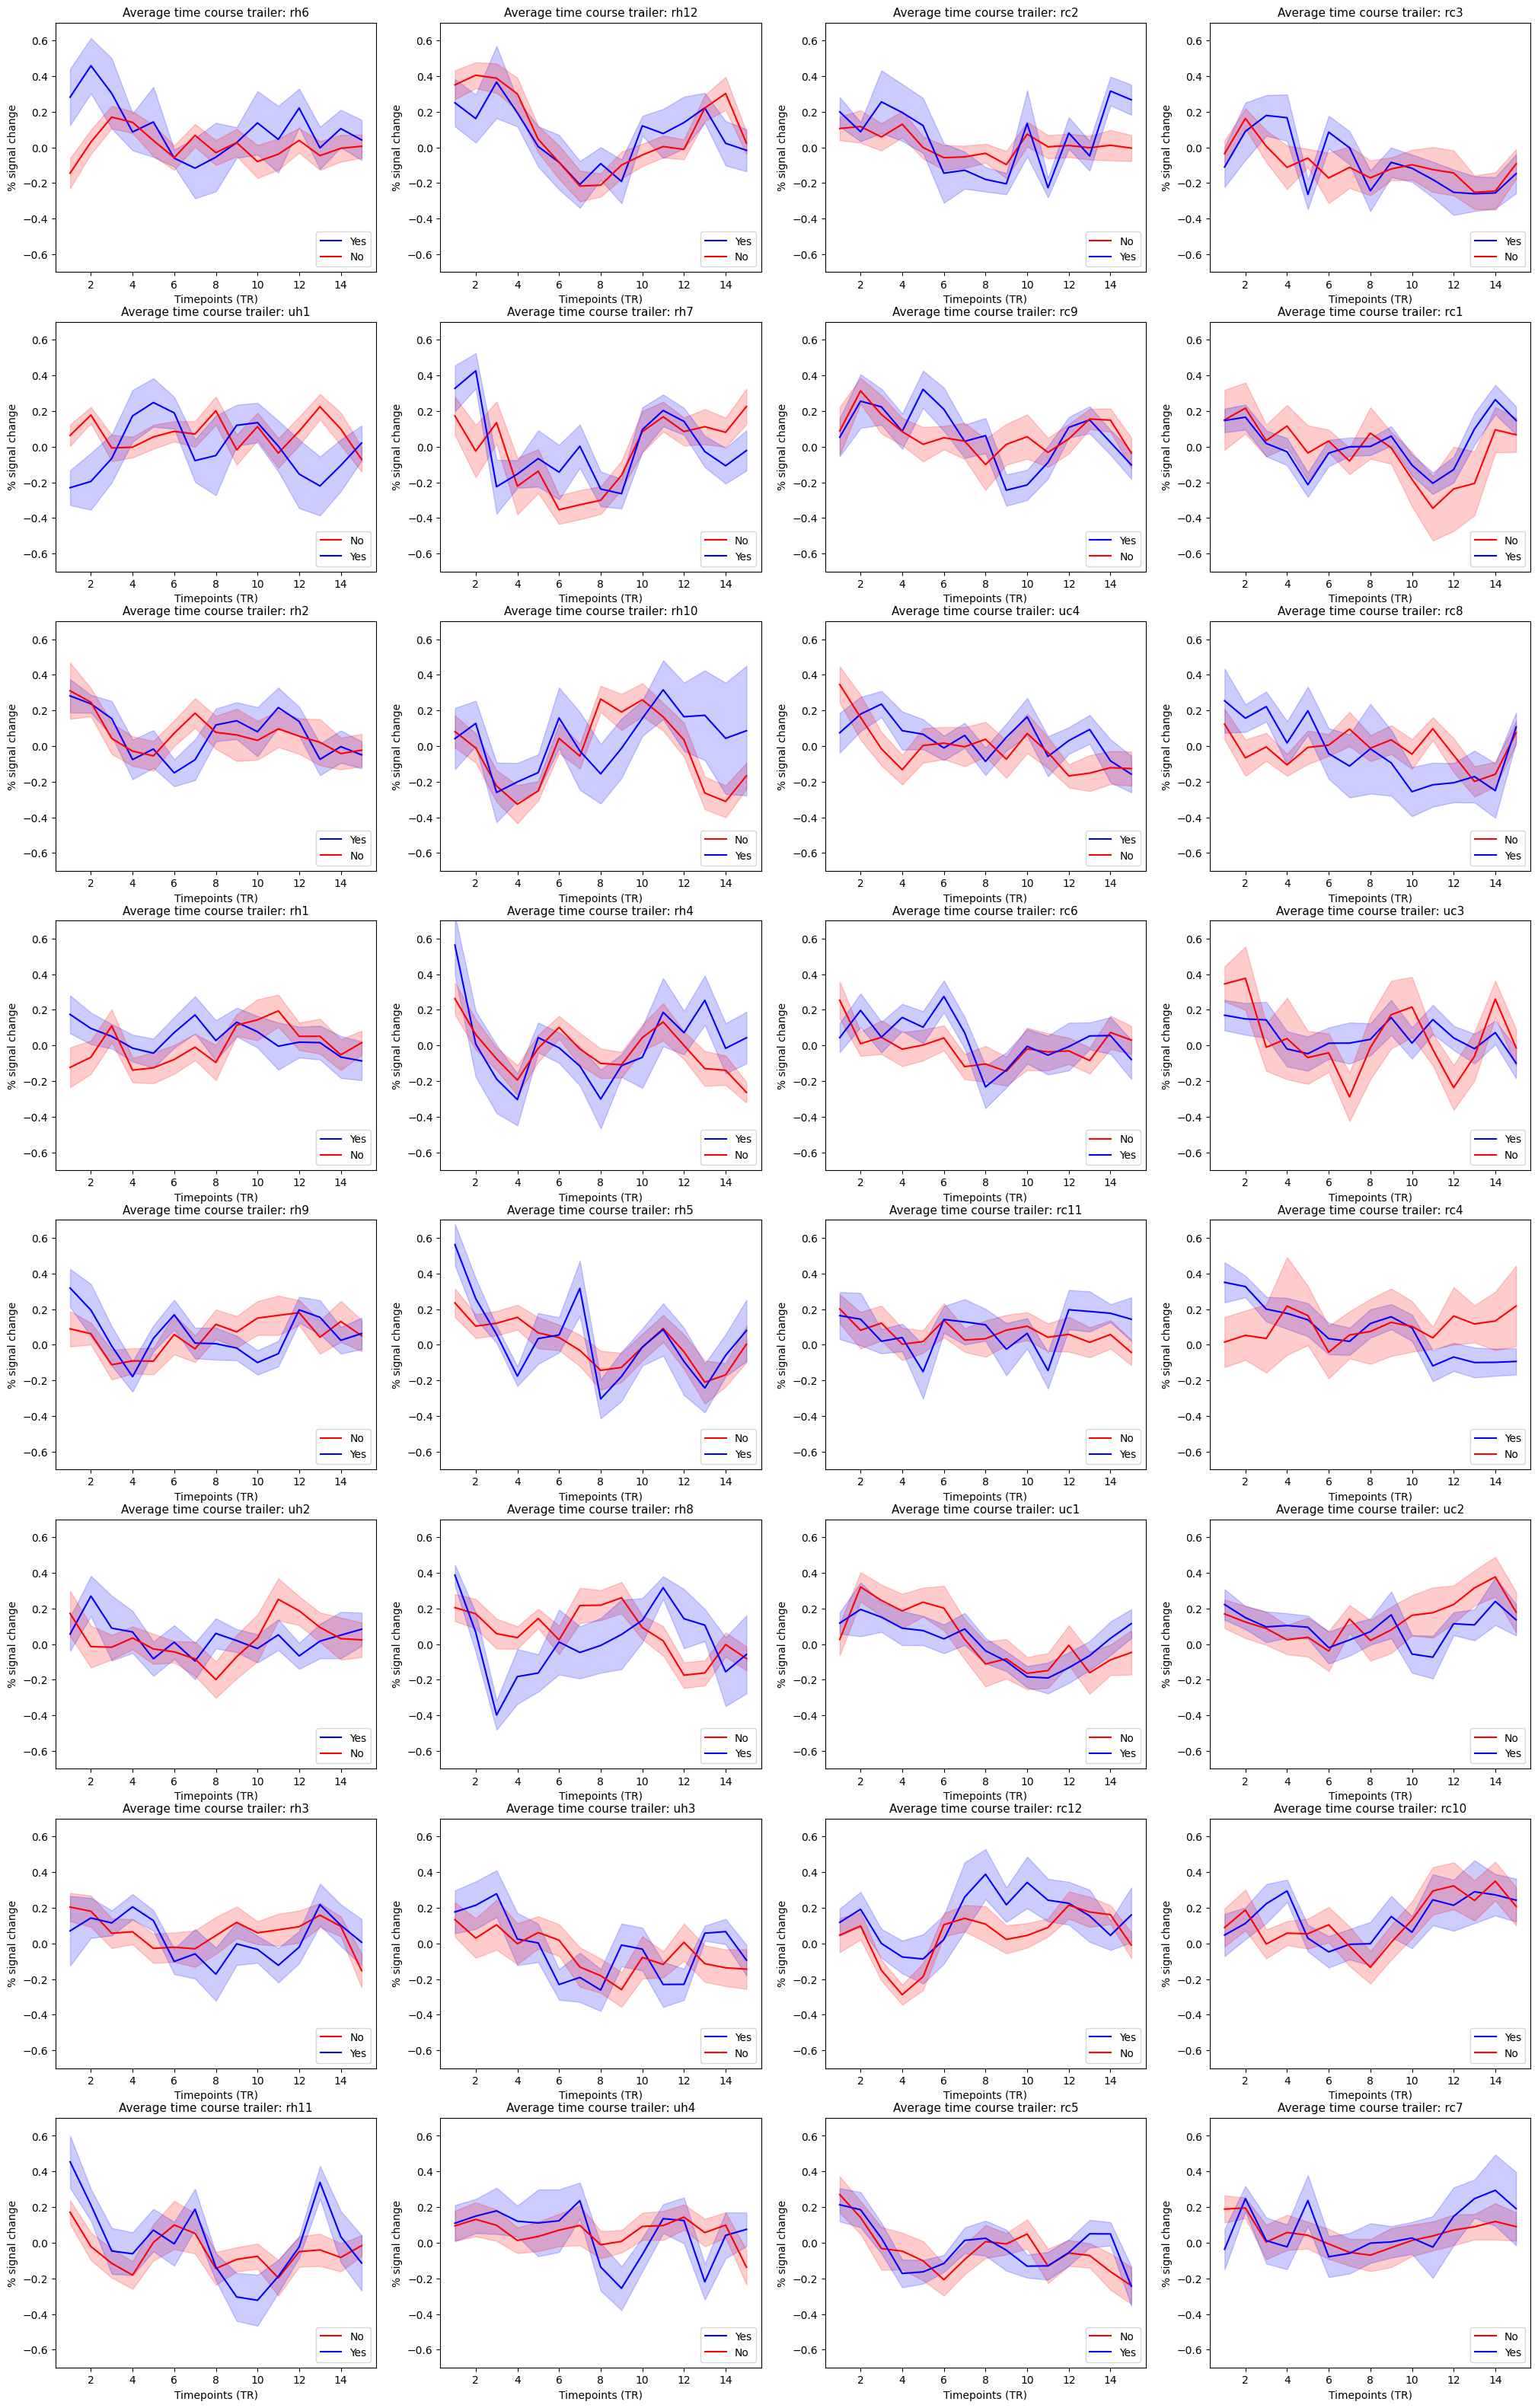

In [ ]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0

for id in range(8):

    sns.lineplot(data=MPFC_long_df.loc[MPFC_long_df["Trailer"] == r1_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.7, .7)

    sns.lineplot(data=MPFC_long_df.loc[MPFC_long_df["Trailer"] == r2_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.7, .7)
    runner +=1

    sns.lineplot(data=MPFC_long_df.loc[MPFC_long_df["Trailer"] == r1_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 2], errorbar="se")
    axs[id, 2].legend(loc='lower right', fontsize=10)
    axs[id, 2].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylabel('% signal change')
    axs[id, 2].set_xlabel('Timepoints (TR)')
    axs[id, 2].set_ylim(-.7, .7)

    sns.lineplot(data=MPFC_long_df.loc[MPFC_long_df["Trailer"] == r2_keys_sorted[runner]], x="TR", y="Signal", hue="Watch_choice",
                palette=dict(Yes="blue", No="red"), legend="brief", ax=axs[id, 3], errorbar="se")
    axs[id, 3].legend(loc='lower right', fontsize=10)
    axs[id, 3].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylabel('% signal change')
    axs[id, 3].set_xlabel('Timepoints (TR)')
    axs[id, 3].set_ylim(-.7, .7)
    runner +=1

# When do peaks occur?

In [ ]:
test_counts = all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[0]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False)
test_counts.index[0]
test_counts
r1_keys_sorted[1]

all_subs_events_df[all_subs_events_df["Trailer"] == "rc5"]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False)


NAcc_ind_peaks_pos_id
10.0    4
0.0     4
11.0    4
14.0    3
1.0     3
6.0     3
2.0     2
8.0     2
4.0     1
9.0     1
13.0    1
5.0     1
3.0     1
12.0    1
Name: count, dtype: int64

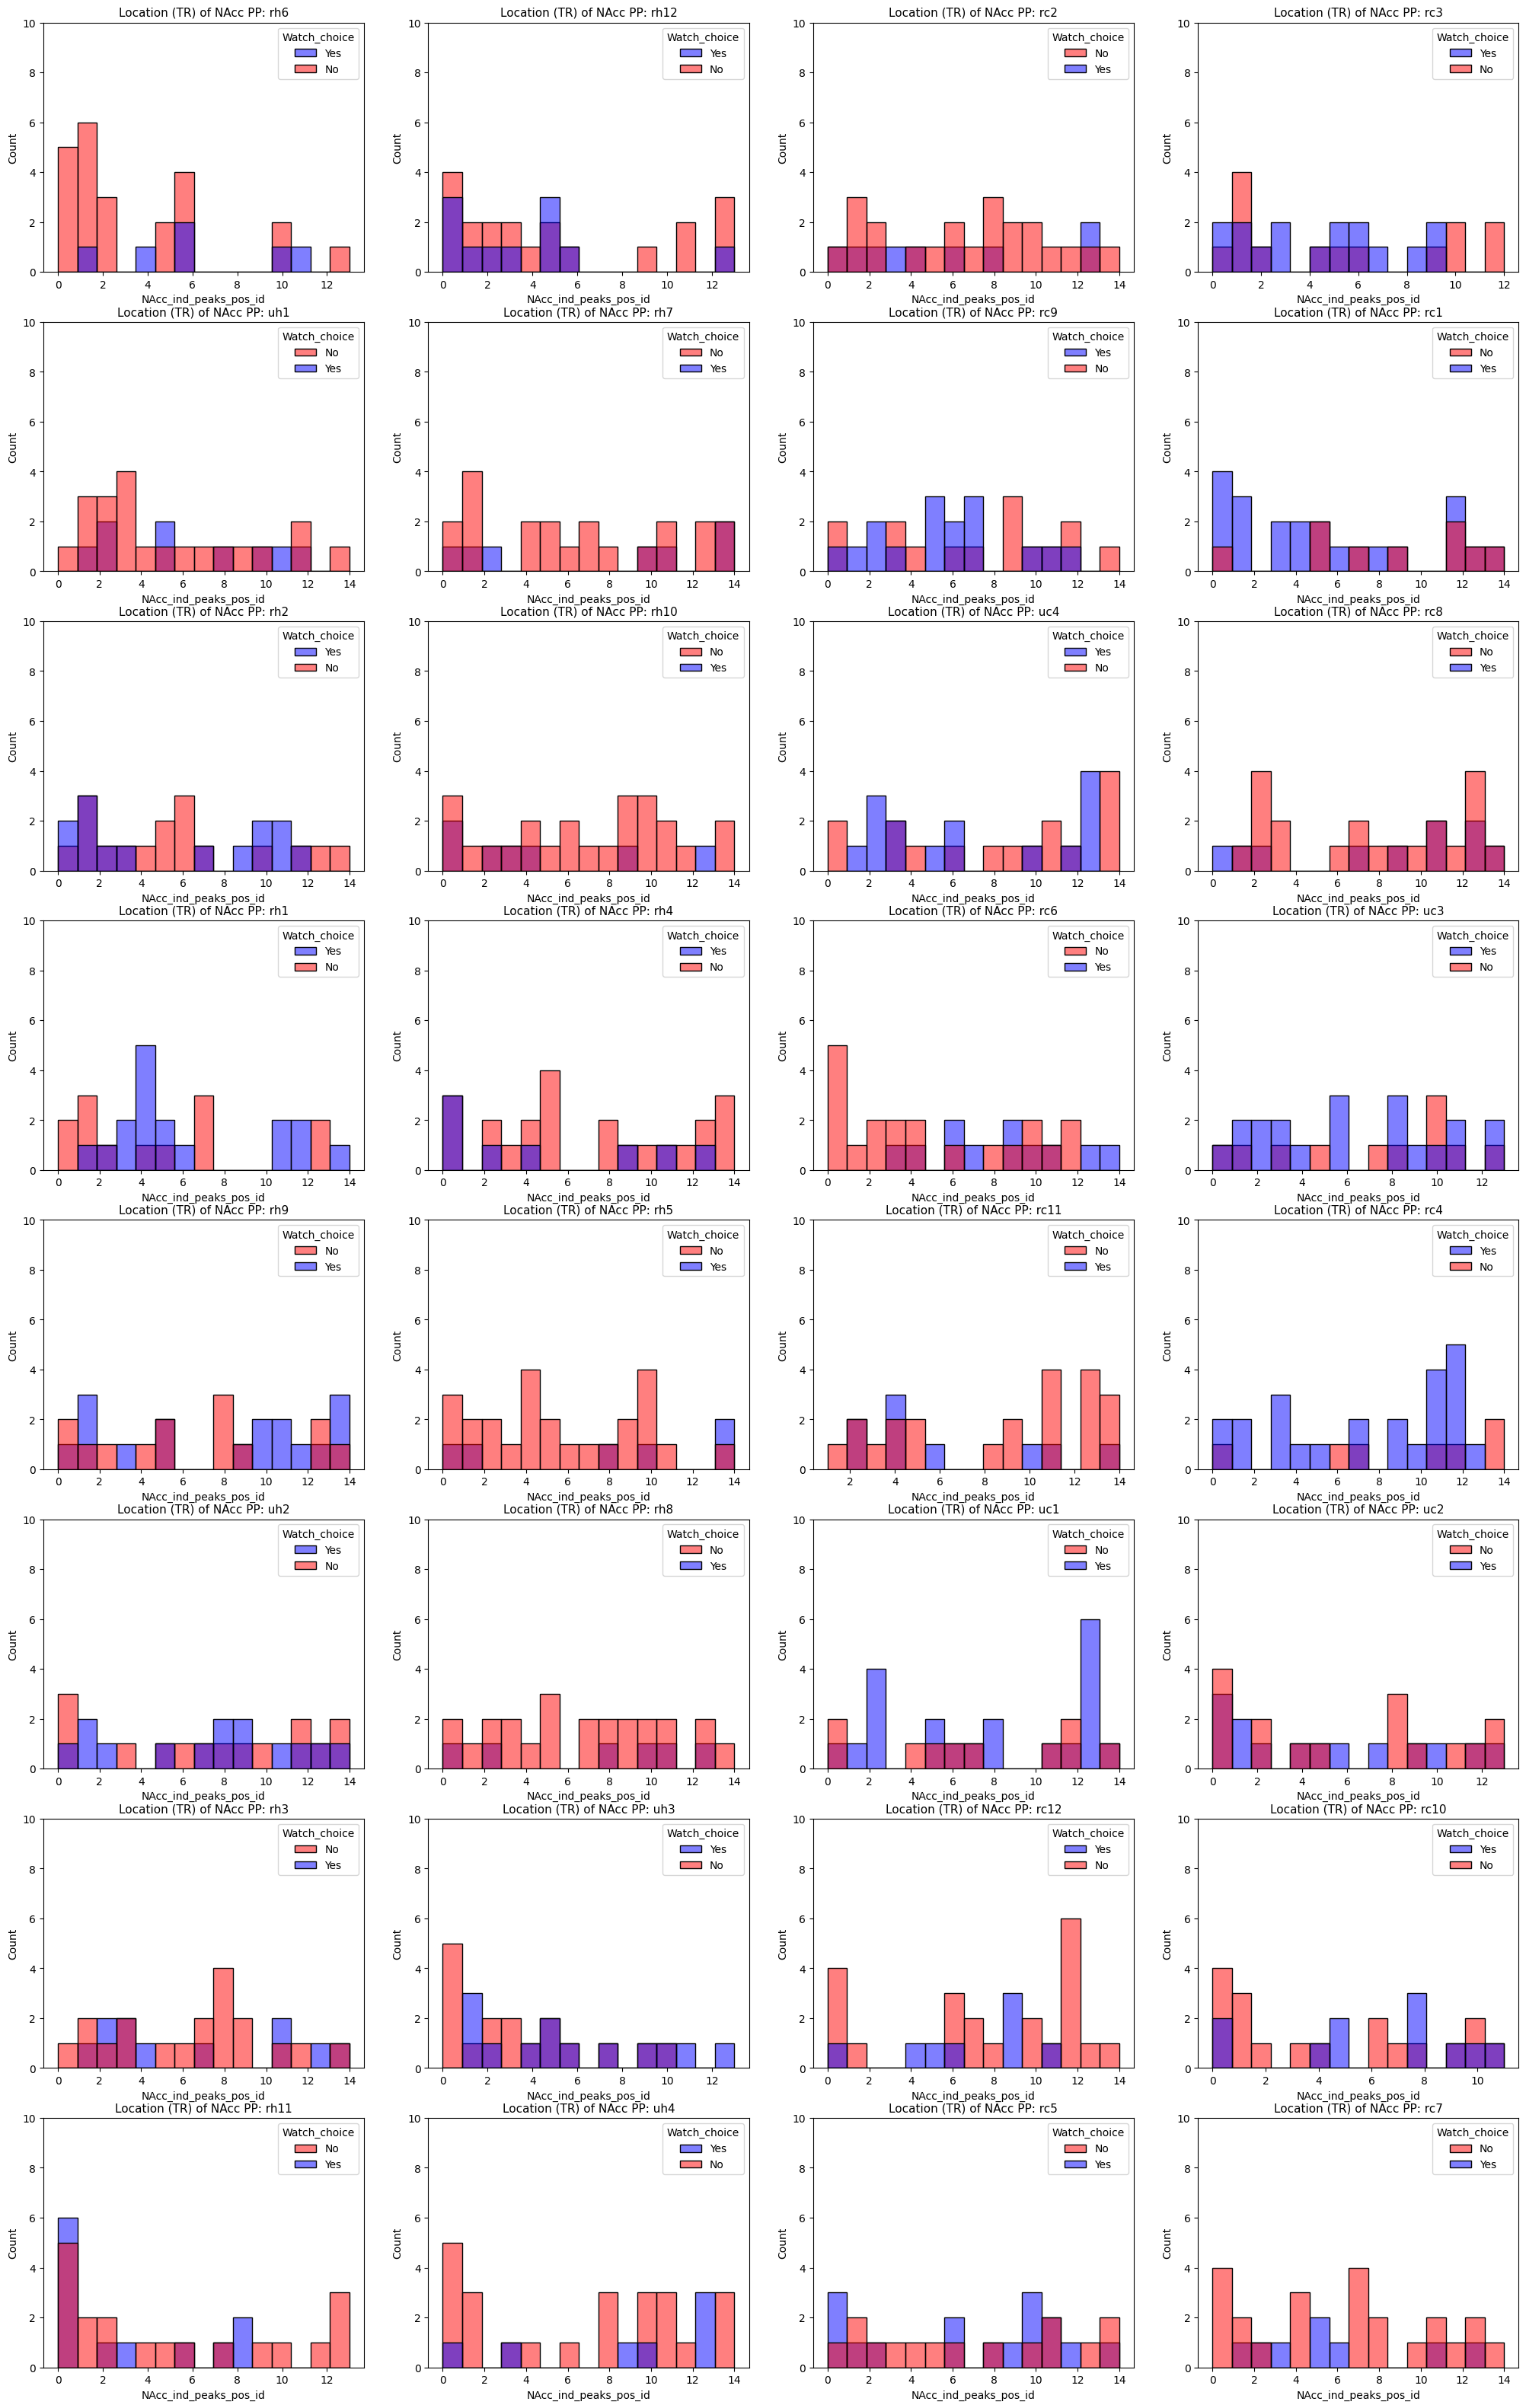

In [ ]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0 

for id in range(8):

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[runner]],
                x="NAcc_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 0], bins=15)
    axs[id, 0].set_title("Location (TR) of NAcc PP: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylim(0, 10)

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[runner]],
                x="NAcc_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 1], bins=15)
    axs[id, 1].set_title("Location (TR) of NAcc PP: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylim(0, 10)
    runner +=1

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[runner]],
            x="NAcc_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 2], bins=15)
    axs[id, 2].set_title("Location (TR) of NAcc PP: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylim(0, 10)

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[runner]],
                x="NAcc_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 3], bins=15)
    axs[id, 3].set_title("Location (TR) of NAcc PP: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylim(0, 10)
    runner +=1
    



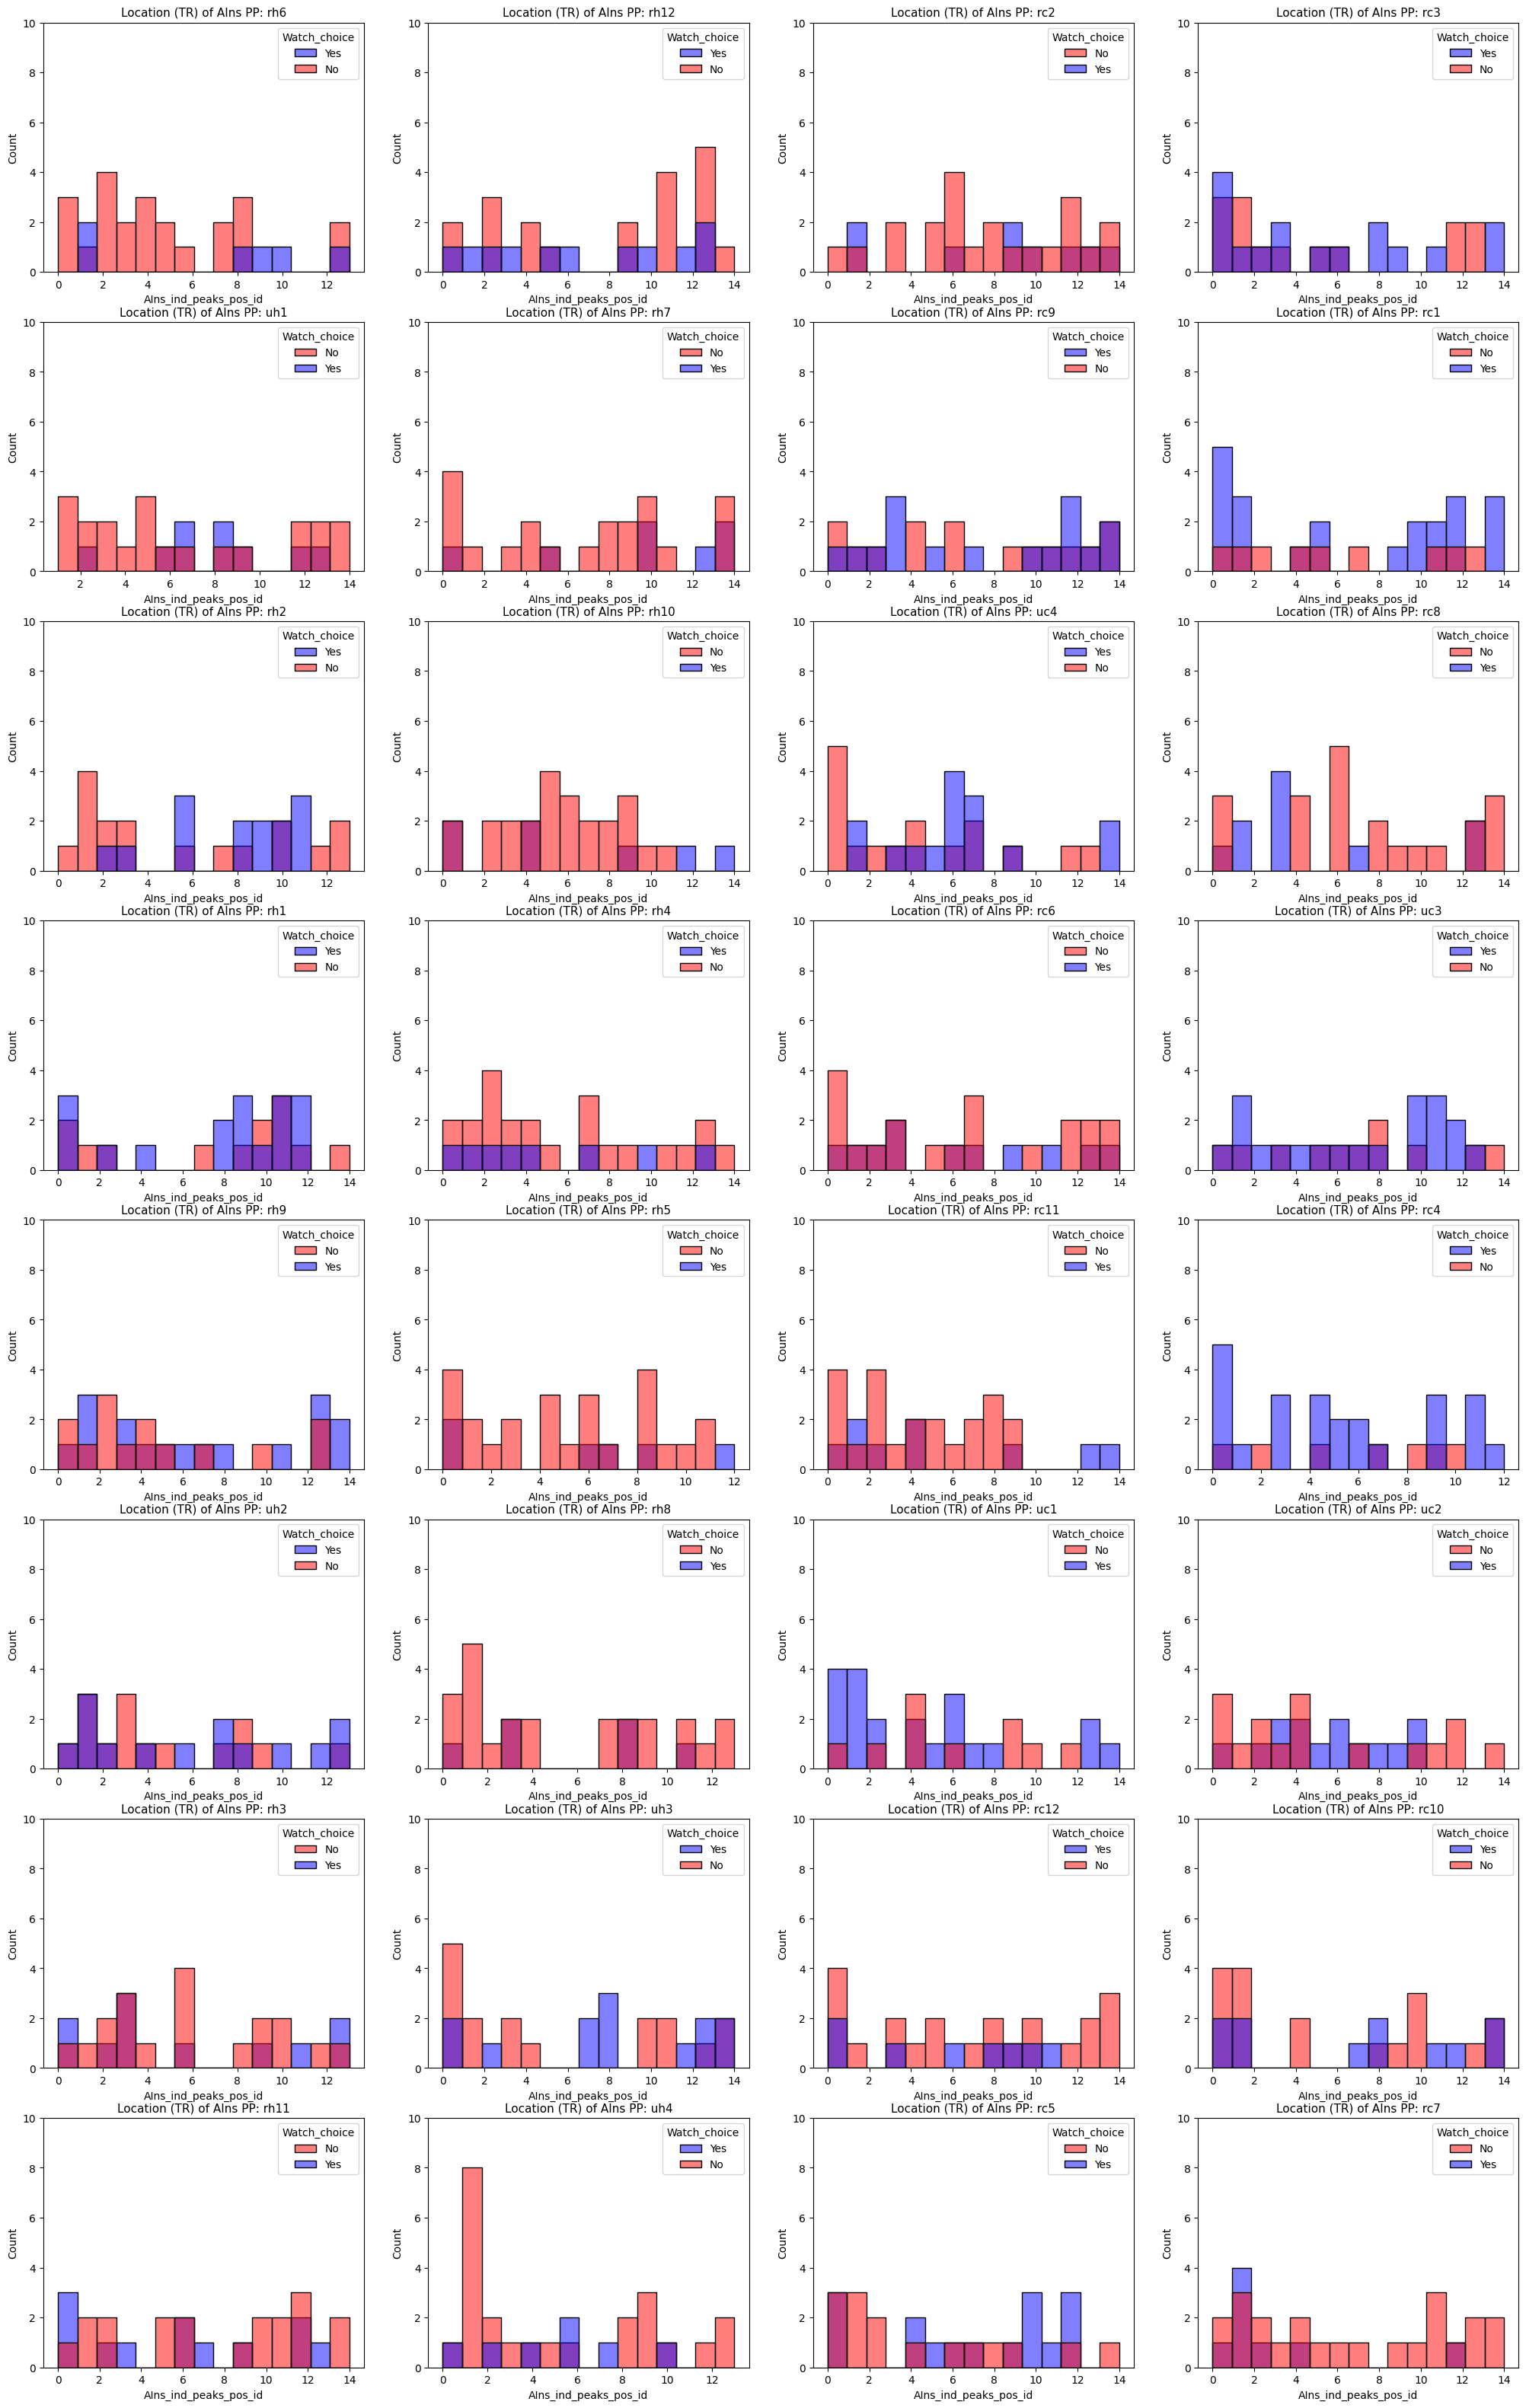

In [ ]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0 

for id in range(8):

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[runner]],
                x="AIns_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 0], bins=15)
    axs[id, 0].set_title("Location (TR) of AIns PP: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylim(0, 10)

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[runner]],
                x="AIns_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 1], bins=15)
    axs[id, 1].set_title("Location (TR) of AIns PP: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylim(0, 10)
    runner +=1

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[runner]],
            x="AIns_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 2], bins=15)
    axs[id, 2].set_title("Location (TR) of AIns PP: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylim(0, 10)

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[runner]],
                x="AIns_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 3], bins=15)
    axs[id, 3].set_title("Location (TR) of AIns PP: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylim(0, 10)
    runner +=1

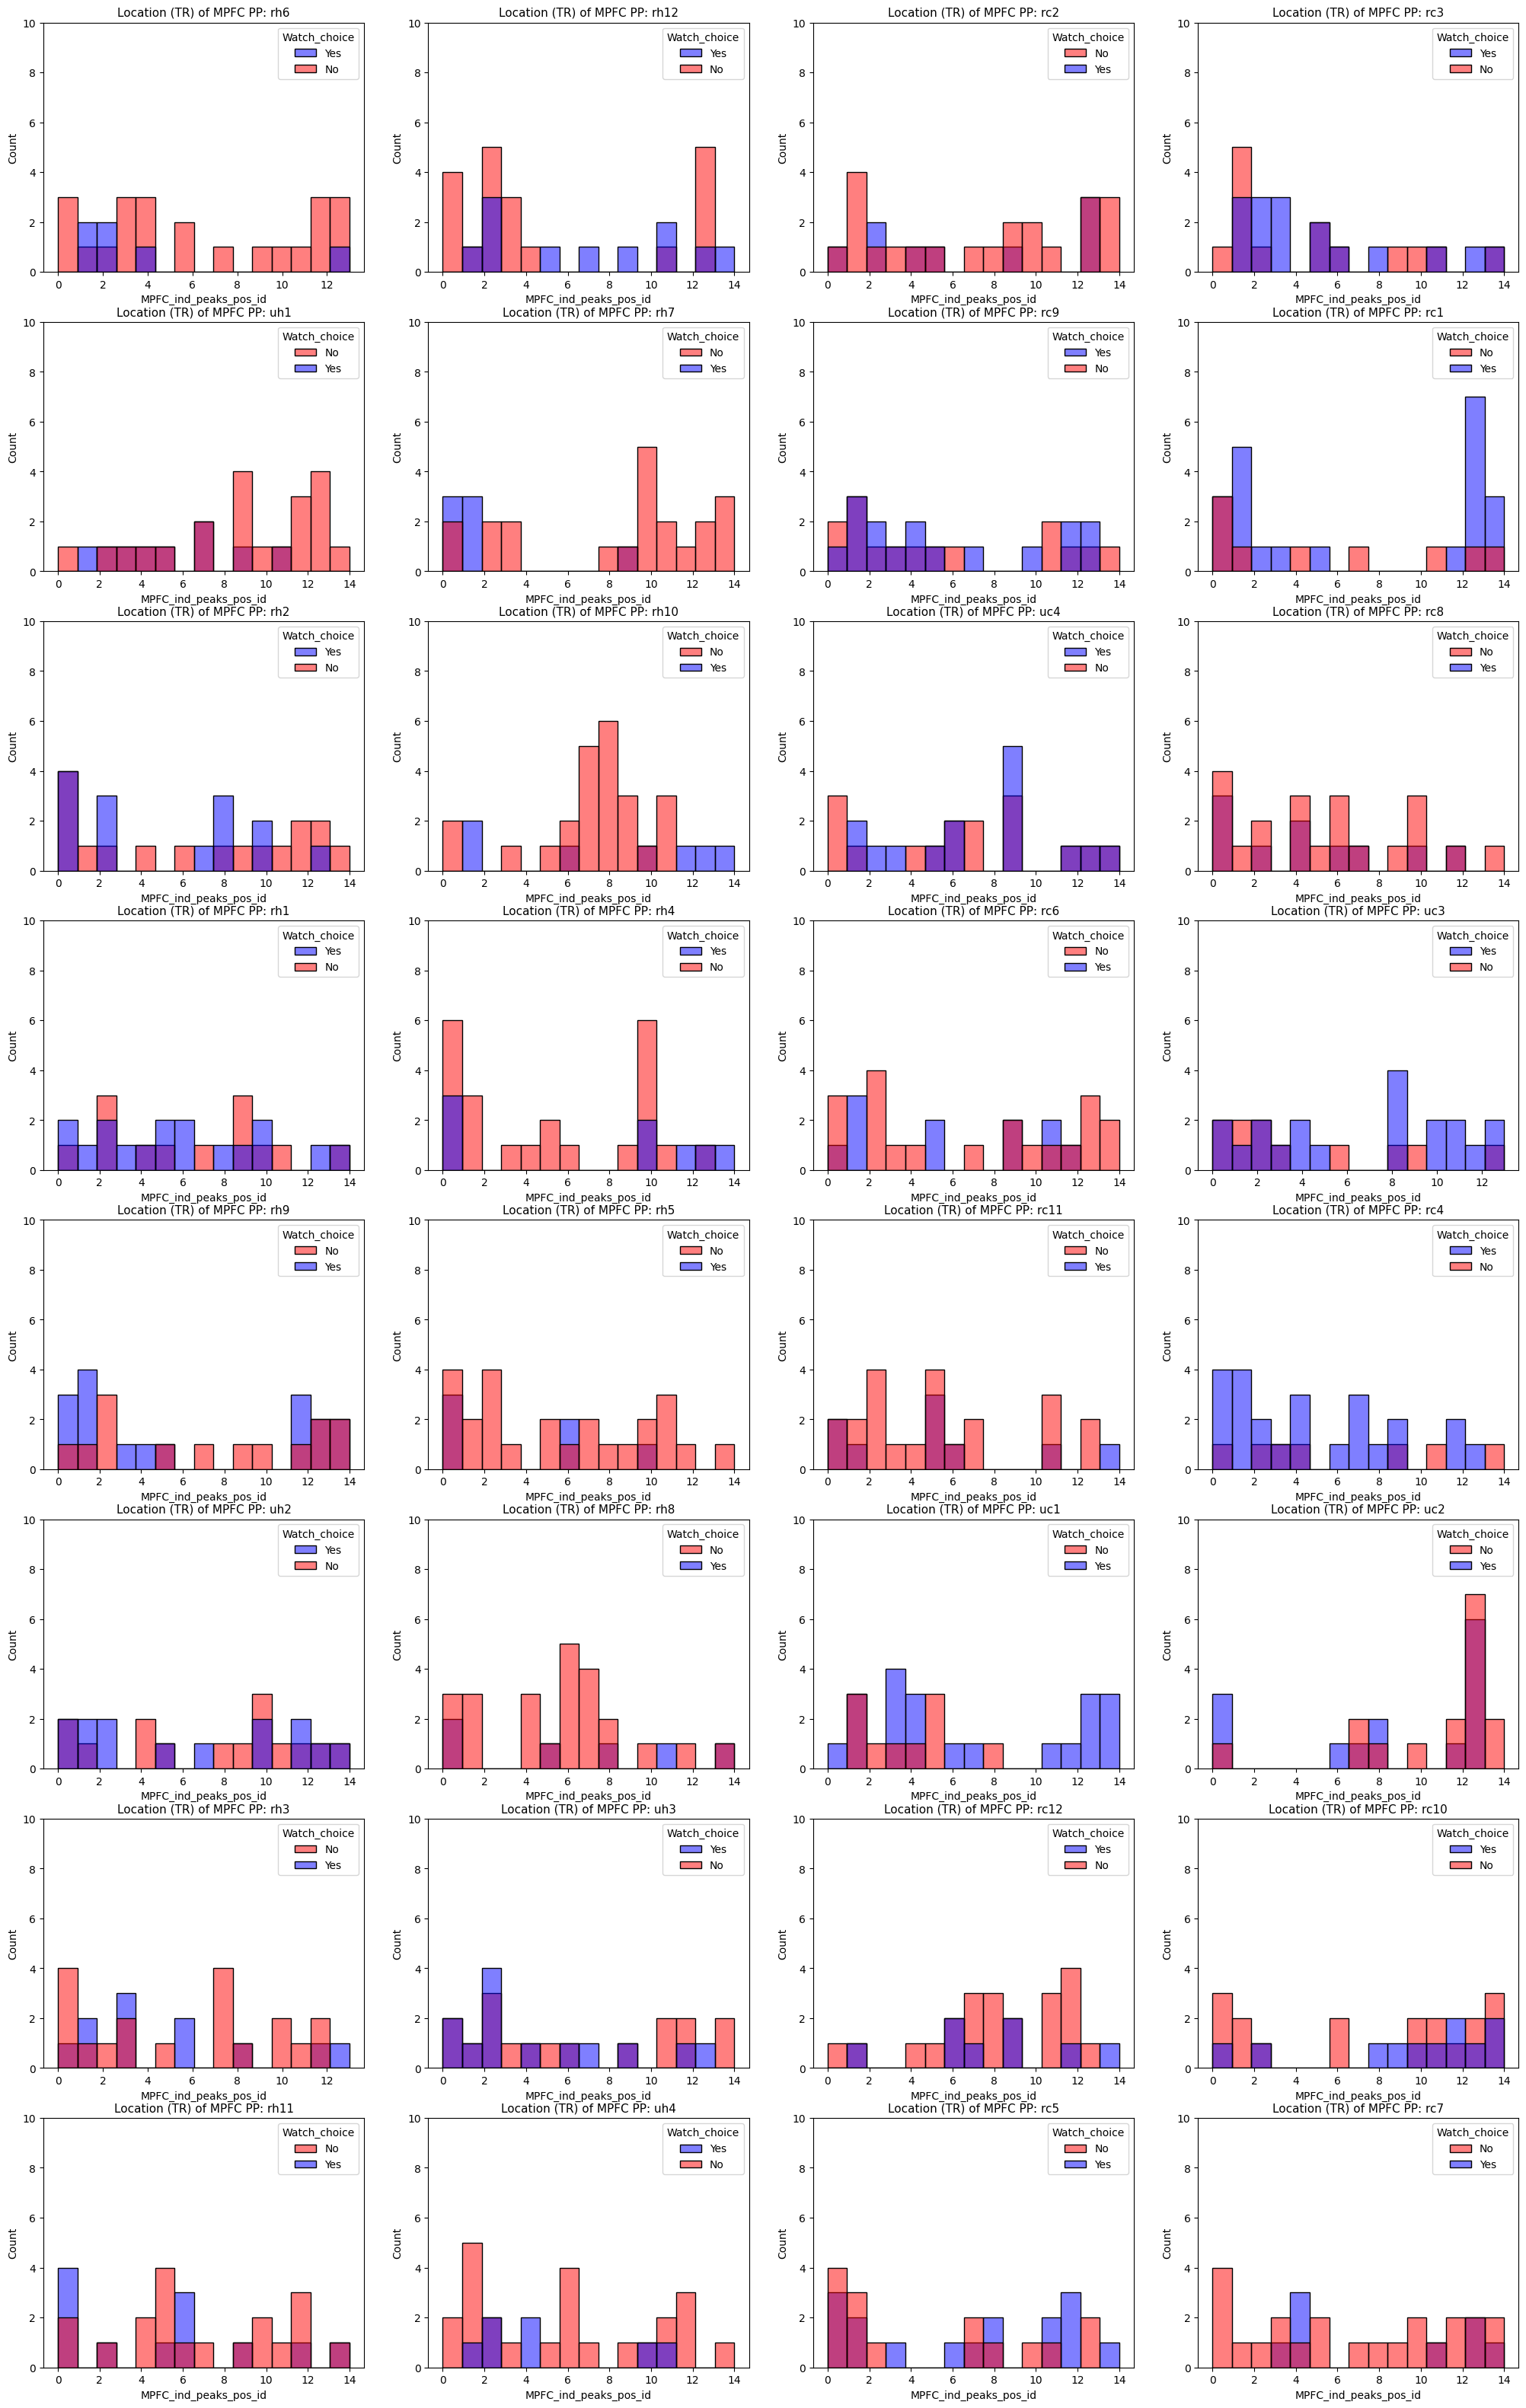

In [ ]:
fig, axs = plt.subplots(8, 4, figsize=(25, 40), sharex=False)

runner = 0 

for id in range(8):

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[runner]],
                x="MPFC_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 0], bins=15)
    axs[id, 0].set_title("Location (TR) of MPFC PP: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylim(0, 10)

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[runner]],
                x="MPFC_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 1], bins=15)
    axs[id, 1].set_title("Location (TR) of MPFC PP: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylim(0, 10)
    runner +=1

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[runner]],
            x="MPFC_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 2], bins=15)
    axs[id, 2].set_title("Location (TR) of MPFC PP: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 2].set_ylim(0, 10)

    sns.histplot(data=all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[runner]],
                x="MPFC_ind_peaks_pos_id", hue="Watch_choice", palette=dict(Yes="blue", No="red"), ax=axs[id, 3], bins=15)
    axs[id, 3].set_title("Location (TR) of MPFC PP: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 3].set_ylim(0, 10)
    runner +=1

In [ ]:
#Comedy_trailer_allsubs_df = all_subs_events_df[(all_subs_events_df["Type"]=="Comedy")].groupby("Trailer", as_index=False, dropna=False)

trailers_list = all_subs_events_df[(all_subs_events_df["Type"]=="Comedy")]["Trailer"].unique()

trailers_list = all_subs_events_df["Trailer"].unique()

peaks_info_df = pd.DataFrame()

# Loop through each trailer and get the peak info.
for trailer_id in trailers_list:

    # Access data from current trailer. 
    NAcc_DP_key = trailer_id + "_NAcc_dem_pos_loc"
    AIns_DP_key = trailer_id + "_AIns_dem_pos_loc"
    MPFC_DP_key = trailer_id + "_MPFC_dem_pos_loc"

    NAcc_DPy_key = trailer_id + "_NAcc_dem_pos_loc_yes"
    AIns_DPy_key = trailer_id + "_AIns_dem_pos_loc_yes"
    MPFC_DPy_key = trailer_id + "_MPFC_dem_pos_loc_yes"

    NAcc_AVG_key = trailer_id + "_NAcc_avg_peak_pos"
    AIns_AVG_key = trailer_id + "_AIns_avg_peak_pos"
    MPFC_AVG_key = trailer_id + "_MPFC_avg_peak_pos"

    NAcc_AVGy_key = trailer_id + "_NAcc_avg_peak_yes_pos"
    AIns_AVGy_key = trailer_id + "_AIns_avg_peak_yes_pos"
    MPFC_AVGy_key = trailer_id + "_MPFC_avg_peak_yes_pos"

    # Access data in from dictionary. 
    NAcc_DP = all_peaks_id[NAcc_DP_key]
    AIns_DP = all_peaks_id[AIns_DP_key]
    MPFC_DP = all_peaks_id[MPFC_DP_key]

    NAcc_DPy = all_peaks_id[NAcc_DPy_key]
    AIns_DPy = all_peaks_id[AIns_DPy_key]
    MPFC_DPy = all_peaks_id[MPFC_DPy_key]

    NAcc_AVG = all_peaks_id[NAcc_AVG_key]
    AIns_AVG = all_peaks_id[AIns_AVG_key]
    MPFC_AVG = all_peaks_id[MPFC_AVG_key]

    NAcc_AVGy = all_peaks_id[NAcc_AVGy_key]
    AIns_AVGy = all_peaks_id[AIns_AVGy_key]
    MPFC_AVGy = all_peaks_id[MPFC_AVGy_key]

    # Determine type of movie. 
    if "h" in trailer_id:
        type = "Horror"
    elif "c" in trailer_id:
        type = "Comedy"
    else:
        type = "NA"

    # Create new dataframe for current trailer. 
    current_trailer_df = pd.DataFrame(data={"Trailer": trailer_id, "Type":type, "NAcc_DP": NAcc_DP, "AIns_DP": AIns_DP, "MPFC_DP": MPFC_DP,
                                            "NAcc_DPy": NAcc_DPy, "AIns_DPy": AIns_DPy, "MPFC_DPy": MPFC_DPy,
                                            "NAcc_AVG": NAcc_AVG, "AIns_AVG": AIns_AVG, "MPFC_AVG": MPFC_AVG,
                                            "NAcc_AVGy": NAcc_AVGy, "AIns_AVGy": AIns_AVGy, "MPFC_AVGy": MPFC_AVGy})

    # Concat to main dataframe.
    peaks_info_df = pd.concat([peaks_info_df, current_trailer_df], axis=0)

peaks_info_df.reset_index(drop=True, inplace=True)
peaks_info_df.to_csv(root_path + "/PeaksInfo.csv", index=False)
peaks_info_df.head(30)


Trailer    Type  NAcc_DP  AIns_DP  MPFC_DP  NAcc_DPy  AIns_DPy  MPFC_DPy  \
0      rh6  Horror      0.0      2.0      2.0       2.0       1.0       1.0   
1      uh1  Horror      2.0      1.0     13.0       6.0       8.0       3.0   
2      rc2  Comedy      1.0      1.0      3.0       2.0       1.0       2.0   
3      rh2  Horror      1.0      1.0      0.0       1.0       1.0       0.0   
4      rh1  Horror      3.0      0.0      2.0       4.0       0.0       0.0   
5      rc9  Comedy      0.0      0.0      1.0       2.0       1.0       1.0   
6      uc4  Comedy      2.0      0.0      0.0       2.0       6.0       9.0   
7      rh9  Horror      1.0      0.0      0.0       1.0       1.0       0.0   
8      uh2  Horror      0.0      1.0      1.0       1.0       0.0       1.0   
9      rc6  Comedy      6.0      0.0     13.0       6.0       0.0       1.0   
10     rh3  Horror      3.0      3.0     12.0       3.0       0.0      12.0   
11    rc11  Comedy      2.0      0.0      5.0       4.0       1.0       5.0   
12     uc1  Comedy      7.0      1.0      1.0      13.0       1.0       1.0   
13    rh11  Horror      0.0     11.0      6.0       0.0       0.0       0.0   
14    rc12  Comedy     10.0      0.0      7.0       9.0       0.0       7.0   
15     rc5  Comedy      0.0      0.0      1.0       0.0       0.0       1.0   
16     rc3  Comedy      1.0      0.0      1.0       1.0       0.0       1.0   
17    rh12  Horror      0.0     13.0      0.0       0.0      13.0       0.0   
18     rc1  Comedy      0.0      0.0      0.0       3.0       0.0      13.0   
19     rh7  Horror      1.0     14.0      1.0       0.0       0.0       1.0   
20     rc8  Comedy     13.0      0.0      0.0      13.0       3.0       0.0   
21     uc3  Comedy      1.0      1.0      0.0       1.0       1.0       8.0   
22    rh10  Horror      0.0      5.0      7.0       0.0       4.0       1.0   
23     rc4  Comedy     11.0      0.0      0.0       1.0       0.0       0.0   
24     rh4  Horror      0.0      0.0      0.0       0.0       4.0       0.0   
25     uc2  Comedy      0.0      4.0     13.0       0.0       4.0      13.0   
26     rh5  Horror     10.0      0.0      0.0       1.0       0.0       0.0   
27     rh8  Horror      5.0      0.0      6.0      11.0       0.0       0.0   
28    rc10  Comedy      0.0     10.0     11.0       0.0       0.0      12.0   
29     uh3  Horror      6.0      0.0      0.0       6.0       0.0       2.0   

    NAcc_AVG  AIns_AVG  MPFC_AVG  NAcc_AVGy  AIns_AVGy  MPFC_AVGy  
0          1         1         2          2          1          1  
1          2        13         7          2          8          4  
2          1         1         3          1          1         13  
3          1         0         0          1          0          0  
4         14         0         8         14          0          0  
5          6        13         1          7         13          4  
6          1         6         0          2          6          2  
7         13         0         0         13          0          0  
8         12         0        10          2          0          1  
9          3         3         0          5          3          5  
10         2         3         1          3          6         12  
11        13         0         0          6          0         11  
12        13         0         1         13          6          1  
13         0        11         0          0          6          0  
14        11         0        11          9          0          7  
15         0         0         0          0          0          0  
16         1         0         1          3          0          2  
17         0        13         2          5         13          2  
18         5         0        13          0          1         13  
19        14        14         0          0         14          1  
20         7         0         0          2          3          0  
21         1         1         0          1          0   

(0.0, 7.0)

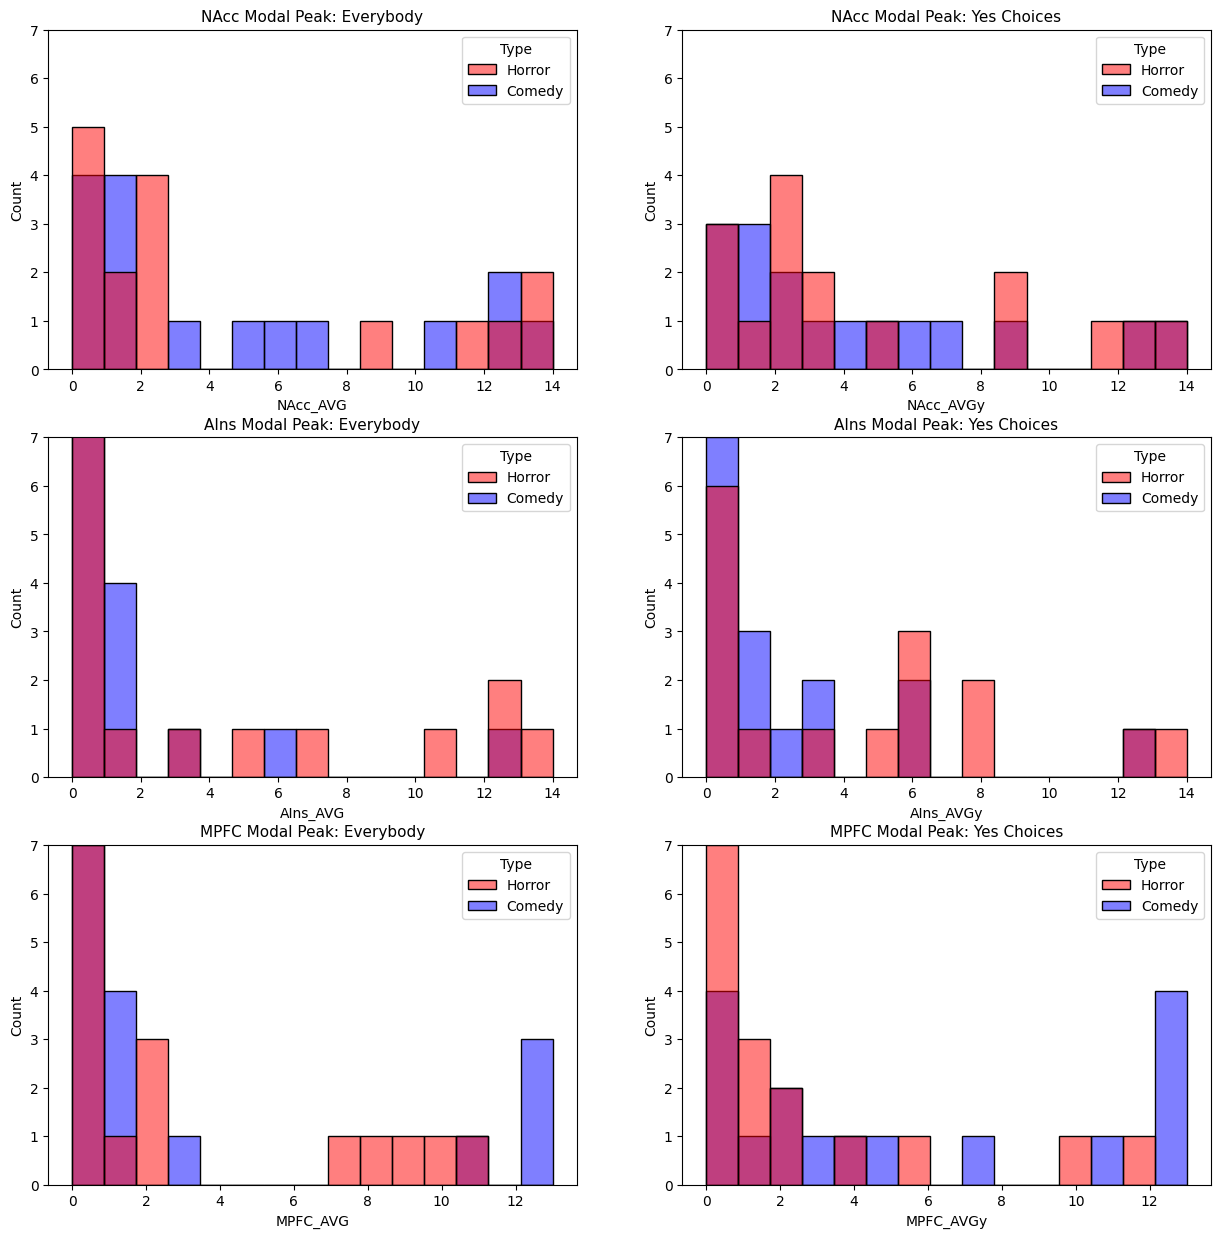

In [ ]:

fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharex=False)

sns.histplot(data=peaks_info_df, x="NAcc_AVG", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[0, 0])
axs[0, 0].set_title("NAcc Modal Peak: Everybody", size=11)
axs[0, 0].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="NAcc_AVGy", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[0, 1])
axs[0, 1].set_title("NAcc Modal Peak: Yes Choices", size=11)
axs[0, 1].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="AIns_AVG", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[1, 0])
axs[1, 0].set_title("AIns Modal Peak: Everybody", size=11)
axs[1, 0].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="AIns_AVGy", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[1, 1])
axs[1, 1].set_title("AIns Modal Peak: Yes Choices", size=11)
axs[1, 1].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="MPFC_AVG", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[2, 0])
axs[2, 0].set_title("MPFC Modal Peak: Everybody", size=11)
axs[2, 0].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="MPFC_AVGy", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[2, 1])
axs[2, 1].set_title("MPFC Modal Peak: Yes Choices", size=11)
axs[2, 1].set_ylim(0, 7)

(0.0, 7.0)

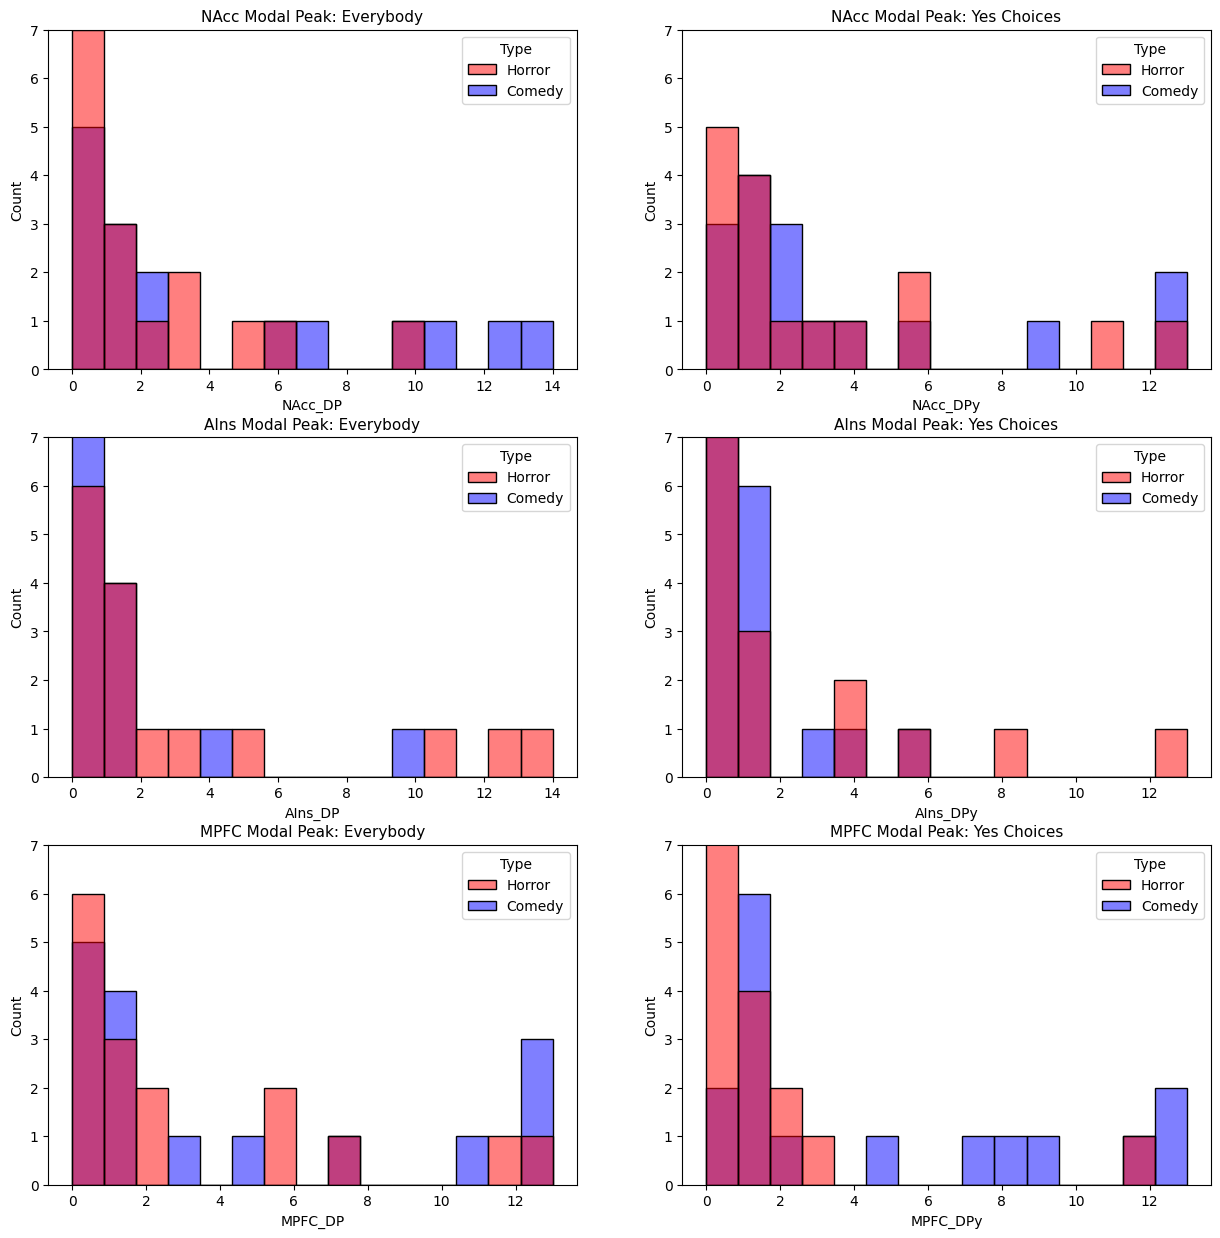

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharex=False)

sns.histplot(data=peaks_info_df, x="NAcc_DP", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[0, 0])
axs[0, 0].set_title("NAcc Modal Peak: Everybody", size=11)
axs[0, 0].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="NAcc_DPy", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[0, 1])
axs[0, 1].set_title("NAcc Modal Peak: Yes Choices", size=11)
axs[0, 1].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="AIns_DP", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[1, 0])
axs[1, 0].set_title("AIns Modal Peak: Everybody", size=11)
axs[1, 0].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="AIns_DPy", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[1, 1])
axs[1, 1].set_title("AIns Modal Peak: Yes Choices", size=11)
axs[1, 1].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="MPFC_DP", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[2, 0])
axs[2, 0].set_title("MPFC Modal Peak: Everybody", size=11)
axs[2, 0].set_ylim(0, 7)

sns.histplot(data=peaks_info_df, x="MPFC_DPy", hue="Type", palette=dict(Horror="red", Comedy="blue"), bins=15, ax=axs[2, 1])
axs[2, 1].set_title("MPFC Modal Peak: Yes Choices", size=11)
axs[2, 1].set_ylim(0, 7)


In [ ]:
# # participant_dictionaries_raw.keys()

w_comp_cor_04_list = []
c_comp_cor_04_list = []
a_comp_cor_04_list = []
t_comp_cor_01_list = []

for sub_id in participant_dictionaries_raw.keys():

    sub_run1_confounds_meta_path = "/Users/la/Documents/Datasets/MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-01_desc-confounds_timeseries.json"
    sub_run2_confounds_meta_path = "/Users/la/Documents/Datasets/MovieData_BIDS_preproc/" + sub_id + "/func/" + sub_id + "_task-movie_run-02_desc-confounds_timeseries.json"

    sub_run1_confounds_meta_df = pd.read_json(sub_run1_confounds_meta_path, orient='index')
    sub_run2_confounds_meta_df = pd.read_json(sub_run2_confounds_meta_path, orient='index')

# #     #Append 

    w_comp_cor_04_list.append(sub_run1_confounds_meta_df.loc["w_comp_cor_04", "CumulativeVarianceExplained"])
    w_comp_cor_04_list.append(sub_run2_confounds_meta_df.loc["w_comp_cor_04", "CumulativeVarianceExplained"])
    c_comp_cor_04_list.append(sub_run1_confounds_meta_df.loc["c_comp_cor_04", "CumulativeVarianceExplained"])
    c_comp_cor_04_list.append(sub_run2_confounds_meta_df.loc["c_comp_cor_04", "CumulativeVarianceExplained"])
    a_comp_cor_04_list.append(sub_run1_confounds_meta_df.loc["a_comp_cor_04", "CumulativeVarianceExplained"])
    a_comp_cor_04_list.append(sub_run2_confounds_meta_df.loc["a_comp_cor_04", "CumulativeVarianceExplained"])
    t_comp_cor_01_list.append(sub_run1_confounds_meta_df.loc["t_comp_cor_00", "CumulativeVarianceExplained"])
    t_comp_cor_01_list.append(sub_run2_confounds_meta_df.loc["t_comp_cor_00", "CumulativeVarianceExplained"])


<Axes: ylabel='Count'>

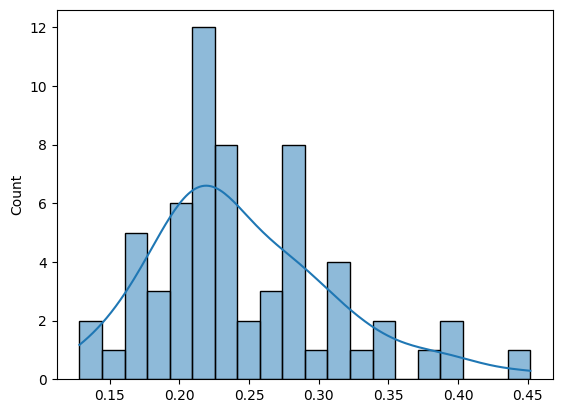

In [ ]:
sns.histplot(t_comp_cor_01_list, bins=20, kde=True)


In [ ]:
# sns.histplot(c_comp_cor_04_list, bins=20, kde=True)

In [ ]:
# # Test - Denoising strategies. 
# from nilearn.interfaces.fmriprep import load_confounds, load_confounds_strategy

# participant_num = "03"

# sub_run1_func_path = "/Users/luisalvarez/Documents/Datasets/MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
# sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

# sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
# sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.tsv"

# sub_run1_confounds_meta_path = "/Users/luisalvarez/Documents/Datasets/MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.json"
# sub_run2_confounds_meta_path = "/Users/luisalvarez/Documents/Datasets/MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.json"

# confounds_test, sample_mask_test = load_confounds(sub_run1_func_path, strategy=["motion", "wm_csf", "compcor", "high_pass", "scrub"], 
#                                                   motion="basic", wm_csf="basic", compcor="temporal_anat_separated", n_compcor=5, 
#                                                   fd_threshold=0.5, std_dvars_threshold=1.5, scrub=5)

#meta_test_df = pd.read_json(sub_run1_confounds_meta_path, orient='index')
# compcor_types = ['aCompCor', 'EdgeRegressor', 'tCompCor']
# #meta_test_df[(meta_test_df["Method"] == "aCompCor") & (meta_test_df["Mask"] == "WM")].head(10) # 0.13, 0.12, 0.11, 0.08, 0.06, 0.08
# confounds_test.columns


In [ ]:


# meta_test_df = pd.read_json(sub_run1_confounds_meta_path, orient='index')

# compcor_types = ['aCompCor', 'EdgeRegressor', 'tCompCor']

# confounds_list = meta_test_df[(meta_test_df["Method"] == "aCompCor") & (meta_test_df["Mask"] == "CSF") & (meta_test_df["CumulativeVarianceExplained"] < .35)].index.to_list()
# print(confounds_list)
#.head(20) #.unique()
#meta_test_df["Mask"].unique()